# NLP first exploration (executed on Google Colab)

The goal here is to match one recipe from a menu (user input) to one recipe in the JOW recipes list (remember that each Jow recipe will be marked with a corresponding environmental score, though this step is not yet finished).  
For this purpose, we use Hugging Face models designed to address the task of "sentence similarity".

In [125]:
import pandas as pd
import numpy as np
import re

Show the gpu infos and change if needed in "Execution" panel.   
Using GPUs is not compulsory here. I moved to Google Colab because my computer is slow.

In [126]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jan 23 12:20:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    32W /  70W |   4446MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Load JOW recipes

Import from Google Drive.  
Here the folder 'carbondiet4GD' only contains the folder data/ with subfolders Recipes/ and Tools/ (others are not used).

In [127]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/carbondiet4GD.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')     # create a copy directly in colab for efficiency reasons

Mounted at /content/drive


In [128]:
ls

carbondiet4GD/  drive/  sample_data/


**Indicate the path where the folder data/ is located.**

In [129]:
#data_path = '../'
data_path = 'carbondiet4GD/'

Extract the recipes

In [130]:
jow_path = data_path + 'data/Recipes/recipes_jow.json'
jow_data = pd.read_json(jow_path)
jow_recipes = list(jow_data.columns)
jow_recipes[:10]

['Yakitori bœuf fromage',
 'Gnocchis Epinards Gorgonzola',
 'Dahl de lentilles corail',
 'Veggie lasagna',
 'Pasta alla carbonara',
 'Tarte spirale de légumes',
 'Flammeküeche',
 'Chili con carne',
 'Les classiques coquillettes au jambon',
 'Knack & purée']

In [131]:
print("Number of JOW recipes = ", len(jow_recipes))

Number of JOW recipes =  1406


We remove ligatures, e.g. Bœuf -> Boeuf.  
This is probably useless.

In [132]:
REGEX_REPLACEMENTS = [(r"\u0153", "oe"), \
                      (r"\u0152", "Oe")]

def remove_ligatures(transcript):
    for old, new in REGEX_REPLACEMENTS:
        transcript = re.sub(old, new, transcript, flags=re.IGNORECASE)
    return transcript

jow_recipes = [remove_ligatures(str(s)) for s in jow_recipes]
jow_recipes[:10]

['Yakitori boeuf fromage',
 'Gnocchis Epinards Gorgonzola',
 'Dahl de lentilles corail',
 'Veggie lasagna',
 'Pasta alla carbonara',
 'Tarte spirale de légumes',
 'Flammeküeche',
 'Chili con carne',
 'Les classiques coquillettes au jambon',
 'Knack & purée']

### NLP models   
Test some models from https://huggingface.co/models?language=fr&pipeline_tag=sentence-similarity&sort=downloads   
Here we choose models adapted to the french language because JOW recipes are initially in french.  
But this should be probably modified later if we decide to work in english (especially because the additional database from the similar DataForGood project "batch7_tomorrow" is in english).

#### Choose the model   
For now, I've chosen the model randomly. They should be compared later.

In [133]:
! pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [134]:
from sentence_transformers import SentenceTransformer
model =  SentenceTransformer("dangvantuan/sentence-camembert-base")

#### Let's see on an example how the recipes are embedded into vectors 

In [135]:
recipes_sample = jow_recipes[:3]
embeddings = model.encode(recipes_sample)

for recipe, embedding in zip(recipes_sample, embeddings):
    print(recipe)
    print(len(embedding))
    print(embedding)
    print('\n')

Yakitori boeuf fromage
768
[-8.63985643e-02 -8.24166164e-02  1.21551223e-01 -1.16770184e-02
 -5.83998673e-02 -1.27657220e-01 -2.62654815e-02 -5.50822355e-02
  1.88705660e-02  1.03030894e-02  2.34557793e-01 -5.57783432e-02
 -8.11390281e-02  1.53788954e-01 -1.10326879e-01 -1.40445024e-01
 -7.15683028e-02 -7.46494755e-02  1.28476784e-01  2.85304282e-02
  4.57199030e-02 -5.62144555e-02  1.18656345e-01 -1.03589319e-01
  1.02051795e-01 -1.54627204e-01 -9.66684297e-02  3.16763148e-02
  7.83036798e-02 -2.87637617e-02  2.76491623e-02  6.13545105e-02
 -6.94284216e-02  1.05111152e-02  1.25139458e-02 -6.94677886e-03
  1.70914993e-01 -5.02581596e-02 -1.06957424e-02  1.46946043e-01
 -5.61127625e-02 -1.49213865e-01 -3.41145732e-02 -3.62445787e-02
 -6.27246825e-03 -8.93694162e-02  2.86752403e-01 -1.30919009e-01
 -1.68613363e-02  2.29871087e-02  1.02411367e-01  1.25826523e-01
  1.83557607e-02  2.21058633e-02 -3.82151455e-03 -9.14255455e-02
  5.09224236e-02  1.88557990e-02 -2.27881834e-01  1.55886412e-0

Each recipe is embedded in a vector of floats of length 768.  
Let's now do the embedding for all recipes. This is the longest part.

In [136]:
# Embedding of jow recipes
import time
t0 = time.time()
jow_recipe_embeddings = model.encode(jow_recipes, convert_to_tensor=True)
print("Time lapse for JOW embedding (s) = ", time.time()-t0)

Time lapse for JOW embedding (s) =  1.0903964042663574


#### Now let's try to find the jow recipes which are the closest to the input recipe (in principle extracted from a menu)  
The comparison between two recipes is done in the embedding space by computing the cosine similarity between each pair of embedding vectors.

Inspired from https://www.sbert.net/examples/applications/semantic-search/README.html   


In [137]:
from sentence_transformers import util
import torch



# Query recipes:
queries = ['Boeuf émincé sauté à la sauce soja, légumes et riz', \
           'Pizza margherita sauce tomate mozzarella']


# Find the closest 5 recipes of the (JOW) corpus for each query recipe based on cosine similarity
top_k = min(5, len(jow_recipes))
for query in queries:
    print("\n======================\n")
    t0 = time.time()
    query_embedding = model.encode(query, convert_to_tensor=True)
    print("Time lapse for one query embedding (s) = ", time.time()-t0)

    # We use cosine-similarity and torch.topk to find the highest 5 scores
    t0 = time.time()
    cos_scores = util.cos_sim(query_embedding, jow_recipe_embeddings)[0]
    top_results = torch.topk(cos_scores, k=top_k)

    print("Query:", query)
    print("\nTop 5 most similar recipes in JOW:")

    for score, idx in zip(top_results[0], top_results[1]):
        print(jow_recipes[idx], "(Score: {:.4f})".format(score))

    print("Time lapse for finding the 5 closest recipes (s) = ", time.time()-t0, '\n')
    

    # Alternatively, we can also use util.semantic_search to perform cosine similarty + topk
    t0 = time.time()
    hits = util.semantic_search(query_embedding, jow_recipe_embeddings, top_k=5)
    hits = hits[0]      #Get the hits for the first query
    for hit in hits:
        print(jow_recipes[hit['corpus_id']], "(Score: {:.4f})".format(hit['score']))
    print("Time lapse for finding the 5 closest recipes with semantic_search function (s) = ", time.time()-t0)
    



Time lapse for one query embedding (s) =  0.016807079315185547
Query: Boeuf émincé sauté à la sauce soja, légumes et riz

Top 5 most similar recipes in JOW:
Cabillaud & riz sauté aux légumes (Score: 0.7478)
Nouilles de riz & porc sauté (Score: 0.7142)
Poulet & nouilles sautées aux légumes (Score: 0.7128)
Brochettes teriyaki & riz sauté (Score: 0.6983)
Nouilles sautées légumes & oeuf (Score: 0.6978)
Time lapse for finding the 5 closest recipes (s) =  0.0067937374114990234 

Cabillaud & riz sauté aux légumes (Score: 0.7478)
Nouilles de riz & porc sauté (Score: 0.7142)
Poulet & nouilles sautées aux légumes (Score: 0.7128)
Brochettes teriyaki & riz sauté (Score: 0.6983)
Nouilles sautées légumes & oeuf (Score: 0.6978)
Time lapse for finding the 5 closest recipes with semantic_search function (s) =  0.002128124237060547


Time lapse for one query embedding (s) =  0.017475605010986328
Query: Pizza margherita sauce tomate mozzarella

Top 5 most similar recipes in JOW:
La tomate mozzarella (S

Using util.semantic_search seems to be twice faster.  
Let's keep in mind that finding the closest recipes is fast as soon as the jow recipes have been embedded (only once). 

This is weird/disappointing that there is no pizza in the 5 most similar recipes corresponding to "Pizza margherita sauce tomate mozzarella". But somehow the recipe name "La tomate mozzarella" in Jow is not precise enough (it is a salad, not a pizza, this cannot be guessed from the name). 

#### Let's test it on several input recipes and try to evaluate the model precision

In [138]:
jow_data = jow_data.transpose()
pd.set_option('display.max_colwidth', None)
jow_data['recipe_name'] = jow_data.index
jow_data['recipe_name'] = jow_data['recipe_name'].apply(lambda s: remove_ligatures(str(s)))
jow_data = jow_data.rename({'ingredients': 'ingredients_with_quantity'}, axis = 1)
jow_data.head()

,cuisson,ingredients_with_quantity,recipe_name
Yakitori bœuf fromage,10 minutes,"[[80 g, Bœuf (carpaccio)], [100 g, Emmental], [1 càs, Sauce Teriyaki], [70 g, Riz], [6, Pics à brochette]]",Yakitori boeuf fromage
Gnocchis Epinards Gorgonzola,5 minutes,"[[150 g, Gnocchi], [100 g, Epinard (frais)], [30 g, Gorgonzola], [5 cl, Crème liquide]]",Gnocchis Epinards Gorgonzola
Dahl de lentilles corail,plat froid,"[[50 g, Lentilles corail], [80 g, Tomate (chair)], [5 cl, Lait de coco], [1/2 gou., Ail]]",Dahl de lentilles corail
Veggie lasagna,50 minutes,"[[50 g, Lasagnes (cru)], [150 g, Courgette], [150 g, Tomate (purée)], [80 g, Champignons de Paris (frais)], [1/2, Mozzarella (boule)]]",Veggie lasagna
Pasta alla carbonara,9 minutes,"[[100 g, Pâtes (spaghetti)], [3 tran., Pancetta], [1, Œuf], [40 g, Parmesan (morceaux)]]",Pasta alla carbonara


In [139]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

# Query recipes:
queries = ['Boeuf émincé sauté à la sauce soja, légumes et riz', \
           'Pizza margherita sauce tomate mozzarella',
           'Tiramisu',
           'Spaghetti alla Carbonara, crème fraîche, poitrine',
           'Linguine Al Salmone, crème fraîche, saumon fumé',
           'Risotto Primavera, Asperges, artichaut et petit pois']


# Find the closest 5 recipes of the (JOW) corpus for each query recipe based on cosine similarity
top_k = min(10, len(jow_recipes))
for query in queries:
    print("\n======================\n")
    t0 = time.time()
    query_embedding = model.encode(query, convert_to_tensor=True)
    #print("Time lapse for one query embedding (s) = ", time.time()-t0, '\n')

    # We use util.semantic_search to perform cosine similarty + topk
    printmd("**Query : "+query+"**")
    print("\nTop 10 most similar recipes in JOW:")
    t0 = time.time()
    hits = util.semantic_search(query_embedding, jow_recipe_embeddings, top_k=10)
    hits = hits[0]      #Get the hits for the first query
    for k, hit in enumerate(hits):
        jow_recipe = jow_recipes[hit['corpus_id']]
        print(k+1, ") ", jow_recipe, "(Score: {:.4f})".format(hit['score']))
        print('--> ingredients = ', list(jow_data[jow_data['recipe_name']==jow_recipe]['ingredients_with_quantity']))
    #print("\n Time lapse for finding the 5 closest recipes with semantic_search function (s) = ", time.time()-t0)

**Query : Boeuf émincé sauté à la sauce soja, légumes et riz**


Top 10 most similar recipes in JOW:
1 )  Cabillaud & riz sauté aux légumes (Score: 0.7478)
--> ingredients =  [[['1', 'Cabillaud (frais)'], ['250 g', 'Julienne de légumes (surgelés)'], ['125 g', 'Riz (cuit)'], ['1 càs', 'Sauce soja salée']]]
2 )  Nouilles de riz & porc sauté (Score: 0.7142)
--> ingredients =  [[['80 g', 'Nouilles de riz'], ['80 g', 'Chair à saucisse'], ['50 g', 'Concombre'], ['20 g', 'Cacahuète'], ['1 pinc.', "Piment d'Espelette"], ['2 càs', 'Sauce soja salée'], ['Facultatif', '1/10 bou.', 'Menthe (feuilles)']]]
3 )  Poulet & nouilles sautées aux légumes (Score: 0.7128)
--> ingredients =  [[['70 g', 'Nouilles chinoises (aux œufs)'], ['1', 'Poulet (escalope)'], ['250 g', 'Julienne de légumes (surgelés)'], ['1 càs', 'Sauce soja salée']]]
4 )  Brochettes teriyaki & riz sauté (Score: 0.6983)
--> ingredients =  [[['1', 'Poulet (escalope)'], ['2 càs', 'Sauce soja sucrée'], ['70 g', 'Riz'], ['80 g', 'Petits pois (surgelés)'], ['1/2 gou.', 'Ail'], ['Facultatif', '20 g', 'Grai

**Query : Pizza margherita sauce tomate mozzarella**


Top 10 most similar recipes in JOW:
1 )  La tomate mozzarella (Score: 0.8154)
--> ingredients =  [[['350 g', 'Tomates multicolores'], ['90 g', 'Mozzarella di bufala'], ['1/10 bou.', 'Basilic (frais)']]]
2 )  Tian à la mozzarella (Score: 0.7376)
--> ingredients =  [[['1/2', 'Courgette'], ['1', 'Tomate'], ['1/2 gou.', 'Ail'], ['1/2', 'Aubergine'], ['1 pinc.', 'Thym (feuilles)'], ['1/4', 'Oignon jaune'], ['80 g', 'Mozzarella (à cuire)']]]
3 )  Cake tomate mozza & pesto (Score: 0.7358)
--> ingredients =  [[['1 sac.', 'Levure chimique'], ['150 g', 'Farine de blé'], ['3', 'Œuf'], ['125 g', 'Skyr'], ['4 cl', "Huile d'olive"], ['100 g', 'Mozzarella (boule)'], ['40 g', 'Sauce pesto'], ['100 g', 'Tomate cerise']]]
4 )  Tomate, mozzarella & anchois (Score: 0.7135)
--> ingredients =  [[['300 g', 'Tomates multicolores'], ['60 g', 'Mozzarella di bufala'], ['Facultatif', '1/10 bou.', 'Basilic (frais)'], ['20 g', 'Anchois']]]
5 )  Quiche bacon tomate mozza (Score: 0.7021)
--> ingredients =  [[['8 tra

**Query : Tiramisu**


Top 10 most similar recipes in JOW:
1 )  Tiramisu (Score: 1.0000)
--> ingredients =  [[['100 g', 'Sucre (en poudre)'], ['Facultatif', '1 sac.', 'Sucre vanillé'], ['3', 'Œuf'], ['2 càs', 'Cacao (en poudre)'], ['250 g', 'Mascarpone'], ['20', 'Biscuit cuiller'], ['2 càc', 'Café'], ['Facultatif', '1 càs', 'Amaretto']]]
2 )  Sangria (Score: 0.5193)
--> ingredients =  [[['10 cl', 'Vin rouge'], ['10 cl', 'Eau gazeuse'], ['1/4', 'Orange'], ['1/4', 'Citron jaune'], ['1/2 càs', 'Sucre (en poudre)']]]
3 )  Babka (Score: 0.5149)
--> ingredients =  [[['280 g', 'Farine de blé'], ['50 g', 'Sucre (en poudre)'], ['5 cl', 'Lait'], ['80 g', 'Beurre'], ['200 g', 'Pâte à tartiner'], ['1 sac.', 'Levure boulangère (sèche)'], ['3', 'Œuf'], ['100 g', 'Noisette']]]
4 )  Salade méditerranéenne (Score: 0.5130)
--> ingredients =  [[['2 poignées', 'Salade (mélange mâche-roquette)'], ['50 g', 'Pois chiches (cuits)'], ['30 g', 'Tomate séchée'], ['20 g', 'Chèvre frais'], ['1/4'], ['10 g'], ['Facultatif', '1 càc']]]
5

**Query : Spaghetti alla Carbonara, crème fraîche, poitrine**


Top 10 most similar recipes in JOW:
1 )  Gnocchis crème de parmesan & thym (Score: 0.6106)
--> ingredients =  [[['100 g', 'Gnocchi'], ['1/4 gou.', 'Ail'], ['1/2 càs', 'Parmesan (râpé)'], ['10 cl', 'Crème liquide'], ['1 pinc.', 'Thym (branches)']]]
2 )  Pizza pesto, tomates & burrata (Score: 0.5891)
--> ingredients =  [[['1', 'Pâte à pizza'], ['60 g', 'Sauce pesto'], ['200 g', 'Tomate cerise'], ['1', 'Burrata'], ['Facultatif', '1/5 bou.', 'Basilic (frais)']]]
3 )  Frittata courgette, jambon & mozza (Score: 0.5666)
--> ingredients =  [[['8', 'Œuf'], ['125 g', 'Mozzarella (boule)'], ['1', 'Courgette'], ['2 tran.', 'Jambon blanc']]]
4 )  Risotto parmesan & crevettes (Score: 0.5653)
--> ingredients =  [[['70 g', 'Riz (Arborio)'], ['50 g', 'Crevette (cuite)'], ['1/4', 'Bouillon de volaille (cube)'], ['1 càs', 'Parmesan (râpé)']]]
5 )  Pasta alla carbonara (Score: 0.5540)
--> ingredients =  [[['100 g', 'Pâtes (spaghetti)'], ['3 tran.', 'Pancetta'], ['1', 'Œuf'], ['40 g', 'Parmesan (morceaux)

**Query : Linguine Al Salmone, crème fraîche, saumon fumé**


Top 10 most similar recipes in JOW:
1 )  Omelette au saumon (Score: 0.6397)
--> ingredients =  [[['2', 'Œuf'], ['30 g', 'Fromage frais'], ['2 poignées', 'Salade (Mélange)'], ['1 tran.', 'Saumon (fumé)']]]
2 )  Filet de saumon en croûte, tomates & courgettes (Score: 0.6294)
--> ingredients =  [[['600 g', 'Filet de saumon'], ['600 g', 'Courgette'], ['400 g', 'Tomate cerise'], ['80 g', 'Parmesan (râpé)'], ['60 g', 'Beurre'], ['40 g', 'Chapelure']]]
3 )  Bowl au saumon fumé (Score: 0.6238)
--> ingredients =  [[['1 tran.', 'Saumon (fumé)'], ['100 g', 'Lentilles (cuites)'], ['1 poignée', 'Salade (mâche)'], ['100 g', 'Pomme de terre'], ['1 càs', 'Crème fraîche épaisse'], ['Facultatif', '1/10 bou.', 'Ciboulette']]]
4 )  Linguine saumon & petits pois (Score: 0.6136)
--> ingredients =  [[['100 g', 'Pâtes (Linguine)'], ['50 g', 'Petits pois (frais)'], ['1 tran.', 'Saumon (fumé)'], ['1 càs', 'Crème fraîche épaisse'], ['1/4', 'Citron jaune']]]
5 )  Flammeküeche au saumon (Score: 0.6127)
--> ingred

**Query : Risotto Primavera, Asperges, artichaut et petit pois**


Top 10 most similar recipes in JOW:
1 )  Quiche artichaut & parma (Score: 0.6021)
--> ingredients =  [[['1', 'Pâte brisée'], ['1', 'Mozzarella (boule)'], ['160 g', 'Artichauts marinés'], ['4 tran.', 'Jambon cru (Prosciutto)'], ['3', 'Œuf'], ['10 cl', 'Lait'], ['10 cl', 'Crème liquide']]]
2 )  Salade artichauts & noisettes (Score: 0.5636)
--> ingredients =  [[['120 g', 'Artichauts marinés'], ['2 poignées', 'Salade (roquette)'], ['40 g', 'Parmesan (morceaux)'], ['10 g', 'Noisette']]]
3 )  Pasta petits pois lardons (Score: 0.5577)
--> ingredients =  [[['100 g', 'Pâtes (Pipe rigate)'], ['100 g', 'Petits pois (frais)'], ['75 g', 'Lardons'], ['2 cl', 'Crème liquide'], ['2 càs'], ['Facultatif', '1/50 bou.']]]
4 )  Asperges & crème de parmesan (Score: 0.5553)
--> ingredients =  [[['200 g', 'Asperge blanche (fraîche)'], ['10 cl', 'Crème liquide'], ['1/2 càs', 'Parmesan (râpé)'], ['10 g', 'Noisette']]]
5 )  Risotto aux asperges (Score: 0.5533)
--> ingredients =  [[['70 g', 'Riz (Arborio)'], ['1

Let's see if we could find better matching recipes.

In [140]:
jow_data['recipe_name'][jow_data['recipe_name'].str.contains("Boeuf|boeuf")].values.tolist()

['Yakitori boeuf fromage',
 'Wok de boeuf légumes croquants',
 'Boeuf sauce roquefort',
 'Boeuf haricots verts & purée',
 'Curry de boeuf thaï',
 'Ramen au boeuf',
 'Enchiladas au boeuf',
 'Boeuf à la mexicaine',
 'Boeuf & crème persillée',
 'Tagliata de boeuf & courgettes',
 'Tagliata de boeuf à la grecque',
 'Boeuf thaï',
 'Boeuf façon Rossini',
 'Boeuf poivre & sel',
 'Boeuf sauté au chou',
 'Carpaccio de boeuf, sauce pesto',
 'Carpaccio de boeuf, soja wasabi',
 'Carpaccio de boeuf à la thaï',
 'Carpaccio de boeuf, citron & parmesan',
 'Boeuf & légumes sautés au pesto',
 'Wrap au boeuf braisé',
 'Nouilles sautées au boeuf',
 'Boeuf en croûte au foie gras',
 'Fajitas au boeuf express',
 'Boeuf bourguignon',
 'Rôti de boeuf & purée',
 'Rôti de boeuf & haricots verts',
 'Quesadillas au boeuf',
 'Tagliata de boeuf & brocolis',
 'Bo bun boeuf',
 'Salade thaï au boeuf',
 'Boeuf au brocoli',
 'Côte de boeuf',
 'Boeuf aux oignons & riz',
 'Bao au boeuf',
 'Aiguillettes de boeuf & légumes po

In [141]:
jow_data['recipe_name'][jow_data['recipe_name'].str.contains("Pizza")].values.tolist()

['Pizza Parma',
 'Pizza maison 3 fromages',
 'Pizza maison chèvre miel',
 'Pizza verde à la courgette',
 'Pizza verde à la burrata',
 'Pizza printanière',
 'Pizza saumon avocat',
 'Pizza poire gorgonzola',
 'Pizza puttanesca',
 'Pizza pesto, tomates & burrata',
 'Pizza prosciutto, chèvre & miel',
 'Pizza cerise, tapenade & tomme',
 'Pizza chorizo & artichaut',
 'Pizza Margherita',
 'Pizza champignons & ricotta',
 'Pizza aux anchois',
 'Pizza au chorizo',
 'Pizza bianca']

In [142]:
jow_data['recipe_name'][jow_data['recipe_name'].str.contains("carbonara")].values.tolist()

['Pasta alla carbonara']

In [143]:
jow_data['recipe_name'][jow_data['recipe_name'].str.contains("Risotto")].values.tolist()

['Risotto aux Saint-Jacques & poireaux',
 'Risotto aux poireaux',
 'Risotto au pesto',
 'Risotto de coquillettes',
 'Risotto crevettes & chorizo',
 'Risotto de quinoa au brocoli',
 'Risotto aux asperges',
 'Risotto aux courgettes',
 "Risotto comté & saucisse à l'ancienne",
 'Risotto aux poivrons',
 'Risotto aux champignons',
 'Risotto au potimarron',
 'Risotto de quinoa aux carottes',
 'Risotto crevettes & petits pois',
 'Risotto aux tomates',
 'Risotto parmesan & crevettes',
 'Risotto épinards & chèvre',
 'Risotto bianco',
 'Risotto courgette & prosciutto',
 'Risotto aux morilles & mascarpone',
 'Risotto de coquillettes aux petits pois',
 'Risotto gorgonzola, épinards & noix']

#### Let's see if this can be improved with another model.

In [144]:
model2 =  SentenceTransformer("dangvantuan/sentence-camembert-large")

In [145]:
t0 = time.time()
jow_recipe_embeddings2 = model2.encode(jow_recipes, convert_to_tensor=True)
print("Time lapse for JOW embedding (s) = ", time.time()-t0)

Time lapse for JOW embedding (s) =  4.4764180183410645


The above cell takes much longer to be executed than the equivalent one for the first model (with GPU executing mode, this remains fast).

In [146]:
# Query recipes:
queries = ['Boeuf émincé sauté à la sauce soja, légumes et riz', \
           'Pizza margherita sauce tomate mozzarella',
           'Tiramisu',
           'Spaghetti alla Carbonara, crème fraîche, poitrine',
           'Linguine Al Salmone, crème fraîche, saumon fumé',
           'Risotto Primavera, Asperges, artichaut et petit pois']


# Find the closest 5 recipes of the (JOW) corpus for each query recipe based on cosine similarity
for query in queries:
    print("\n======================\n")
    t0 = time.time()
    query_embedding2 = model2.encode(query, convert_to_tensor=True)
    #print("Time lapse for one query embedding (s) = ", time.time()-t0, '\n')

    # We use util.semantic_search to perform cosine similarty + topk
    printmd("**Query : "+query+"**")
    print("\nTop 10 most similar recipes in JOW:")
    t0 = time.time()
    hits = util.semantic_search(query_embedding2, jow_recipe_embeddings2, top_k=10)
    hits = hits[0]      #Get the hits for the first query
    for k, hit in enumerate(hits):
        jow_recipe = jow_recipes[hit['corpus_id']]
        print(k+1, ") ", jow_recipe, "(Score: {:.4f})".format(hit['score']))
        print('--> ingredients = ', list(jow_data[jow_data['recipe_name']==jow_recipe]['ingredients_with_quantity']))
    #print("\n Time lapse for finding the 5 closest recipes with semantic_search function (s) = ", time.time()-t0)

**Query : Boeuf émincé sauté à la sauce soja, légumes et riz**


Top 10 most similar recipes in JOW:
1 )  Wok de boeuf légumes croquants (Score: 0.7559)
--> ingredients =  [[['1', 'Bœuf (rumsteck)'], ['1', 'Carotte (frais)'], ['50 g', 'Petits pois (frais)'], ['1/2', 'Courgette'], ['Facultatif', '1/2 càc', 'Graines de sésame'], ['1 cm', 'Gingembre (frais)']]]
2 )  Boeuf & légumes sautés au pesto (Score: 0.7425)
--> ingredients =  [[['1', 'Bœuf (steak)'], ['1 càc', 'Sauce pesto'], ['100 g', 'Tomate cerise'], ['100 g', 'Courgette'], ['1/2', 'Poivron rouge'], ['1/4 gou.', 'Ail']]]
3 )  Boeuf aux oignons & riz (Score: 0.7339)
--> ingredients =  [[['1', 'Bœuf (bavette)'], ['70 g', 'Riz'], ['1/4', 'Oignon jaune'], ['3 càs', 'Sauce soja salée'], ['5 g', 'Maïzena'], ['1 càs', 'Miel (liquide)']]]
4 )  Boeuf sauté au chou (Score: 0.6736)
--> ingredients =  [[['70 g', 'Riz'], ['100 g', 'Bœuf (haché)'], ['1 càs', 'Sauce soja salée'], ['1 cm', 'Gingembre (frais)'], ['Facultatif']]]
5 )  Carpaccio de boeuf, soja wasabi (Score: 0.6690)
--> ingredients =  [[['100 g

**Query : Pizza margherita sauce tomate mozzarella**


Top 10 most similar recipes in JOW:
1 )  La tomate mozzarella (Score: 0.8112)
--> ingredients =  [[['350 g', 'Tomates multicolores'], ['90 g', 'Mozzarella di bufala'], ['1/10 bou.', 'Basilic (frais)']]]
2 )  Pâte à pizza maison (Score: 0.8013)
--> ingredients =  [[['500 g', 'Farine de blé'], ['1 sac.', 'Levure boulangère (sèche)'], ['1 càc', 'Sucre (en poudre)'], ['2 càs', "Huile d'olive"]]]
3 )  Salade pâtes, tomates, mozzarella & chorizo (Score: 0.7918)
--> ingredients =  [[['80 g', 'Pâtes (Fusilli)'], ['100 g', 'Tomate cerise'], ['1/4', 'Concombre'], ['60 g', 'Mozzarella (mini)']]]
4 )  Pizza pesto, tomates & burrata (Score: 0.7696)
--> ingredients =  [[['1', 'Pâte à pizza'], ['60 g', 'Sauce pesto'], ['200 g', 'Tomate cerise'], ['1', 'Burrata'], ['Facultatif', '1/5 bou.', 'Basilic (frais)']]]
5 )  Cake tomate mozza & pesto (Score: 0.7475)
--> ingredients =  [[['1 sac.', 'Levure chimique'], ['150 g', 'Farine de blé'], ['3', 'Œuf'], ['125 g', 'Skyr'], ['4 cl', "Huile d'olive"], ['100

**Query : Tiramisu**


Top 10 most similar recipes in JOW:
1 )  Tiramisu (Score: 1.0000)
--> ingredients =  [[['100 g', 'Sucre (en poudre)'], ['Facultatif', '1 sac.', 'Sucre vanillé'], ['3', 'Œuf'], ['2 càs', 'Cacao (en poudre)'], ['250 g', 'Mascarpone'], ['20', 'Biscuit cuiller'], ['2 càc', 'Café'], ['Facultatif', '1 càs', 'Amaretto']]]
2 )  Roulé façon tiramisu (Score: 0.6508)
--> ingredients =  [[['4', 'Œuf'], ['125 g', 'Farine de blé'], ['125 g', 'Sucre (en poudre)'], ['1 càc', 'Levure chimique'], ['35 g'], ['25 cl'], ['120 g'], ['15 g']]]
3 )  Risotto au potimarron (Score: 0.3655)
--> ingredients =  [[['70 g', 'Riz (Arborio)'], ['1/4', 'Potimarron'], ['1/4', 'Bouillon de légumes (cube)'], ['2 cl', 'Vin blanc']]]
4 )  Saumon teriyaki, céréales & potimarron (Score: 0.3282)
--> ingredients =  [[['1/6', 'Potimarron'], ['1', 'Saumon (frais)'], ['1/2 càs', 'Sauce soja salée'], ['1 càc', 'Miel (liquide)'], ['50 g']]]
5 )  Risotto aux morilles & mascarpone (Score: 0.3201)
--> ingredients =  [[['70 g', 'Riz (Ar

**Query : Spaghetti alla Carbonara, crème fraîche, poitrine**


Top 10 most similar recipes in JOW:
1 )  Pasta alla carbonara (Score: 0.6220)
--> ingredients =  [[['100 g', 'Pâtes (spaghetti)'], ['3 tran.', 'Pancetta'], ['1', 'Œuf'], ['40 g', 'Parmesan (morceaux)']]]
2 )  Panna cotta à la fraise (Score: 0.5349)
--> ingredients =  [[['80 g', 'Fraise'], ['10 cl', 'Crème liquide'], ['2 càs', 'Sucre (en poudre)'], ['1/4', 'Vanille (gousse)'], ['1/2', 'Gélatine']]]
3 )  Pâtes au beaufort & jambon (Score: 0.5227)
--> ingredients =  [[['130 g', 'Pâtes (Fusilli)'], ['1 tran.', 'Jambon blanc'], ['5 cl', 'Crème liquide'], ['40 g', 'Beaufort']]]
4 )  Carottes rôties & yaourt (Score: 0.5160)
--> ingredients =  [[['300 g', 'Carotte (frais)'], ['100 g', 'Yaourt Grec'], ['1/4', 'Citron jaune'], ['2 pinc.', 'Paprika'], ['1/4 gou.', 'Ail'], ['1 càs', "Huile d'olive"]]]
5 )  Gratin de pâtes lard & cabécou (Score: 0.5143)
--> ingredients =  [[['100 g', 'Pâtes (macaroni)'], ['1/2', 'Cabécou'], ['8 cl', 'Crème liquide'], ['3 tran.', 'Lard (tranches)'], ['15 g', 'Froma

**Query : Linguine Al Salmone, crème fraîche, saumon fumé**


Top 10 most similar recipes in JOW:
1 )  Salade de saumon mariné (Score: 0.6453)
--> ingredients =  [[['1', 'Saumon (frais)'], ['1 càs', 'Sauce soja salée'], ['150 g', 'Concombre'], ['50 g', 'Feta'], ['1 càc', "Sirop d'érable"], ['1 poignée', 'Salade (Mélange)']]]
2 )  Rösti & saumon fumé (Score: 0.6364)
--> ingredients =  [[['500 g', 'Pomme de terre'], ['1', 'Œuf'], ['2 càc', 'Farine de blé'], ['1/2', 'Oignon jaune'], ['2 tran.', 'Saumon (fumé)'], ['2 càs', 'Crème fraîche épaisse']]]
3 )  Linguine saumon & petits pois (Score: 0.6124)
--> ingredients =  [[['100 g', 'Pâtes (Linguine)'], ['50 g', 'Petits pois (frais)'], ['1 tran.', 'Saumon (fumé)'], ['1 càs', 'Crème fraîche épaisse'], ['1/4', 'Citron jaune']]]
4 )  Flammeküeche au saumon (Score: 0.6121)
--> ingredients =  [[['1', 'Pâte à pizza'], ['3 càs', 'Fromage blanc'], ['3 càs', 'Crème fraîche épaisse'], ['2 tran.', 'Saumon (fumé)'], ['1/2', 'Oignon rouge']]]
5 )  Pancakes saumon fumé (Score: 0.5935)
--> ingredients =  [[['80 g', '

**Query : Risotto Primavera, Asperges, artichaut et petit pois**


Top 10 most similar recipes in JOW:
1 )  Risotto de coquillettes aux petits pois (Score: 0.6647)
--> ingredients =  [[['80 g', 'Pâtes (coquillettes)'], ['80 g', 'Petits pois (surgelés)'], ['50 g', 'Lardons'], ['1 càs', 'Crème fraîche épaisse']]]
2 )  Risotto aux asperges (Score: 0.6598)
--> ingredients =  [[['70 g', 'Riz (Arborio)'], ['100 g', 'Asperges vertes (fraîches)'], ['1/4', 'Bouillon de légumes (cube)'], ['1 càs', 'Parmesan (râpé)']]]
3 )  oeuf cocotte asperges petits pois (Score: 0.6417)
--> ingredients =  [[['1', 'Œuf'], ['1 càs', 'Fromage frais'], ['1 tran.', 'Pain de mie'], ['80 g', 'Petits pois (surgelés)'], ['80 g']]]
4 )  Pasta petits pois lardons (Score: 0.6278)
--> ingredients =  [[['100 g', 'Pâtes (Pipe rigate)'], ['100 g', 'Petits pois (frais)'], ['75 g', 'Lardons'], ['2 cl', 'Crème liquide'], ['2 càs'], ['Facultatif', '1/50 bou.']]]
5 )  Risotto crevettes & petits pois (Score: 0.6200)
--> ingredients =  [[['70 g', 'Riz (Arborio)'], ['70 g', 'Crevette (cuite)'], ['1

The results are slightly better.

#### Let's repeat this for a model valid for french and english (in prevision of new database). I can't find a model that also works for italian (but I guess that italian words like pizza, pasta, ... are also included in french/english vocabularies)

In [147]:
model3 =  SentenceTransformer("raphaelsty/semanlink_all_mpnet_base_v2")

In [148]:
t0 = time.time()
jow_recipe_embeddings3 = model3.encode(jow_recipes, convert_to_tensor=True)
print("Time lapse for JOW embedding (s) = ", time.time()-t0)

Time lapse for JOW embedding (s) =  1.303314208984375


In [149]:
# Query recipes:
queries = ['Boeuf émincé sauté à la sauce soja, légumes et riz', \
           'Pizza margherita sauce tomate mozzarella',
           'Tiramisu',
           'Spaghetti alla Carbonara, crème fraîche, poitrine',
           'Linguine Al Salmone, crème fraîche, saumon fumé',
           'Risotto Primavera, Asperges, artichaut et petit pois']


# Find the closest 5 recipes of the (JOW) corpus for each query recipe based on cosine similarity
for query in queries:
    print("\n======================\n")
    #t0 = time.time()
    query_embedding3 = model3.encode(query, convert_to_tensor=True)
    #print("Time lapse for one query embedding (s) = ", time.time()-t0, '\n')

    # We use util.semantic_search to perform cosine similarty + topk
    printmd("**Query : "+query+"**")
    print("\nTop 10 most similar recipes in JOW:")
    #t0 = time.time()
    hits = util.semantic_search(query_embedding3, jow_recipe_embeddings3, top_k=10)
    hits = hits[0]      #Get the hits for the first query
    for k, hit in enumerate(hits):
        jow_recipe = jow_recipes[hit['corpus_id']]
        print(k+1, ") ", jow_recipe, "(Score: {:.4f})".format(hit['score']))
        print('--> ingredients = ', list(jow_data[jow_data['recipe_name']==jow_recipe]['ingredients_with_quantity']))
    #print("\n Time lapse for finding the 5 closest recipes with semantic_search function (s) = ", time.time()-t0)

**Query : Boeuf émincé sauté à la sauce soja, légumes et riz**


Top 10 most similar recipes in JOW:
1 )  Tofu fumé et haricots verts (Score: 0.9915)
--> ingredients =  [[['100 g', 'Tofu (fumé)'], ['1/2 càs', 'Sauce soja salée'], ['200 g', 'Haricot vert (frais)'], ['1/2 càc', 'Graines de sésame'], ['1/4 gou.']]]
2 )  Poulet & poêlée légumes au curry (Score: 0.9910)
--> ingredients =  [[['1', 'Poulet (escalope)'], ['1/2', 'Courgette'], ['2', 'Carotte (frais)'], ['1 càc', 'Curry (poudre)'], ['1/2 gou.', 'Ail'], ['Facultatif', '1/5 bou.', 'Coriandre (frais)']]]
3 )  Nouilles sautées aux légumes d'été (Score: 0.9910)
--> ingredients =  [[['70 g', 'Nouilles chinoises (aux œufs)'], ['50 g', 'Tomate cerise'], ['50 g', 'Courgette'], ['1/2 càs', 'Sauce soja salée'], ['1/4 gou.', 'Ail']]]
4 )  Aiguillettes de boeuf & légumes poêlés (Score: 0.9902)
--> ingredients =  [[['150 g', 'Bœuf (aiguillette)'], ['1', 'Poivron (assortiment)'], ['1/4', 'Oignon jaune'], ['70 g', 'Riz'], ['Facultatif']]]
5 )  Saumon au cidre & purée de chou-fleur (Score: 0.9900)
--> ingred

**Query : Pizza margherita sauce tomate mozzarella**


Top 10 most similar recipes in JOW:
1 )  Gratin de gnocchis à la mozzarella (Score: 0.9900)
--> ingredients =  [[['150 g', 'Gnocchi'], ['70 g', 'Tomate (purée)'], ['1/4', 'Mozzarella (boule)'], ['Facultatif', '1/10 bou.', 'Basilic (frais)']]]
2 )  Tomato soup & grilled cheese (Score: 0.9896)
--> ingredients =  [[['200 g', 'Tomate pelée'], ['1/4', 'Oignon jaune'], ['1/4', 'Bouillon de légumes (cube)'], ['1/4 gou.', 'Ail'], ['1 càs', 'Crème fraîche épaisse'], ['20 g', 'Mozzarella (rapé)'], ['20 g', 'Cheddar (râpé)'], ['2 tran.', 'Pain de mie']]]
3 )  Pizza prosciutto, chèvre & miel (Score: 0.9895)
--> ingredients =  [[['1', 'Pâte à pizza'], ['60 g', 'Tomate (purée)'], ['2 càs', 'Chèvre frais'], ['4 tran.', 'Jambon cru (Prosciutto)'], ['1 poignée', 'Salade (roquette)'], ['1 càc', 'Miel (liquide)']]]
4 )  La tomate mozzarella (Score: 0.9894)
--> ingredients =  [[['350 g', 'Tomates multicolores'], ['90 g', 'Mozzarella di bufala'], ['1/10 bou.', 'Basilic (frais)']]]
5 )  Bouillon de gnocchi

**Query : Tiramisu**


Top 10 most similar recipes in JOW:
1 )  Tiramisu (Score: 1.0000)
--> ingredients =  [[['100 g', 'Sucre (en poudre)'], ['Facultatif', '1 sac.', 'Sucre vanillé'], ['3', 'Œuf'], ['2 càs', 'Cacao (en poudre)'], ['250 g', 'Mascarpone'], ['20', 'Biscuit cuiller'], ['2 càc', 'Café'], ['Facultatif', '1 càs', 'Amaretto']]]
2 )  Tomate, mozzarella & anchois (Score: 0.9875)
--> ingredients =  [[['300 g', 'Tomates multicolores'], ['60 g', 'Mozzarella di bufala'], ['Facultatif', '1/10 bou.', 'Basilic (frais)'], ['20 g', 'Anchois']]]
3 )  Soupe marocaine (Score: 0.9865)
--> ingredients =  [[['300 g', 'Tomate (chair)'], ['1/4', 'Oignon jaune'], ['1/4 gou.', 'Ail'], ['2 cl', 'Lait de coco'], ['Facultatif', '1/10 bou.', 'Coriandre (frais)'], ['2 pinc.', 'Thym (feuilles)'], ['40 g', 'Pois chiches (cuits)'], ['1 pinc.', 'Cumin (moulu)']]]
4 )  Cake tomate mozza & pesto (Score: 0.9861)
--> ingredients =  [[['1 sac.', 'Levure chimique'], ['150 g', 'Farine de blé'], ['3', 'Œuf'], ['125 g', 'Skyr'], ['4 cl

**Query : Spaghetti alla Carbonara, crème fraîche, poitrine**


Top 10 most similar recipes in JOW:
1 )  Filet de poisson pané & sauce tartare (Score: 0.9890)
--> ingredients =  [[['1', 'Filet de poisson (pané)'], ['200 g', 'Petits pois (surgelés)'], ['1/4', 'Oignon jaune'], ['1 càc', 'Sauce tartare'], ['Facultatif']]]
2 )  Toast chèvre, abricot & pistache (Score: 0.9889)
--> ingredients =  [[['2 tran.', 'Pain de campagne (tranché)'], ['20 g', 'Abricots (secs)'], ['30 g', 'Chèvre frais'], ['10 g', 'Pistaches (grillées)'], ['1 càc', 'Miel (liquide)']]]
3 )  Risotto aux morilles & mascarpone (Score: 0.9885)
--> ingredients =  [[['70 g', 'Riz (Arborio)'], ['10 g', 'Morilles (séchées)'], ['1/4', 'Bouillon de légumes (cube)'], ['1 càs', 'Parmesan (râpé)'], ['2 cl', 'Vin blanc'], ['1/2', 'Échalote'], ['1 càs', 'Mascarpone']]]
4 )  Lasagnes courgette ricotta (Score: 0.9870)
--> ingredients =  [[['90 g', 'Lasagnes (cru)'], ['500 g', 'Courgette'], ['100 g', 'Mozzarella (boule)'], ['100 g', 'Ricotta']]]
5 )  Gnocchis, brocoli & gorgonzola (Score: 0.9866)
--

**Query : Linguine Al Salmone, crème fraîche, saumon fumé**


Top 10 most similar recipes in JOW:
1 )  Smashed potatoes & saumon fumé (Score: 0.9867)
--> ingredients =  [[['250 g', 'Pomme de terre (petites)'], ['1 càs', 'Crème fraîche épaisse'], ['2 tran.', 'Saumon (fumé)'], ['2 poignées', 'Salade (mâche)'], ['Facultatif']]]
2 )  Gratin de ravioles au saumon (Score: 0.9865)
--> ingredients =  [[['120 g', 'ravioles au fromage'], ['1', 'Poireau'], ['1 tran.', 'Saumon (fumé)'], ['10 cl', 'Crème liquide'], ['20 g', 'Comté']]]
3 )  Salade de pommes de terre au haddock (Score: 0.9863)
--> ingredients =  [[['250 g', 'Pomme de terre'], ['100 g', 'Haddock fumé'], ['1 càs', 'Crème fraîche épaisse'], ['1/4', 'Citron jaune']]]
4 )  Salade endives, poires & gorgonzola (Score: 0.9846)
--> ingredients =  [[['2', 'Endives'], ['1', 'Poire'], ['20 g', 'Noix'], ['20 g', 'Gorgonzola']]]
5 )  Salade patate douce rôtie & pécan (Score: 0.9845)
--> ingredients =  [[['200 g', 'Patate douce'], ['40 g', 'Feta'], ['1 poignée', 'Salade (Mélange)'], ['20 g', 'Noix de pecan']

**Query : Risotto Primavera, Asperges, artichaut et petit pois**


Top 10 most similar recipes in JOW:
1 )  Risotto épinards & chèvre (Score: 0.9874)
--> ingredients =  [[['70 g', 'Riz (Arborio)'], ['2 poignées', 'Epinard (frais)'], ['1/4', 'Bouillon de légumes (cube)'], ['1 càs', 'Parmesan (râpé)']]]
2 )  Cabillaud & légumes du soleil (Score: 0.9873)
--> ingredients =  [[['1', 'Cabillaud (frais)'], ['100 g', 'Courgette'], ['100 g', 'Tomate'], ['100 g', 'Poivron rouge'], ['1/4', 'Oignon rouge']]]
3 )  Légumes sautés, gingembre & cajou (Score: 0.9865)
--> ingredients =  [[['1/2 gou.', 'Ail'], ['1 cm', 'Gingembre (frais)'], ['2', 'Carotte (frais)'], ['1/2', 'Brocoli (frais)'], ['1 càs', 'Sauce soja salée'], ['20 g', 'Noix de cajou']]]
4 )  Merguez & légumes du soleil (Score: 0.9862)
--> ingredients =  [[['2', 'Merguez'], ['1', 'Courgette'], ['150 g', 'Tomates multicolores'], ['1 pinc.', 'Romarin (séché)']]]
5 )  Salade nectarines, haricots & amandes (Score: 0.9861)
--> ingredients =  [[['200 g', 'Haricot vert (frais)'], ['1', 'Nectarine'], ['15 g', 'Am

This is bad , let's see with another model

In [150]:
model4 =  SentenceTransformer("symanto/sn-xlm-roberta-base-snli-mnli-anli-xnli")

In [151]:
t0 = time.time()
jow_recipe_embeddings4 = model4.encode(jow_recipes, convert_to_tensor=True)
print("Time lapse for JOW embedding (s) = ", time.time()-t0)

Time lapse for JOW embedding (s) =  1.5502452850341797


In [152]:
# Query recipes:
queries = ['Boeuf émincé sauté à la sauce soja, légumes et riz', \
           'Pizza margherita sauce tomate mozzarella',
           'Tiramisu',
           'Spaghetti alla Carbonara, crème fraîche, poitrine',
           'Linguine Al Salmone, crème fraîche, saumon fumé',
           'Risotto Primavera, Asperges, artichaut et petit pois']


# Find the closest 5 recipes of the (JOW) corpus for each query recipe based on cosine similarity
for query in queries:
    print("\n======================\n")
    #t0 = time.time()
    query_embedding4 = model4.encode(query, convert_to_tensor=True)
    #print("Time lapse for one query embedding (s) = ", time.time()-t0, '\n')

    # We use util.semantic_search to perform cosine similarty + topk
    printmd("**Query : "+query+"**")
    print("\nTop 10 most similar recipes in JOW:")
    #t0 = time.time()
    hits = util.semantic_search(query_embedding4, jow_recipe_embeddings4, top_k=10)
    hits = hits[0]      #Get the hits for the first query
    for k, hit in enumerate(hits):
        jow_recipe = jow_recipes[hit['corpus_id']]
        print(k+1, ") ", jow_recipe, "(Score: {:.4f})".format(hit['score']))
        print('--> ingredients = ', list(jow_data[jow_data['recipe_name']==jow_recipe]['ingredients_with_quantity']))
    #print("\n Time lapse for finding the 5 closest recipes with semantic_search function (s) = ", time.time()-t0)

**Query : Boeuf émincé sauté à la sauce soja, légumes et riz**


Top 10 most similar recipes in JOW:
1 )  Aiguillettes de boeuf & légumes poêlés (Score: 0.8064)
--> ingredients =  [[['150 g', 'Bœuf (aiguillette)'], ['1', 'Poivron (assortiment)'], ['1/4', 'Oignon jaune'], ['70 g', 'Riz'], ['Facultatif']]]
2 )  Saumon, épinards à la crème & riz (Score: 0.8061)
--> ingredients =  [[['1', 'Saumon (frais)'], ['70 g', 'Riz'], ['100 g', 'Épinards à la crème']]]
3 )  Cabillaud & riz sauté aux légumes (Score: 0.7888)
--> ingredients =  [[['1', 'Cabillaud (frais)'], ['250 g', 'Julienne de légumes (surgelés)'], ['125 g', 'Riz (cuit)'], ['1 càs', 'Sauce soja salée']]]
4 )  Boeuf aux oignons & riz (Score: 0.7885)
--> ingredients =  [[['1', 'Bœuf (bavette)'], ['70 g', 'Riz'], ['1/4', 'Oignon jaune'], ['3 càs', 'Sauce soja salée'], ['5 g', 'Maïzena'], ['1 càs', 'Miel (liquide)']]]
5 )  Poulet, chorizo et légumes rôtis (Score: 0.7793)
--> ingredients =  [[['1', 'Poulet (escalope)'], ['200 g', 'Pomme de terre (petites)'], ['1/2 gou.', 'Ail'], ['1/2', 'Poivron rouge

**Query : Pizza margherita sauce tomate mozzarella**


Top 10 most similar recipes in JOW:
1 )  La tomate mozzarella (Score: 0.7972)
--> ingredients =  [[['350 g', 'Tomates multicolores'], ['90 g', 'Mozzarella di bufala'], ['1/10 bou.', 'Basilic (frais)']]]
2 )  Pizza pesto, tomates & burrata (Score: 0.7846)
--> ingredients =  [[['1', 'Pâte à pizza'], ['60 g', 'Sauce pesto'], ['200 g', 'Tomate cerise'], ['1', 'Burrata'], ['Facultatif', '1/5 bou.', 'Basilic (frais)']]]
3 )  Quiche ratatouille & mozzarella (Score: 0.7760)
--> ingredients =  [[['1', 'Pâte brisée'], ['3', 'Œuf'], ['10 cl', 'Lait'], ['10 cl', 'Crème liquide'], ['1', 'Mozzarella (boule)'], ['300 g', 'Ratatouille'], ['1 càc', 'Herbes de provence']]]
4 )  Pizza puttanesca (Score: 0.7682)
--> ingredients =  [[['1', 'Pâte à pizza'], ['60 g', 'Tomate (purée)'], ['60 g', 'Anchois'], ['60 g', 'Olive noire'], ['1 càs', 'Câpres'], ['1', 'Mozzarella (boule)']]]
5 )  Salade pâtes, tomates, mozzarella & chorizo (Score: 0.7660)
--> ingredients =  [[['80 g', 'Pâtes (Fusilli)'], ['100 g', 'To

**Query : Tiramisu**


Top 10 most similar recipes in JOW:
1 )  Tiramisu (Score: 1.0000)
--> ingredients =  [[['100 g', 'Sucre (en poudre)'], ['Facultatif', '1 sac.', 'Sucre vanillé'], ['3', 'Œuf'], ['2 càs', 'Cacao (en poudre)'], ['250 g', 'Mascarpone'], ['20', 'Biscuit cuiller'], ['2 càc', 'Café'], ['Facultatif', '1 càs', 'Amaretto']]]
2 )  Roulé façon tiramisu (Score: 0.6882)
--> ingredients =  [[['4', 'Œuf'], ['125 g', 'Farine de blé'], ['125 g', 'Sucre (en poudre)'], ['1 càc', 'Levure chimique'], ['35 g'], ['25 cl'], ['120 g'], ['15 g']]]
3 )  Mauresque (Score: 0.5204)
--> ingredients =  [[['1 cl', "Sirop d'orgeat"], ['3 cl', 'Pastis']]]
4 )  Quiche Lorraine (Score: 0.5142)
--> ingredients =  [[['1', 'Pâte brisée'], ['200 g', 'Lardons'], ['20 cl', 'Lait'], ['100 g', 'Crème fraîche épaisse'], ['3', 'Œuf']]]
5 )  Galette de sarrasin (Score: 0.5129)
--> ingredients =  [[['100 g', 'Farine de Sarrasin']]]
6 )  Soupe de Tortellini (Score: 0.4974)
--> ingredients =  [[['80 g', 'Tomate (chair)'], ['50 g', 'Cha

**Query : Spaghetti alla Carbonara, crème fraîche, poitrine**


Top 10 most similar recipes in JOW:
1 )  Cabillaud & épinards à la crème (Score: 0.7271)
--> ingredients =  [[['1', 'Cabillaud (frais)'], ['250 g', 'Épinards à la crème']]]
2 )  Gratin de pâtes lard & cabécou (Score: 0.7029)
--> ingredients =  [[['100 g', 'Pâtes (macaroni)'], ['1/2', 'Cabécou'], ['8 cl', 'Crème liquide'], ['3 tran.', 'Lard (tranches)'], ['15 g', 'Fromage râpé']]]
3 )  Risotto parmesan & crevettes (Score: 0.6908)
--> ingredients =  [[['70 g', 'Riz (Arborio)'], ['50 g', 'Crevette (cuite)'], ['1/4', 'Bouillon de volaille (cube)'], ['1 càs', 'Parmesan (râpé)']]]
4 )  Faisselle, granola & fraises (Score: 0.6893)
--> ingredients =  [[['100 g', 'Faisselle'], ['80 g', 'Fraise'], ['30 g', 'Granola']]]
5 )  Risotto aux morilles & mascarpone (Score: 0.6879)
--> ingredients =  [[['70 g', 'Riz (Arborio)'], ['10 g', 'Morilles (séchées)'], ['1/4', 'Bouillon de légumes (cube)'], ['1 càs', 'Parmesan (râpé)'], ['2 cl', 'Vin blanc'], ['1/2', 'Échalote'], ['1 càs', 'Mascarpone']]]
6 )  R

**Query : Linguine Al Salmone, crème fraîche, saumon fumé**


Top 10 most similar recipes in JOW:
1 )  Salade de saumon mariné (Score: 0.7980)
--> ingredients =  [[['1', 'Saumon (frais)'], ['1 càs', 'Sauce soja salée'], ['150 g', 'Concombre'], ['50 g', 'Feta'], ['1 càc', "Sirop d'érable"], ['1 poignée', 'Salade (Mélange)']]]
2 )  Salade printanière au saumon (Score: 0.7365)
--> ingredients =  [[['1', 'Saumon (frais)'], ['50 g', 'Radis'], ['1/2', 'Pamplemousse'], ['2 poignées', 'Epinard (frais)'], ['1 càc', "Moutarde à l'ancienne"]]]
3 )  Brochette saumon & citron (Score: 0.7245)
--> ingredients =  [[['70 g', 'Semoule'], ['1', 'Saumon (frais)'], ['1/2', 'Citron jaune'], ['Facultatif', '1', 'Pics à brochette'], ['1/4']]]
4 )  Carpaccio de saumon (Score: 0.7086)
--> ingredients =  [[['1', 'Saumon (cru)'], ['1/4', 'Oignon rouge'], ['1/4', 'Citron jaune'], ['1/2 càs', 'Câpres'], ['1/2 càs', "Huile d'olive"]]]
5 )  Salade de semoule & saumon frais (Score: 0.6985)
--> ingredients =  [[['70 g', 'Semoule'], ['1', 'Saumon (cru)'], ['70 g', 'Radis'], ['1/4

**Query : Risotto Primavera, Asperges, artichaut et petit pois**


Top 10 most similar recipes in JOW:
1 )  Risotto crevettes & petits pois (Score: 0.7354)
--> ingredients =  [[['70 g', 'Riz (Arborio)'], ['70 g', 'Crevette (cuite)'], ['1/4', 'Bouillon de légumes (cube)'], ['1/4', 'Échalote']]]
2 )  Salade pomme de terre, faisselle & petits pois (Score: 0.7205)
--> ingredients =  [[['200 g', 'Pomme de terre'], ['80 g', 'Petits pois (surgelés)'], ['50 g', 'Faisselle'], ['1/4', 'Citron jaune'], ['1/2'], ['Facultatif', '1/10 bou.']]]
3 )  Faisselle, granola & fraises (Score: 0.7138)
--> ingredients =  [[['100 g', 'Faisselle'], ['80 g', 'Fraise'], ['30 g', 'Granola']]]
4 )  Feta rôtie, gnocchis & tomates cerises (Score: 0.7100)
--> ingredients =  [[['1/2', 'Feta'], ['100 g', 'Tomate cerise'], ['100 g', 'Gnocchi'], ['1/4', 'Oignon rouge'], ['1 pinc.', 'Herbes de provence']]]
5 )  Poisson pané, riz & brocoli (Score: 0.7048)
--> ingredients =  [[['50 g', 'Riz'], ['150 g', 'Brocoli (frais)'], ['100 g', 'Poisson pané']]]
6 )  Risotto épinards & chèvre (Score: 

This is a bit better but less good than the second model working for french only.

### Let's fix one model (the second one for french) and let's see what comes out if we do the "recipe similarity task" using only the title/subtitle of the menu recipes

Import the file that has been prepared with a list of menu recipes and their corresponding JOW recipes.   
Note that the matching is not necessarily perfect in this file : the indicated JOW recipe is the (list of) JOW recipe(s) showing the best agreement with the input menu recipe (done by hand, errors are possible). If there is really no good match (especially because one ingredient with expected high eco-score differs between the two recipes), 'no match' is given.

In [153]:
menu_data = pd.read_excel(data_path+'data/Tools/MenuToJowRecipes_v1.xlsx', header = [0])
menu_data.head(10)

,Unnamed: 0,Menu filename,Menu Title,Menu Subtitle,Menu Ingredients,Closest JOW recipe by hand
0,7,burgart_205074_c70.jpg,Desserts,Mousse au chocolat maison,NaN,Mousse au chocolat maison
1,8,burgart_205074_c70.jpg,Desserts,Fondant au chocolat artisan boulanger,NaN,Fondant au chocolat
2,9,burgart_205074_c70.jpg,Desserts,Financier artisan boulanger,NaN,"['Financier cerises noires & pistache', 'Financier à la framboise']"
3,10,burgart_205074_c70.jpg,Boissons,Expresso,NaN,no match
4,11,burgart_205074_c70.jpg,Boissons,Café long,NaN,no match
5,12,burgart_205074_c70.jpg,Boissons,Chocolat chaud,NaN,Chocolat chaud
6,13,burgart_205074_c70.jpg,Boissons,Ice Tea,NaN,no match
7,14,burgart_205074_c70.jpg,Boissons,Elixia,Limonade Bio,no match
8,15,burgart_205074_c70.jpg,Boissons,Alain Milliat,"Orange, Mangue, Pomme",no match
9,16,burgart_205074_c70.jpg,Boissons,Bière Corona,NaN,no match


Prepare the list of queries for test (by concatenating the title and subtitle of menu recipes and keeping only menu recipes with matched JOW recipes).

In [154]:
menu_data['Menu Title and Subtitle'] = menu_data.apply(lambda row: row['Menu Title'] + ", " + row['Menu Subtitle'], axis = 1)
menu_data.head(2)

,Unnamed: 0,Menu filename,Menu Title,Menu Subtitle,Menu Ingredients,Closest JOW recipe by hand,Menu Title and Subtitle
0,7,burgart_205074_c70.jpg,Desserts,Mousse au chocolat maison,NaN,Mousse au chocolat maison,"Desserts, Mousse au chocolat maison"
1,8,burgart_205074_c70.jpg,Desserts,Fondant au chocolat artisan boulanger,NaN,Fondant au chocolat,"Desserts, Fondant au chocolat artisan boulanger"


Do the same by concatenating the title, subtitle and ingredients of menu recipes

In [155]:
menu_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Unnamed: 0                  48 non-null     int64 
 1   Menu filename               48 non-null     object
 2   Menu Title                  48 non-null     object
 3   Menu Subtitle               48 non-null     object
 4   Menu Ingredients            37 non-null     object
 5   Closest JOW recipe by hand  48 non-null     object
 6   Menu Title and Subtitle     48 non-null     object
dtypes: int64(1), object(6)
memory usage: 2.8+ KB


Replace NaN in the ingredients column by empty string

In [156]:
menu_data = menu_data.fillna("")
menu_data.head(2)

,Unnamed: 0,Menu filename,Menu Title,Menu Subtitle,Menu Ingredients,Closest JOW recipe by hand,Menu Title and Subtitle
0,7,burgart_205074_c70.jpg,Desserts,Mousse au chocolat maison,,Mousse au chocolat maison,"Desserts, Mousse au chocolat maison"
1,8,burgart_205074_c70.jpg,Desserts,Fondant au chocolat artisan boulanger,,Fondant au chocolat,"Desserts, Fondant au chocolat artisan boulanger"


In [157]:
def add_ingredients(row):
    if row['Menu Ingredients']=='':
        res = row['Menu Title'] + ", " + row['Menu Subtitle']
    else:
        res = row['Menu Title'] + ", " + row['Menu Subtitle'] + ", " + row['Menu Ingredients']
    return res

menu_data['Menu all'] = menu_data.apply(add_ingredients, axis = 1)
menu_data.head(8)

,Unnamed: 0,Menu filename,Menu Title,Menu Subtitle,Menu Ingredients,Closest JOW recipe by hand,Menu Title and Subtitle,Menu all
0,7,burgart_205074_c70.jpg,Desserts,Mousse au chocolat maison,,Mousse au chocolat maison,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison"
1,8,burgart_205074_c70.jpg,Desserts,Fondant au chocolat artisan boulanger,,Fondant au chocolat,"Desserts, Fondant au chocolat artisan boulanger","Desserts, Fondant au chocolat artisan boulanger"
2,9,burgart_205074_c70.jpg,Desserts,Financier artisan boulanger,,"['Financier cerises noires & pistache', 'Financier à la framboise']","Desserts, Financier artisan boulanger","Desserts, Financier artisan boulanger"
3,10,burgart_205074_c70.jpg,Boissons,Expresso,,no match,"Boissons, Expresso","Boissons, Expresso"
4,11,burgart_205074_c70.jpg,Boissons,Café long,,no match,"Boissons, Café long","Boissons, Café long"
5,12,burgart_205074_c70.jpg,Boissons,Chocolat chaud,,Chocolat chaud,"Boissons, Chocolat chaud","Boissons, Chocolat chaud"
6,13,burgart_205074_c70.jpg,Boissons,Ice Tea,,no match,"Boissons, Ice Tea","Boissons, Ice Tea"
7,14,burgart_205074_c70.jpg,Boissons,Elixia,Limonade Bio,no match,"Boissons, Elixia","Boissons, Elixia, Limonade Bio"


**We keep only menu recipes that have been successfully matched -by hand- with jow recipes.**

In [158]:
menu_data_withmatch = menu_data[menu_data['Closest JOW recipe by hand']!='no match']
print("Number of queries = ", menu_data_withmatch.shape[0])

Number of queries =  30


Run the NLP model 

In [159]:
# Find the closest 10 recipes of the (JOW) corpus for each query recipe based on cosine similarity
dict_res = {}

for index, row in menu_data_withmatch.iterrows():
    query = row['Menu Title and Subtitle']
    print("\n======================\n")
    t0 = time.time()
    query_embedding2 = model2.encode(query, convert_to_tensor=True)
    #print("Time lapse for one query embedding (s) = ", time.time()-t0, '\n')

    # We use util.semantic_search to perform cosine similarty + topk
    printmd("**Query : "+query+"**")
    printmd("**Closest JOW recipe (by hand) : "+row['Closest JOW recipe by hand']+"**")
    print("\nTop 10 most similar recipes in JOW:")
    t0 = time.time()
    hits = util.semantic_search(query_embedding2, jow_recipe_embeddings2, top_k=10)
    hits = hits[0]      #Get the hits for the first query
    
    for k, hit in enumerate(hits):
        jow_recipe = jow_recipes[hit['corpus_id']]
        print(k+1, ") ", jow_recipe, "(Score: {:.4f})".format(hit['score']))
        print('--> ingredients = ', list(jow_data[jow_data['recipe_name']==jow_recipe]['ingredients_with_quantity']))
    #print("\n Time lapse for finding the 5 closest recipes with semantic_search function (s) = ", time.time()-t0)

    # Store results in a dictionary
    for k, hit in enumerate(hits):
        jow_recipe = jow_recipes[hit['corpus_id']]
       
        closest_jow = row['Closest JOW recipe by hand'] 
        if closest_jow[0]=='[':       # To detect lists because they have been converted to strings. Bad, Bad!
            matched_idx = 1 if jow_recipe in closest_jow else 0
        else:
            matched_idx = 1 if jow_recipe==closest_jow else 0

        # For each menu recipe (index) and hit (k), store menu_recipe_id, menu_recipe_label, jow_guess, similarity_rank, similary_score, is_matched
        dict_res[str(index)+'_'+str(k)] = [query, query, jow_recipe, k+1, hit['score'], matched_idx]          



**Query : Desserts, Mousse au chocolat maison**

**Closest JOW recipe (by hand) : Mousse au chocolat maison**


Top 10 most similar recipes in JOW:
1 )  Mousse au chocolat maison (Score: 0.9548)
--> ingredients =  [[['33 g', 'Chocolat à cuire'], ['1', 'Œuf']]]
2 )  Crème au chocolat (Score: 0.7479)
--> ingredients =  [[['140 g', 'Chocolat à cuire'], ['50 cl', 'Lait'], ['25 g', 'Sucre (en poudre)'], ['25 g', 'Maïzena']]]
3 )  Fondant au chocolat (Score: 0.7216)
--> ingredients =  [[['200 g', 'Chocolat à cuire'], ['125 g', 'Beurre demi-sel'], ['130 g', 'Sucre (en poudre)'], ['4', 'Œuf'], ['25 g']]]
4 )  Pâte à tartiner au chocolat (Score: 0.7143)
--> ingredients =  [[['50 g', 'Noisette'], ['50 g', 'Chocolat à cuire'], ['7 cl', 'Crème liquide'], ['8 g', 'Sucre (en poudre)'], ['5 ml', 'Huile de tournesol']]]
5 )  Tarte au chocolat (Score: 0.6990)
--> ingredients =  [[['100 g', 'Sucre (en poudre)'], ['200 g', 'Chocolat à cuire'], ['200 g', 'Farine de blé'], ['120 g', 'Beurre demi-sel'], ['20 cl', 'Crème liquide 30%']]]
6 )  Fondant choco marrons (Score: 0.6862)
--> ingredients =  [[['3', 'Œuf'], ['1

**Query : Desserts, Fondant au chocolat artisan boulanger**

**Closest JOW recipe (by hand) : Fondant au chocolat**


Top 10 most similar recipes in JOW:
1 )  Fondant au chocolat (Score: 0.8599)
--> ingredients =  [[['200 g', 'Chocolat à cuire'], ['125 g', 'Beurre demi-sel'], ['130 g', 'Sucre (en poudre)'], ['4', 'Œuf'], ['25 g']]]
2 )  Fondant-flan au chocolat & amande (Score: 0.8370)
--> ingredients =  [[['37 cl', 'Boisson amande'], ['95 g', 'Beurre demi-sel'], ['110 g', 'Sucre (en poudre)'], ['55 g', 'Farine de blé'], ['30 g', 'Cacao (en poudre)'], ['3', 'Œuf']]]
3 )  Fondant choco marrons (Score: 0.7589)
--> ingredients =  [[['3', 'Œuf'], ['150 g', 'Beurre demi-sel'], ['200 g', 'Chocolat à cuire'], ['500 g', 'Crème de marrons']]]
4 )  Fondant au chocolat à l'huile d'olive (Score: 0.7307)
--> ingredients =  [[['4', 'Œuf'], ['250 g', 'Chocolat à cuire'], ['175 g', 'Sucre glace'], ['10 cl', "Huile d'olive"], ['90 g', "Poudre d'amande"]]]
5 )  Mousse au chocolat maison (Score: 0.6966)
--> ingredients =  [[['33 g', 'Chocolat à cuire'], ['1', 'Œuf']]]
6 )  Pâte à tartiner au chocolat (Score: 0.6923)
--

**Query : Desserts, Financier artisan boulanger**

**Closest JOW recipe (by hand) : ['Financier cerises noires & pistache', 'Financier à la framboise']**


Top 10 most similar recipes in JOW:
1 )  Financier à la framboise (Score: 0.5292)
--> ingredients =  [[['60 g', 'Farine de blé'], ['4', 'Œuf'], ['150 g', 'Sucre glace'], ['100 g', 'Beurre'], ['90 g', "Poudre d'amande"], ['125 g', 'Framboises']]]
2 )  Financier cerises noires & pistache (Score: 0.4675)
--> ingredients =  [[['480 g', 'Cerises'], ['200 g', 'Beurre'], ['200 g', 'Sucre glace'], ['160 g', 'Farine de blé'], ['8', 'Œuf'], ['150 g', 'Pistaches (émondées)'], ['1', 'Vanille (gousse)']]]
3 )  Brioche perdue à la fraise (Score: 0.4528)
--> ingredients =  [[['80 g', 'Fraise'], ['30 g', 'Brioche (tranchée)'], ['15 cl', 'Lait'], ['2 càs', 'Sucre (en poudre)'], ['1', 'Œuf']]]
4 )  Fraisier facile (Score: 0.4167)
--> ingredients =  [[['750 g', 'Fraise'], ['4', 'Œuf'], ['125 g', 'Farine de blé'], ['200 g', 'Sucre (en poudre)'], ['1/2 sac.', 'Levure chimique'], ['60 g', 'Sucre glace'], ['40 cl', 'Crème liquide 30%'], ['250 g', 'Mascarpone']]]
5 )  Biscuits de Noël (Score: 0.4149)
--> ing

**Query : Boissons, Chocolat chaud**

**Closest JOW recipe (by hand) : Chocolat chaud**


Top 10 most similar recipes in JOW:
1 )  Chocolat chaud (Score: 0.9006)
--> ingredients =  [[['30 g', 'Chocolat à cuire'], ['25 cl', 'Lait'], ['1 càc', 'Cacao (en poudre)']]]
2 )  Chocolat chaud & marshmallows (Score: 0.7237)
--> ingredients =  [[['30 g', 'Chocolat à cuire'], ['25 cl', 'Lait'], ['1 càc', 'Cacao (en poudre)'], ['2', 'Guimauve']]]
3 )  Vin chaud (Score: 0.6543)
--> ingredients =  [[['15 cl', 'Vin rouge'], ['1/4', 'Orange'], ['1/2', 'Cannelle (en bâtons)'], ['5 g', 'Anis étoilé'], ['5 g', 'Gingembre (frais)'], ['1/2 càs', 'Sucre (en poudre)'], ['Facultatif', '1/4 sac.', 'Sucre vanillé']]]
4 )  Fondant au chocolat (Score: 0.5836)
--> ingredients =  [[['200 g', 'Chocolat à cuire'], ['125 g', 'Beurre demi-sel'], ['130 g', 'Sucre (en poudre)'], ['4', 'Œuf'], ['25 g']]]
5 )  Fondant choco marrons (Score: 0.5465)
--> ingredients =  [[['3', 'Œuf'], ['150 g', 'Beurre demi-sel'], ['200 g', 'Chocolat à cuire'], ['500 g', 'Crème de marrons']]]
6 )  Crème au chocolat (Score: 0.4958)

**Query : Anju, Sewoo kkanpoong (8 pcs)**

**Closest JOW recipe (by hand) : ['Crevettes teriyaki', 'Crevettes miel sésame']**


Top 10 most similar recipes in JOW:
1 )  Eggs & bacon pancakes (Score: 0.3454)
--> ingredients =  [[['3 càs', "Sirop d'érable"], ['80 g', 'Farine de blé'], ['10 cl', 'Lait'], ['2', 'Œuf'], ['1/4 sac.'], ['20 g'], ['2 tran.'], ['1 càc']]]
2 )  Pancakes saumon fumé & oeuf mollet (Score: 0.3272)
--> ingredients =  [[['80 g', 'Farine de blé'], ['10 cl', 'Lait (ribot)'], ['2', 'Œuf'], ['1/4 sac.', 'Levure chimique'], ['20 g', 'Beurre'], ['1 tran.', 'Saumon (fumé)'], ['1 càs', 'Crème fraîche épaisse'], ['1/4', 'Citron jaune']]]
3 )  Pancakes vegan (Score: 0.3225)
--> ingredients =  [[['125 g', 'Farine de blé'], ['18 cl', 'Boisson végétale'], ['1 càc', 'Sucre (en poudre)'], ['1 càs', "Sirop d'érable"], ['1/4 sac.', 'Levure chimique'], ['8 ml', 'Huile de tournesol']]]
4 )  Knack & purée (Score: 0.3193)
--> ingredients =  [[['250 g', 'Pomme de terre'], ['2', 'Knack (porc)'], ['5 cl', 'Lait'], ['20 g', 'Beurre']]]
5 )  Japanese eggs & bacon sandwich (Score: 0.3180)
--> ingredients =  [[['4 tran

**Query : Classiques, Bulgogi**

**Closest JOW recipe (by hand) : ['Wok de bœuf légumes croquants', 'Bœuf thaï', 'Bœuf sauté au chou', 'Aiguillettes de bœuf & légumes poêlés']**


Top 10 most similar recipes in JOW:
1 )  Bao veggies (Score: 0.3153)
--> ingredients =  [[['400 g', 'Farine de blé'], ['4/5 sac.', 'Levure boulangère (sèche)'], ['32 g', 'Sucre (en poudre)'], ['80 g', 'Chou blanc (pièce)'], ['80 g', 'Champignons de Paris (frais)'], ['80 g', 'Carotte (frais)'], ['80 g', 'Oignon jaune'], ['4/5 càs', 'Maïzena']]]
2 )  Flan de légumes coco curry (Score: 0.3125)
--> ingredients =  [[['20 cl', 'Boisson végétale'], ['2 càs', 'Yaourt végétal (coco)'], ['4', 'Œuf'], ['2', 'Courgette'], ['1', 'Carotte (frais)'], ['1 càc', 'Curry (poudre)']]]
3 )  Roulés à la cannelle (Score: 0.3081)
--> ingredients =  [[['370 g', 'Farine de blé'], ['50 g', 'Sucre (en poudre)'], ['25 cl', 'Lait'], ['140 g', 'Beurre'], ['60 g', 'Sucre de canne'], ['2 càs', 'Cannelle (en poudre)'], ['1/2 sac.', 'Levure boulangère (sèche)'], ['1', 'Œuf']]]
4 )  Crumble de courgettes (Score: 0.3039)
--> ingredients =  [[['1', 'Courgette'], ['2 càs', 'Chèvre frais'], ['40 g', 'Farine de blé'], ['30 g

**Query : Classiques, Jeyuk**

**Closest JOW recipe (by hand) : Porc au caramel**


Top 10 most similar recipes in JOW:
1 )  Baklava (Score: 0.2554)
--> ingredients =  [[['250 g', 'Noix'], ['125 g', 'Pistaches (émondées)'], ['150 g', 'Amandes (entières)'], ['100 g', 'Sucre (en poudre)'], ['150 g', 'Beurre'], ['200 g', 'Miel (liquide)'], ['15', 'Feuille de brick'], ['4 càs', "Arôme fleur d'oranger"]]]
2 )  Grilled cheese classique (Score: 0.2530)
--> ingredients =  [[['4 tran.', 'Pain de mie'], ['30 g', 'Fromage frais'], ['20 g', 'Comté'], ['2 càc', "Confits d'oignons"], ['2 poignées', 'Salade (Mélange)']]]
3 )  Flammeküeche (Score: 0.2518)
--> ingredients =  [[['1', 'Pâte à pizza'], ['3 càs', 'Fromage blanc'], ['3 càs', 'Crème fraîche épaisse'], ['100 g', 'Lardons'], ['1', 'Oignon jaune']]]
4 )  Yakitori boeuf fromage (Score: 0.2344)
--> ingredients =  [[['80 g', 'Bœuf (carpaccio)'], ['100 g', 'Emmental'], ['1 càs', 'Sauce Teriyaki'], ['70 g', 'Riz'], ['6', 'Pics à brochette']]]
5 )  Japanese eggs & bacon sandwich (Score: 0.2322)
--> ingredients =  [[['4 tran.', 'Pai

**Query : Salades, La César**

**Closest JOW recipe (by hand) : Salade César**


Top 10 most similar recipes in JOW:
1 )  Salade César (Score: 0.8985)
--> ingredients =  [[['1', 'Poulet (escalope)'], ['2 poignées', 'Salade (coeur de laitue)'], ['20 g', 'Parmesan (morceaux)'], ['1 tran.', 'Pain de campagne (tranché)'], ['1/4', 'Œuf'], ['1/4 càs', 'Moutarde'], ['1/4 gou.', 'Ail'], ['4 cl', 'Huile de tournesol']]]
2 )  Salade méditerranéenne (Score: 0.5985)
--> ingredients =  [[['2 poignées', 'Salade (mélange mâche-roquette)'], ['50 g', 'Pois chiches (cuits)'], ['30 g', 'Tomate séchée'], ['20 g', 'Chèvre frais'], ['1/4'], ['10 g'], ['Facultatif', '1 càc']]]
3 )  Salade campagnarde (Score: 0.5786)
--> ingredients =  [[['3', 'Œuf de caille'], ['150 g', 'Pomme de terre (petites)'], ['2 poignées', 'Salade (mâche)'], ['20 g', 'Chèvre frais'], ['2 tran.', 'Bacon']]]
4 )  Salade à la grecque (Score: 0.5572)
--> ingredients =  [[['200 g', 'Tomate'], ['150 g', 'Concombre'], ['50 g', 'Feta'], ['1/4', 'Oignon rouge'], ['30 g', 'Olive noire'], ['1 pinc.', 'Origan (séché)']]]
5 )

**Query : Salades, La Biquette de Rocamadour**

**Closest JOW recipe (by hand) : ['Salade de chèvre chaud', 'Salade chèvre, miel & pignons', 'Salade aux croustillants de chèvre']**


Top 10 most similar recipes in JOW:
1 )  Salade de coquillettes méditerranéenne (Score: 0.5565)
--> ingredients =  [[['63 g', 'Coquillettes, courgettes, tomates, thym'], ['100 g', 'Tomate cerise'], ['30 g', 'Olive noire'], ['30 g', 'Chèvre frais']]]
2 )  Salade de couscous & saumon grillé (Score: 0.4992)
--> ingredients =  [[['1', 'Saumon (frais)'], ['70 g', 'Semoule'], ['1/4', 'Concombre'], ['30 g', 'Feta'], ['1/10 bou.', 'Menthe (feuilles)'], ['Facultatif', '1/4', 'Citron jaune']]]
3 )  Salade campagnarde au chèvre (Score: 0.4954)
--> ingredients =  [[['50 g', 'Lardons'], ['1', 'Œuf'], ['1 tran.', 'Pain de campagne (tranché)'], ['30 g', 'Chèvre (bûche)']]]
4 )  Salade aux croustillants de chèvre (Score: 0.4887)
--> ingredients =  [[['3 poignées', 'Salade (Mélange)'], ['2', 'Feuille de brick'], ['80 g', 'Chèvre frais'], ['1 càs', 'Vinaigre balsamique'], ['1 càc'], ['1 càc']]]
5 )  Salade au camembert pané (Score: 0.4829)
--> ingredients =  [[['2 poignées', 'Salade (Mélange)'], ['1', 

**Query : Salades, Végé Bowl**

**Closest JOW recipe (by hand) : Vegan poke bowl**


Top 10 most similar recipes in JOW:
1 )  Salade campagnarde (Score: 0.6194)
--> ingredients =  [[['3', 'Œuf de caille'], ['150 g', 'Pomme de terre (petites)'], ['2 poignées', 'Salade (mâche)'], ['20 g', 'Chèvre frais'], ['2 tran.', 'Bacon']]]
2 )  Salade de légumes rôtis (Score: 0.5946)
--> ingredients =  [[['1/2', 'Aubergine'], ['1/2', 'Courgette'], ['2', 'Tomate'], ['1/2', 'Mozzarella di bufala'], ['1/2 gou.', 'Ail'], ['1 càs', 'Pignons de pin'], ['5', 'Olive noire']]]
3 )  Roasted veggies & hummus bowl (Score: 0.5839)
--> ingredients =  [[['200 g', 'Patate douce'], ['80 g', 'Pois chiches (cuits)'], ['60 g', 'Houmous'], ['1 poignée', 'Salade (mélange mâche-roquette)'], ['1 càc', 'Paprika'], ['Facultatif', '1/10 bou.', 'Coriandre (frais)']]]
4 )  Salade de haricots verts (Score: 0.5833)
--> ingredients =  [[['250 g', 'Haricot vert (frais)'], ['20 g', 'Feta'], ['10 g', 'Noisette'], ['1/4', 'Citron jaune'], ['1/5 bou.']]]
5 )  Nuggets veggie, purée & haricots verts (Score: 0.5770)
--> 

**Query : Végé pour tous, Risotto primavera**

**Closest JOW recipe (by hand) : Risotto aux asperges**


Top 10 most similar recipes in JOW:
1 )  Risotto au pesto (Score: 0.6143)
--> ingredients =  [[['70 g', 'Riz (Arborio)'], ['1/5 bou.', 'Basilic (frais)'], ['1 càs', 'Parmesan (râpé)'], ['15 g', 'Noix de cajou'], ['1/4', 'Échalote'], ['2 cl', 'Vin blanc'], ['1/4', 'Bouillon de volaille (cube)'], ['1/4', 'Ail']]]
2 )  Risotto aux poivrons (Score: 0.6127)
--> ingredients =  [[['70 g', 'Riz (Arborio)'], ['1/2', 'Poivron rouge'], ['1/4', 'Bouillon de légumes (cube)'], ['1 càs', 'Parmesan (râpé)']]]
3 )  Risotto aux asperges (Score: 0.6061)
--> ingredients =  [[['70 g', 'Riz (Arborio)'], ['100 g', 'Asperges vertes (fraîches)'], ['1/4', 'Bouillon de légumes (cube)'], ['1 càs', 'Parmesan (râpé)']]]
4 )  Veggie lasagna (Score: 0.6060)
--> ingredients =  [[['50 g', 'Lasagnes (cru)'], ['150 g', 'Courgette'], ['150 g', 'Tomate (purée)'], ['80 g', 'Champignons de Paris (frais)'], ['1/2', 'Mozzarella (boule)']]]
5 )  Risotto courgette & prosciutto (Score: 0.5941)
--> ingredients =  [[['70 g', 'Riz 

**Query : Végé pour tous, Truffade des montagnes**

**Closest JOW recipe (by hand) : Tartiflette express**


Top 10 most similar recipes in JOW:
1 )  Veggie lasagna (Score: 0.5974)
--> ingredients =  [[['50 g', 'Lasagnes (cru)'], ['150 g', 'Courgette'], ['150 g', 'Tomate (purée)'], ['80 g', 'Champignons de Paris (frais)'], ['1/2', 'Mozzarella (boule)']]]
2 )  Croziflette veggie (Score: 0.5630)
--> ingredients =  [[['50 g', 'Reblochon'], ['1/4', 'Oignon jaune'], ['80 g', 'Poireau'], ['1/2 càs', 'Crème fraîche épaisse'], ['100 g', 'Crozets']]]
3 )  Veggie Quesadillas (Score: 0.5422)
--> ingredients =  [[['2', 'Tortilla (blé)'], ['30 g', 'Cheddar (râpé)'], ['1', 'Avocat'], ['1/2', 'Oignon rouge'], ['1 càs', 'Crème fraîche épaisse'], ['50 g', 'Tomate (chair)'], ['Facultatif', '1/4 càc', 'Tabasco']]]
4 )  Roasted veggies & hummus bowl (Score: 0.5410)
--> ingredients =  [[['200 g', 'Patate douce'], ['80 g', 'Pois chiches (cuits)'], ['60 g', 'Houmous'], ['1 poignée', 'Salade (mélange mâche-roquette)'], ['1 càc', 'Paprika'], ['Facultatif', '1/10 bou.', 'Coriandre (frais)']]]
5 )  Tikka Masala veggie

**Query : Starters, Gaspacho tomate, pastèque et crabe**

**Closest JOW recipe (by hand) : Gaspacho repas crevette & avocat**


Top 10 most similar recipes in JOW:
1 )  Gaspacho tomate fraise (Score: 0.6566)
--> ingredients =  [[['3', 'Tomate'], ['4', 'Fraise'], ['1/10 bou.', 'Basilic (frais)'], ['1/2', 'Burrata'], ['1/4 gou.'], ['1/4'], ['1']]]
2 )  Carpaccio de tomates (Score: 0.5796)
--> ingredients =  [[['3', 'Tomate'], ['2 càs', 'Ricotta'], ['1/5', 'Feta'], ['1/10 bou.', 'Basilic (frais)']]]
3 )  Salade de pommes de terre, tomates & concombre (Score: 0.5758)
--> ingredients =  [[['150 g', 'Pomme de terre (petites)'], ['100 g', 'Tomate cerise'], ['1/4', 'Concombre'], ['1/4', 'Oignon rouge'], ['Facultatif']]]
4 )  Popsicle pastèque fraise (Score: 0.5585)
--> ingredients =  [[['150 g', 'Pastèque (classique)'], ['125 g', 'Fraise'], ['1/10 bou.', 'Menthe (feuilles)']]]
5 )  Gaspacho de betterave (Score: 0.5549)
--> ingredients =  [[['150 g', 'Betterave (cuite)'], ['120 g', 'Concombre'], ['1/4', 'Citron jaune'], ['40 g', 'Chèvre frais'], ['Facultatif']]]
6 )  Pasta tomates & crevettes (Score: 0.5490)
--> ingred

**Query : Mains, Miso Salmon**

**Closest JOW recipe (by hand) : Saumon & asperges rôtis**


Top 10 most similar recipes in JOW:
1 )  Insalata di parma (Score: 0.3549)
--> ingredients =  [[['2 poignées', 'Salade (Mélange)'], ['1/4', 'Melon'], ['100 g', 'Concombre'], ['1 tran.', 'Jambon cru (Prosciutto)'], ['Facultatif', '1/10 bou.', 'Ciboulette']]]
2 )  Blinis maison (Score: 0.3344)
--> ingredients =  [[['120 g', 'Yaourt nature'], ['60 g', 'Farine de blé'], ['1', 'Œuf'], ['1 càc', 'Levure chimique'], ['2 càs', "Huile d'olive"]]]
3 )  Linguine pesto maison, noix & persil (Score: 0.3309)
--> ingredients =  [[['120 g', 'Pâtes (Linguine)'], ['10 g', 'Noix'], ['1 càs', 'Parmesan (râpé)'], ['1/5 gou.', 'Ail'], ['1/5 bou.', 'Persil (frais)'], ['2 càs', "Huile d'olive"]]]
4 )  Sablés maison (Score: 0.3083)
--> ingredients =  [[['210 g', 'Farine de blé'], ['70 g', 'Sucre glace'], ['1', 'Œuf'], ['130 g', 'Beurre demi-sel']]]
5 )  Salmon panzanella (Score: 0.3036)
--> ingredients =  [[['1', 'Saumon (frais)'], ['50 g', 'Pain de campagne (non tranché)'], ['150 g', 'Tomate'], ['1 poignée',

**Query : Hox Signatures, Hox Cheeseburger**

**Closest JOW recipe (by hand) : Classic Cheeseburger**


Top 10 most similar recipes in JOW:
1 )  Classic Cheeseburger (Score: 0.6355)
--> ingredients =  [[['1/2 càc', 'Yellow mustard'], ['1 càc', 'Ketchup'], ['1/8', 'Oignon rouge'], ['150 g', 'Pomme de terre'], ['10 g', 'Salade (coeur de laitue)'], ['1', 'Pain burger'], ['1 tran.', 'Cheddar (tranches)'], ['1', 'Bœuf (steak haché)']]]
2 )  Cheeseburger veggie (Score: 0.6079)
--> ingredients =  [[['1', 'Pain burger'], ['1', 'Steak végétal'], ['1/2 poignée', 'Salade (coeur de laitue)'], ['1 càc', 'Yellow mustard'], ['1 càs', 'Ketchup'], ['1/8', 'Oignon rouge'], ['1 tran.', 'Cheddar (tranches)']]]
3 )  Grilled cheese classique (Score: 0.5158)
--> ingredients =  [[['4 tran.', 'Pain de mie'], ['30 g', 'Fromage frais'], ['20 g', 'Comté'], ['2 càc', "Confits d'oignons"], ['2 poignées', 'Salade (Mélange)']]]
4 )  Brunch Burger (Score: 0.5053)
--> ingredients =  [[['1', 'Pain burger'], ['2', 'Œuf'], ['15 g', 'Beurre'], ['Facultatif', '1/10 bou.', 'Ciboulette'], ['1 tran.', 'Jambon blanc']]]
5 )  Gri

**Query : Hox Signatures, Beyond meat veggie burger**

**Closest JOW recipe (by hand) : Cheeseburger veggie**


Top 10 most similar recipes in JOW:
1 )  Cheeseburger veggie (Score: 0.6578)
--> ingredients =  [[['1', 'Pain burger'], ['1', 'Steak végétal'], ['1/2 poignée', 'Salade (coeur de laitue)'], ['1 càc', 'Yellow mustard'], ['1 càs', 'Ketchup'], ['1/8', 'Oignon rouge'], ['1 tran.', 'Cheddar (tranches)']]]
2 )  Veggie Quesadillas (Score: 0.6108)
--> ingredients =  [[['2', 'Tortilla (blé)'], ['30 g', 'Cheddar (râpé)'], ['1', 'Avocat'], ['1/2', 'Oignon rouge'], ['1 càs', 'Crème fraîche épaisse'], ['50 g', 'Tomate (chair)'], ['Facultatif', '1/4 càc', 'Tabasco']]]
3 )  Roasted veggies & hummus bowl (Score: 0.5948)
--> ingredients =  [[['200 g', 'Patate douce'], ['80 g', 'Pois chiches (cuits)'], ['60 g', 'Houmous'], ['1 poignée', 'Salade (mélange mâche-roquette)'], ['1 càc', 'Paprika'], ['Facultatif', '1/10 bou.', 'Coriandre (frais)']]]
4 )  Super Bacon Burger (Score: 0.5875)
--> ingredients =  [[['1/8', 'Oignon rouge'], ['1 tran.', 'Cheddar (tranches)'], ['1', 'Bœuf (steak haché)'], ['150 g', 'P

**Query : Pizza Bambini (pour les petits), Margherita**

**Closest JOW recipe (by hand) : Pizza Margherita**


Top 10 most similar recipes in JOW:
1 )  Pizza Margherita (Score: 0.6877)
--> ingredients =  [[['1', 'Pâte à pizza'], ['60 g', 'Tomate (purée)'], ['1', 'Mozzarella (boule)'], ['1/5 bou.', 'Basilic (frais)']]]
2 )  Pizza bianca (Score: 0.6124)
--> ingredients =  [[['1', 'Pâte à pizza'], ['140 g', 'Ricotta'], ['1', 'Mozzarella (boule)'], ['Facultatif', '1/5 bou.', 'Basilic (frais)']]]
3 )  Pâte à pizza maison (Score: 0.6044)
--> ingredients =  [[['500 g', 'Farine de blé'], ['1 sac.', 'Levure boulangère (sèche)'], ['1 càc', 'Sucre (en poudre)'], ['2 càs', "Huile d'olive"]]]
4 )  Pizza printanière (Score: 0.5665)
--> ingredients =  [[['1', 'Pâte à pizza'], ['140 g', 'Petits pois (surgelés)'], ['4 tran.', 'Jambon cru (Prosciutto)'], ['1', 'Œuf'], ['1 càs', 'Sauce pesto'], ['1', 'Mozzarella (boule)'], ['Facultatif', '2 poignées', 'Salade (roquette)']]]
5 )  Pizza maison 3 fromages (Score: 0.5084)
--> ingredients =  [[['1', 'Pâte à pizza'], ['50 g', 'Roquefort'], ['50 g', 'Tomate (concentré)

**Query : Pizza Bambini (pour les petits), Prosciutto**

**Closest JOW recipe (by hand) : Pizza Parma**


Top 10 most similar recipes in JOW:
1 )  Pizza bianca (Score: 0.6094)
--> ingredients =  [[['1', 'Pâte à pizza'], ['140 g', 'Ricotta'], ['1', 'Mozzarella (boule)'], ['Facultatif', '1/5 bou.', 'Basilic (frais)']]]
2 )  Pizza pesto, tomates & burrata (Score: 0.5927)
--> ingredients =  [[['1', 'Pâte à pizza'], ['60 g', 'Sauce pesto'], ['200 g', 'Tomate cerise'], ['1', 'Burrata'], ['Facultatif', '1/5 bou.', 'Basilic (frais)']]]
3 )  Pizza prosciutto, chèvre & miel (Score: 0.5817)
--> ingredients =  [[['1', 'Pâte à pizza'], ['60 g', 'Tomate (purée)'], ['2 càs', 'Chèvre frais'], ['4 tran.', 'Jambon cru (Prosciutto)'], ['1 poignée', 'Salade (roquette)'], ['1 càc', 'Miel (liquide)']]]
4 )  Pâte à pizza maison (Score: 0.5717)
--> ingredients =  [[['500 g', 'Farine de blé'], ['1 sac.', 'Levure boulangère (sèche)'], ['1 càc', 'Sucre (en poudre)'], ['2 càs', "Huile d'olive"]]]
5 )  Pizza puttanesca (Score: 0.5486)
--> ingredients =  [[['1', 'Pâte à pizza'], ['60 g', 'Tomate (purée)'], ['60 g', 'A

**Query : Planches, Salumi misti**

**Closest JOW recipe (by hand) : Planche de charcuterie**


Top 10 most similar recipes in JOW:
1 )  Planche de charcuterie (Score: 0.3510)
--> ingredients =  [[['1 tran.', 'Jambon blanc'], ['1 tran.', 'Jambon cru'], ['2 tran.', 'Chorizo (tranches)'], ['2 tran.', 'Rosette'], ['20 g', 'Rillettes'], ['10 g', 'Cornichon']]]
2 )  Feuilletés à la saucisse (Score: 0.3386)
--> ingredients =  [[['1', 'Pâte feuilletée'], ['6', 'Saucisse (chipolata)'], ['1', 'Œuf'], ['2 càc', 'Moutarde']]]
3 )  Bruschetta parma (Score: 0.3321)
--> ingredients =  [[['2 tran.', 'Pain de campagne (tranché)'], ['50 g', 'Mozzarella (boule)'], ['150 g', 'Tomate'], ['Facultatif', '1/10 bou.', 'Basilic (frais)'], ['2 tran.', 'Jambon cru']]]
4 )  Saucisse aux oignons (Score: 0.3298)
--> ingredients =  [[['250 g', 'Pomme de terre'], ['5 cl', 'Lait'], ['40 g', 'Beurre'], ['1', 'Saucisse (fumée)']]]
5 )  Pissaladière (Score: 0.3167)
--> ingredients =  [[['1 kg', 'Oignon jaune'], ['1', 'Pâte à pizza'], ['20', 'Olive noire'], ['8', 'Anchois'], ['1 càs'], ['2 càc']]]
6 )  Saucisse épi

**Query : Insalata, Mista**

**Closest JOW recipe (by hand) : ['Salade jambon cru, mozza & pistaches', 'Insalata di parma']**


Top 10 most similar recipes in JOW:
1 )  Insalata di parma (Score: 0.5403)
--> ingredients =  [[['2 poignées', 'Salade (Mélange)'], ['1/4', 'Melon'], ['100 g', 'Concombre'], ['1 tran.', 'Jambon cru (Prosciutto)'], ['Facultatif', '1/10 bou.', 'Ciboulette']]]
2 )  Pissaladière (Score: 0.3494)
--> ingredients =  [[['1 kg', 'Oignon jaune'], ['1', 'Pâte à pizza'], ['20', 'Olive noire'], ['8', 'Anchois'], ['1 càs'], ['2 càc']]]
3 )  Toast ricotta & tomates rôties (Score: 0.3293)
--> ingredients =  [[['3', 'Toast (rond)'], ['80 g', 'Tomate cerise'], ['40 g', 'Ricotta'], ['1/4 gou.', 'Ail'], ['Facultatif', '1/10 bou.']]]
4 )  Bruschetta tomate mozza (Score: 0.3279)
--> ingredients =  [[['2 tran.', 'Pain de campagne (tranché)'], ['50 g', 'Mozzarella (boule)'], ['150 g', 'Tomate'], ['Facultatif', '1/10 bou.', 'Basilic (frais)']]]
5 )  Salade de tomates, pistaches & feta (Score: 0.3073)
--> ingredients =  [[['250 g', 'Tomates multicolores'], ['50 g', 'Feta'], ['20 g', 'Pistaches (grillées)'], ['

**Query : Desserts, Tiramisù**

**Closest JOW recipe (by hand) : Tiramisu**


Top 10 most similar recipes in JOW:
1 )  Roulé façon tiramisu (Score: 0.6451)
--> ingredients =  [[['4', 'Œuf'], ['125 g', 'Farine de blé'], ['125 g', 'Sucre (en poudre)'], ['1 càc', 'Levure chimique'], ['35 g'], ['25 cl'], ['120 g'], ['15 g']]]
2 )  Tiramisu (Score: 0.6372)
--> ingredients =  [[['100 g', 'Sucre (en poudre)'], ['Facultatif', '1 sac.', 'Sucre vanillé'], ['3', 'Œuf'], ['2 càs', 'Cacao (en poudre)'], ['250 g', 'Mascarpone'], ['20', 'Biscuit cuiller'], ['2 càc', 'Café'], ['Facultatif', '1 càs', 'Amaretto']]]
3 )  Petite crème au caramel (Score: 0.5337)
--> ingredients =  [[['10 cl', 'Lait'], ['1', 'Œuf'], ['30 g', 'Sucre (en poudre)'], ['1 càs', 'Crème liquide'], ['1 noisette', 'Beurre'], ['1/4', 'Vanille (gousse)']]]
4 )  Gâteau au skyr, fraises & chocolat (Score: 0.4901)
--> ingredients =  [[['100 g', 'Farine de blé'], ['50 g', "Poudre d'amande"], ['2', 'Œuf'], ['250 g', 'Fraise'], ['1 sac.', 'Levure chimique'], ['150 g', 'Skyr'], ['1', 'Citron jaune'], ['50 g', 'Sucre 

**Query : Desserts, Panna cotta (avec gousses de vanille) et coulis de fruits de frais**

**Closest JOW recipe (by hand) : Panna cotta à la fraise**


Top 10 most similar recipes in JOW:
1 )  Panna cotta à la fraise (Score: 0.7133)
--> ingredients =  [[['80 g', 'Fraise'], ['10 cl', 'Crème liquide'], ['2 càs', 'Sucre (en poudre)'], ['1/4', 'Vanille (gousse)'], ['1/2', 'Gélatine']]]
2 )  Banane caramélisée miel & glace vanille (Score: 0.5642)
--> ingredients =  [[['1', 'Banane'], ['1 càs', 'Miel (liquide)'], ['15 g', 'Noix'], ['40 g', 'Crème glacée Vanille'], ['10 g']]]
3 )  Nectarine rôtie & glace vanille (Score: 0.5524)
--> ingredients =  [[['1 boule', 'Crème glacée Vanille'], ['1', 'Nectarine'], ['15 g', 'Amandes (effilées)'], ['20 g', 'Beurre'], ['1 càc', 'Sucre de canne']]]
4 )  Fraises & chantilly maison (Score: 0.5460)
--> ingredients =  [[['100 g', 'Fraise'], ['1 cl', 'Crème liquide 30%'], ['1/2 càc', 'Sucre (en poudre)'], ['Facultatif', '1/5', 'Vanille (gousse)']]]
5 )  Roulé aux fraises & mascarpone (Score: 0.5411)
--> ingredients =  [[['250 g', 'Fraise'], ['4', 'Œuf'], ['125 g', 'Farine de blé'], ['125 g', 'Sucre (en poudre

**Query : Petites assiettes à partager, Gros raviolo**

**Closest JOW recipe (by hand) : ['Raviolis à la crème de champignons', 'Raviolis aux champignons, chèvre frais & noisette']**


Top 10 most similar recipes in JOW:
1 )  Salade de ravioli ricotta et épinards (Score: 0.4593)
--> ingredients =  [[['125 g', 'Ravioli (ricotta-épinards)'], ['2 poignées', 'Salade (Mélange)'], ['15 g', 'Comté'], ['10 g', 'Pignons de pin'], ['1 càc', 'Vinaigre balsamique']]]
2 )  Assiette melon jambon (Score: 0.3923)
--> ingredients =  [[['1/2', 'Melon'], ['3 tran.', 'Jambon cru']]]
3 )  Assiette italienne (Score: 0.3901)
--> ingredients =  [[['100 g', 'Tomate cerise'], ['100 g', 'Artichauts marinés'], ['2 tran.', 'Jambon cru'], ['100 g', 'Burrata'], ['1 poignée', 'Salade (roquette)']]]
4 )  Gratin de ravioles & poireau (Score: 0.3887)
--> ingredients =  [[['120 g', 'ravioles au fromage'], ['1', 'Poireau'], ['10 cl', 'Crème liquide'], ['20 g', 'Comté (râpé)']]]
5 )  Ravioli, tomates séchées & câpres (Score: 0.3884)
--> ingredients =  [[['125 g', 'Ravioli (ricotta-épinards)'], ['40 g', 'Tomate séchée'], ['1 poignée', 'Epinard (frais)'], ['1/2 càs', 'Câpres'], ['50 g', 'Artichauts mariné

**Query : Pizz', Quattro**

**Closest JOW recipe (by hand) : Pizza maison 3 fromages**


Top 10 most similar recipes in JOW:
1 )  Pizza maison 3 fromages (Score: 0.4714)
--> ingredients =  [[['1', 'Pâte à pizza'], ['50 g', 'Roquefort'], ['50 g', 'Tomate (concentré)'], ['1', 'Mozzarella (boule)'], ['100 g', 'Chèvre frais']]]
2 )  Quatre-quarts (Score: 0.4541)
--> ingredients =  [[['200 g', 'Beurre'], ['4', 'Œuf'], ['200 g', 'Farine de blé'], ['200 g', 'Sucre (en poudre)'], ['1 sac.', 'Levure chimique']]]
3 )  Pâte à pizza maison (Score: 0.4320)
--> ingredients =  [[['500 g', 'Farine de blé'], ['1 sac.', 'Levure boulangère (sèche)'], ['1 càc', 'Sucre (en poudre)'], ['2 càs', "Huile d'olive"]]]
4 )  Pizza printanière (Score: 0.4227)
--> ingredients =  [[['1', 'Pâte à pizza'], ['140 g', 'Petits pois (surgelés)'], ['4 tran.', 'Jambon cru (Prosciutto)'], ['1', 'Œuf'], ['1 càs', 'Sauce pesto'], ['1', 'Mozzarella (boule)'], ['Facultatif', '2 poignées', 'Salade (roquette)']]]
5 )  Gnocchis pique all'arrabiata (Score: 0.4130)
--> ingredients =  [[['150 g', 'Gnocchi'], ['30 g', 'Cho

**Query : Pizz', Zucchine**

**Closest JOW recipe (by hand) : Pizza verde à la courgette**


Top 10 most similar recipes in JOW:
1 )  Spicy zucchini (Score: 0.5598)
--> ingredients =  [[['300 g', 'Courgette'], ['1 càc', "Sirop d'érable"], ['1/2 càs', 'Sauce soja salée'], ['1/2', 'Échalote'], ['1 pinc.', "Piment d'Espelette"], ['1/10 bou.', 'Coriandre (frais)'], ['1/2', 'Citron vert']]]
2 )  Pizza au chorizo (Score: 0.4777)
--> ingredients =  [[['1', 'Pâte à pizza'], ['120 g', 'Tomate (purée)'], ['8 tran.', 'Chorizo (tranches)'], ['1', 'Mozzarella (boule)'], ['Facultatif', '1/5 bou.', 'Basilic (frais)']]]
3 )  Zucchini & beans salad (Score: 0.4679)
--> ingredients =  [[['120 g', 'Haricots blancs nature (cuits)'], ['1', 'Courgette'], ['70 g', 'Maïs (conserve)'], ['15 g', 'Parmesan (morceaux)'], ['1/4 gou.', 'Ail'], ['1/4', 'Citron jaune'], ['Facultatif', '1/10 bou.', 'Basilic (frais)']]]
4 )  Tzatziki & crudités (Score: 0.4584)
--> ingredients =  [[['1/2', 'Carotte (frais)'], ['1/4', 'Chou-fleur (frais)'], ['50 g', 'Tomate cerise'], ['50 g', 'Tzatziki'], ['1/4', 'Concombre']]]


**Query : Pasta Fresca, Limone**

**Closest JOW recipe (by hand) : Pasta al limone**


Top 10 most similar recipes in JOW:
1 )  Pasta al limone (Score: 0.7863)
--> ingredients =  [[['100 g', 'Pâtes (Linguine)'], ['1/4', 'Citron jaune'], ['20 g', 'Parmesan (râpé)'], ['15 g', 'Beurre']]]
2 )  Pasta au pesto maison (Score: 0.6848)
--> ingredients =  [[['100 g', 'Pâtes (trofie)'], ['1/5 bou.', 'Basilic (frais)'], ['2 cl', "Huile d'olive"], ['10 g', 'Pignons de pin']]]
3 )  Pasta al tonno (Score: 0.6533)
--> ingredients =  [[['60 g', 'Thon (conserve)'], ['100 g', 'Pâtes (Linguine)'], ['40 g', 'Tomate séchée'], ['1/10 bou.', 'Persil (frais)'], ['1/4 gou.', 'Ail']]]
4 )  Pasta Rocchini (Score: 0.6409)
--> ingredients =  [[['100 g', 'Pâtes (trofie)'], ['2', 'Saucisse (chipolata)'], ['1 poignée', 'Salade (roquette)'], ['1 càs', 'Parmesan (râpé)'], ['1/2', 'Oignon rouge'], ['1/2', 'Fenouil']]]
5 )  Pasta pistacchio e olive (Score: 0.6148)
--> ingredients =  [[['15 g', 'Pistaches (grillées)'], ['100 g', 'Pâtes (Pipe rigate)'], ['15 g', 'Olive noire'], ['1/4 gou.', 'Ail']]]
6 )  Sa

**Query : Pasta Fresca, Norma**

**Closest JOW recipe (by hand) : Pasta alla Norma**


Top 10 most similar recipes in JOW:
1 )  Pasta alla Norma (Score: 0.9190)
--> ingredients =  [[['100 g', 'Pâtes (Rigatoni)'], ['100 g', 'Tomate (chair)'], ['1/2 gou.', 'Ail'], ['1/2', 'Aubergine'], ['30 g', 'Ricotta'], ['Facultatif', '1/10 bou.', 'Basilic (frais)']]]
2 )  Pasta au pesto maison (Score: 0.6733)
--> ingredients =  [[['100 g', 'Pâtes (trofie)'], ['1/5 bou.', 'Basilic (frais)'], ['2 cl', "Huile d'olive"], ['10 g', 'Pignons de pin']]]
3 )  Pasta Rocchini (Score: 0.6549)
--> ingredients =  [[['100 g', 'Pâtes (trofie)'], ['2', 'Saucisse (chipolata)'], ['1 poignée', 'Salade (roquette)'], ['1 càs', 'Parmesan (râpé)'], ['1/2', 'Oignon rouge'], ['1/2', 'Fenouil']]]
4 )  Primavera pasta (Score: 0.6252)
--> ingredients =  [[['100 g', 'Pâtes (spaghetti)'], ['80 g', 'Petits pois (surgelés)'], ['50 g', 'Ricotta'], ['80 g', 'Artichauts marinés'], ['2 càs', 'Sauce pesto']]]
5 )  Pasta al tonno (Score: 0.6117)
--> ingredients =  [[['60 g', 'Thon (conserve)'], ['100 g', 'Pâtes (Linguine)'

**Query : Pasta Fresca, Carbobby**

**Closest JOW recipe (by hand) : Pasta alla carbonara**


Top 10 most similar recipes in JOW:
1 )  Pasta alla carbonara (Score: 0.6926)
--> ingredients =  [[['100 g', 'Pâtes (spaghetti)'], ['3 tran.', 'Pancetta'], ['1', 'Œuf'], ['40 g', 'Parmesan (morceaux)']]]
2 )  Pasta carbo poireaux (Score: 0.6666)
--> ingredients =  [[['100 g', 'Pâtes (Linguine)'], ['1/2', 'Poireau'], ['15 g', 'Parmesan (râpé)'], ['1/2', 'Œuf'], ['50 g']]]
3 )  Pasta au pesto maison (Score: 0.6298)
--> ingredients =  [[['100 g', 'Pâtes (trofie)'], ['1/5 bou.', 'Basilic (frais)'], ['2 cl', "Huile d'olive"], ['10 g', 'Pignons de pin']]]
4 )  Burrata pasta (Score: 0.6262)
--> ingredients =  [[['100 g', 'Pâtes (Rigatoni)'], ['100 g', 'Tomate cerise'], ['70 g', 'Burrata'], ['2 tran.', 'Jambon cru (Prosciutto)'], ['1/4 gou.', 'Ail'], ['Facultatif', '1/10 bou.', 'Basilic (frais)']]]
5 )  Creamy avocado pasta (Score: 0.6250)
--> ingredients =  [[['120 g', 'Pâtes (Linguine)'], ['1/4', 'Avocat'], ['1/5 bou.', 'Basilic (frais)'], ['10 g', 'Amandes (effilées)'], ['15 g', 'Parmesan 

**Query : Dolci, Boozy tiramisù**

**Closest JOW recipe (by hand) : Tiramisu**


Top 10 most similar recipes in JOW:
1 )  Roulé façon tiramisu (Score: 0.5186)
--> ingredients =  [[['4', 'Œuf'], ['125 g', 'Farine de blé'], ['125 g', 'Sucre (en poudre)'], ['1 càc', 'Levure chimique'], ['35 g'], ['25 cl'], ['120 g'], ['15 g']]]
2 )  Tiramisu (Score: 0.4228)
--> ingredients =  [[['100 g', 'Sucre (en poudre)'], ['Facultatif', '1 sac.', 'Sucre vanillé'], ['3', 'Œuf'], ['2 càs', 'Cacao (en poudre)'], ['250 g', 'Mascarpone'], ['20', 'Biscuit cuiller'], ['2 càc', 'Café'], ['Facultatif', '1 càs', 'Amaretto']]]
3 )  Creamy bolognese gnocchis (Score: 0.4153)
--> ingredients =  [[['120 g', 'Gnocchi'], ['100 g', 'Tomate (purée)'], ['100 g', 'Bœuf (haché)'], ['1/4', 'Échalote'], ['1 càs', 'Crème fraîche épaisse'], ['Facultatif', '1/10 bou.', 'Basilic (frais)']]]
4 )  Sucrine, prosciutto & oeuf mollet (Score: 0.4134)
--> ingredients =  [[['1', 'Œuf'], ['2', 'Salade (sucrine)'], ['2 tran.', 'Jambon cru (Prosciutto)'], ['1 càs', 'Crème balsamique'], ['1 càs', 'Parmesan (râpé)']]]
5

**Query : Plat au choix, Pizza Margherita**

**Closest JOW recipe (by hand) : Pizza Margherita**


Top 10 most similar recipes in JOW:
1 )  Pizza Margherita (Score: 0.8721)
--> ingredients =  [[['1', 'Pâte à pizza'], ['60 g', 'Tomate (purée)'], ['1', 'Mozzarella (boule)'], ['1/5 bou.', 'Basilic (frais)']]]
2 )  Pâte à pizza maison (Score: 0.6873)
--> ingredients =  [[['500 g', 'Farine de blé'], ['1 sac.', 'Levure boulangère (sèche)'], ['1 càc', 'Sucre (en poudre)'], ['2 càs', "Huile d'olive"]]]
3 )  Pizza maison 3 fromages (Score: 0.6246)
--> ingredients =  [[['1', 'Pâte à pizza'], ['50 g', 'Roquefort'], ['50 g', 'Tomate (concentré)'], ['1', 'Mozzarella (boule)'], ['100 g', 'Chèvre frais']]]
4 )  Pizza bianca (Score: 0.5996)
--> ingredients =  [[['1', 'Pâte à pizza'], ['140 g', 'Ricotta'], ['1', 'Mozzarella (boule)'], ['Facultatif', '1/5 bou.', 'Basilic (frais)']]]
5 )  Pizza printanière (Score: 0.5892)
--> ingredients =  [[['1', 'Pâte à pizza'], ['140 g', 'Petits pois (surgelés)'], ['4 tran.', 'Jambon cru (Prosciutto)'], ['1', 'Œuf'], ['1 càs', 'Sauce pesto'], ['1', 'Mozzarella (b

In [160]:
data_res = pd.DataFrame.from_dict(dict_res, orient = 'index', \
                                  columns = ['menu_recipe_id', 'menu_recipe_label', 'jow_guess', 'similarity_rank', 'similarity_score', 'is_matched'])\
                                  .reset_index(drop = True)

data_res

,menu_recipe_id,menu_recipe_label,jow_guess,similarity_rank,similarity_score,is_matched
0,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Mousse au chocolat maison,1,0.954754,1
1,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Crème au chocolat,2,0.747854,0
2,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Fondant au chocolat,3,0.721633,0
3,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Pâte à tartiner au chocolat,4,0.714327,0
4,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Tarte au chocolat,5,0.699011,0
...,...,...,...,...,...,...
295,"Plat au choix, Pizza Margherita","Plat au choix, Pizza Margherita",Pizza puttanesca,6,0.588711,0
296,"Plat au choix, Pizza Margherita","Plat au choix, Pizza Margherita",Pizza au chorizo,7,0.585741,0
297,"Plat au choix, Pizza Margherita","Plat au choix, Pizza Margherita",Pizza champignons & ricotta,8,0.577915,0
298,"Plat au choix, Pizza Margherita","Plat au choix, Pizza Margherita",Pizza maison chèvre miel,9,0.574843,0


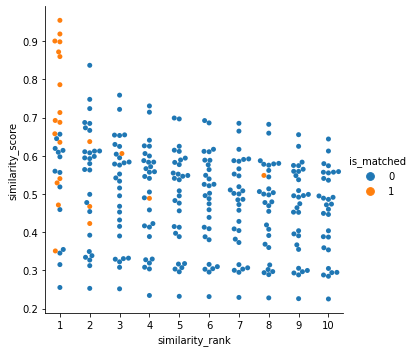

In [161]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.catplot(data = data_res, x = 'similarity_rank', y = 'similarity_score', hue = 'is_matched', kind = 'swarm')

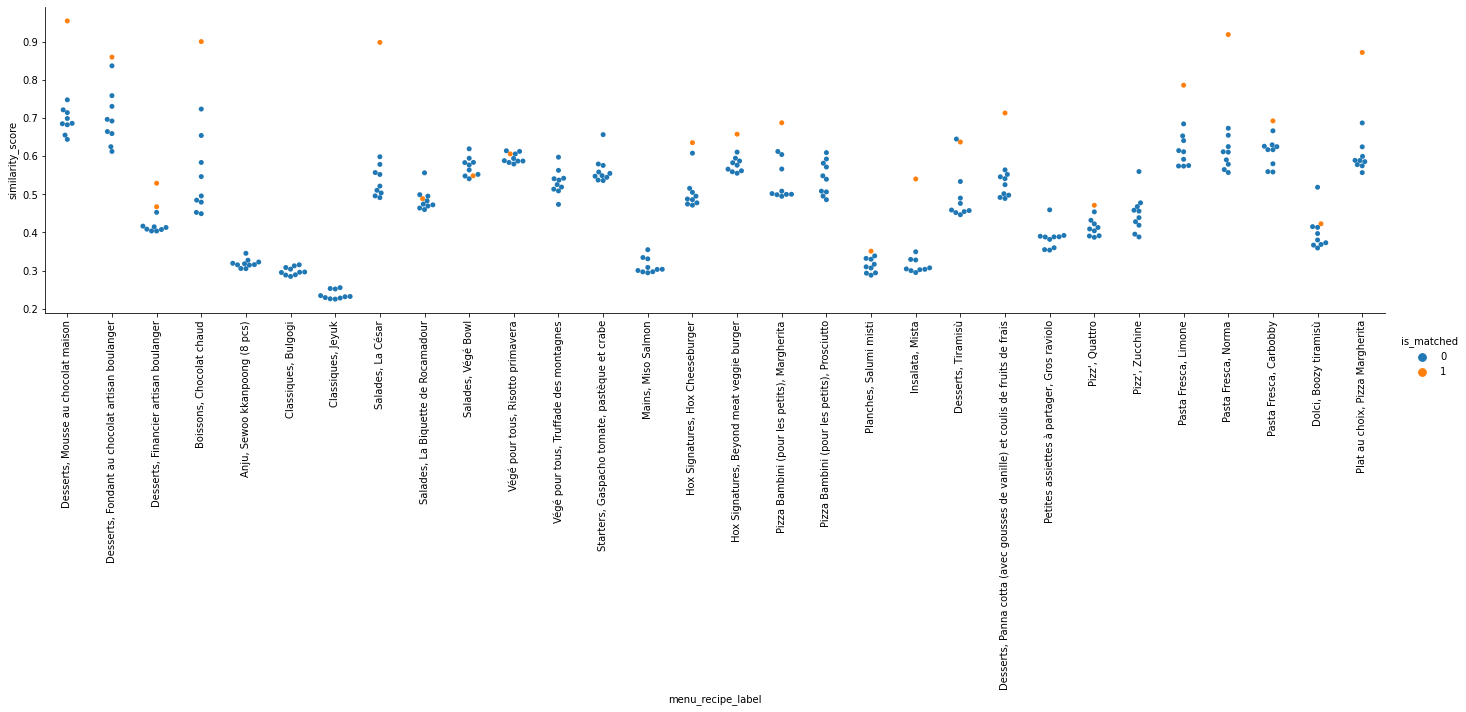

In [162]:
fig = sns.catplot(data = data_res, x = 'menu_recipe_label', y = 'similarity_score', hue = 'is_matched', kind = 'swarm', aspect = 4)
fig.set_xticklabels(rotation=90);

In [163]:
print("Number of good matchings among outputs with rank 1 :")
data_res[(data_res['similarity_rank']==1) & (data_res['is_matched']==1)].shape[0]

Number of good matchings among outputs with rank 1 :


16

In [164]:
print("Number of good matchings among outputs with rank between 2 and 10 :")
data_res[(data_res['similarity_rank']>1) & (data_res['similarity_rank']<=10) & (data_res['is_matched']==1)].shape[0]

Number of good matchings among outputs with rank between 2 and 10 :


6

**First conclusions when the matching is done by considering only the titles/subtitles of menu recipes :**
- There is no clear similarity score threshold above which the matching is good and below which the matching is bad
- For 16 menu recipes over 30, the first Bert guess (with rank 1)  is correct 
- For 6 other menu recipes, Bert finds the correct jow recipe among its first 10 guesses.
- Among the remaining 8 menu recipes (30-16-6), some of them (3) are clearly hard to match with only informations about the titles/subtitles of the menu recipes (no ingreidents) while some others (5) should be easier to match.

## Repeat the same study when the menu recipes are labeled by their titles, subtitles, and ingredients

In [165]:
print('Number of menu recipes which have ingredient labels :')
menu_data_withmatch[menu_data_withmatch['Menu Ingredients']!=''].shape[0]

Number of menu recipes which have ingredient labels :


23

Compared to the previous study, only 23 labels of menu recipes (over 30) are different.

In [166]:
# Find the closest 10 recipes of the (JOW) corpus for each query recipe based on cosine similarity
dict_res2 = {}

for index, row in menu_data_withmatch.iterrows():
    query = row['Menu all']           # Menu recipes are labeled by their titles, subtitles, and ingredients
    print("\n======================\n")
    t0 = time.time()
    query_embedding2 = model2.encode(query, convert_to_tensor=True)
    #print("Time lapse for one query embedding (s) = ", time.time()-t0, '\n')

    # We use util.semantic_search to perform cosine similarty + topk
    printmd("**Query : "+query+"**")
    printmd("**Closest JOW recipe (by hand) : "+row['Closest JOW recipe by hand']+"**")
    print("\nTop 10 most similar recipes in JOW:")
    t0 = time.time()
    hits = util.semantic_search(query_embedding2, jow_recipe_embeddings2, top_k=10)
    hits = hits[0]      #Get the hits for the first query
    
    for k, hit in enumerate(hits):
        jow_recipe = jow_recipes[hit['corpus_id']]
        print(k+1, ") ", jow_recipe, "(Score: {:.4f})".format(hit['score']))
        print('--> ingredients = ', list(jow_data[jow_data['recipe_name']==jow_recipe]['ingredients_with_quantity']))
    #print("\n Time lapse for finding the 5 closest recipes with semantic_search function (s) = ", time.time()-t0)

    # Store results in a dictionary
    for k, hit in enumerate(hits):
        jow_recipe = jow_recipes[hit['corpus_id']]
        menu_recipe_id = row['Menu Title and Subtitle']
       
        closest_jow = row['Closest JOW recipe by hand'] 
        if closest_jow[0]=='[':       # To detect lists because they have been converted to strings. Bad, Bad!
            matched_idx = 1 if jow_recipe in closest_jow else 0
        else:
            matched_idx = 1 if jow_recipe==closest_jow else 0

        # For each menu recipe (index) and hit (k), store menu_recipe_id, menu_recipe_label, jow_guess, similarity_rank, similary_score, is_matched
        dict_res2[str(index)+'_'+str(k)] = [menu_recipe_id, query, jow_recipe, k+1, hit['score'], matched_idx]          

**Query : Desserts, Mousse au chocolat maison**

**Closest JOW recipe (by hand) : Mousse au chocolat maison**


Top 10 most similar recipes in JOW:
1 )  Mousse au chocolat maison (Score: 0.9548)
--> ingredients =  [[['33 g', 'Chocolat à cuire'], ['1', 'Œuf']]]
2 )  Crème au chocolat (Score: 0.7479)
--> ingredients =  [[['140 g', 'Chocolat à cuire'], ['50 cl', 'Lait'], ['25 g', 'Sucre (en poudre)'], ['25 g', 'Maïzena']]]
3 )  Fondant au chocolat (Score: 0.7216)
--> ingredients =  [[['200 g', 'Chocolat à cuire'], ['125 g', 'Beurre demi-sel'], ['130 g', 'Sucre (en poudre)'], ['4', 'Œuf'], ['25 g']]]
4 )  Pâte à tartiner au chocolat (Score: 0.7143)
--> ingredients =  [[['50 g', 'Noisette'], ['50 g', 'Chocolat à cuire'], ['7 cl', 'Crème liquide'], ['8 g', 'Sucre (en poudre)'], ['5 ml', 'Huile de tournesol']]]
5 )  Tarte au chocolat (Score: 0.6990)
--> ingredients =  [[['100 g', 'Sucre (en poudre)'], ['200 g', 'Chocolat à cuire'], ['200 g', 'Farine de blé'], ['120 g', 'Beurre demi-sel'], ['20 cl', 'Crème liquide 30%']]]
6 )  Fondant choco marrons (Score: 0.6862)
--> ingredients =  [[['3', 'Œuf'], ['1

**Query : Desserts, Fondant au chocolat artisan boulanger**

**Closest JOW recipe (by hand) : Fondant au chocolat**


Top 10 most similar recipes in JOW:
1 )  Fondant au chocolat (Score: 0.8599)
--> ingredients =  [[['200 g', 'Chocolat à cuire'], ['125 g', 'Beurre demi-sel'], ['130 g', 'Sucre (en poudre)'], ['4', 'Œuf'], ['25 g']]]
2 )  Fondant-flan au chocolat & amande (Score: 0.8370)
--> ingredients =  [[['37 cl', 'Boisson amande'], ['95 g', 'Beurre demi-sel'], ['110 g', 'Sucre (en poudre)'], ['55 g', 'Farine de blé'], ['30 g', 'Cacao (en poudre)'], ['3', 'Œuf']]]
3 )  Fondant choco marrons (Score: 0.7589)
--> ingredients =  [[['3', 'Œuf'], ['150 g', 'Beurre demi-sel'], ['200 g', 'Chocolat à cuire'], ['500 g', 'Crème de marrons']]]
4 )  Fondant au chocolat à l'huile d'olive (Score: 0.7307)
--> ingredients =  [[['4', 'Œuf'], ['250 g', 'Chocolat à cuire'], ['175 g', 'Sucre glace'], ['10 cl', "Huile d'olive"], ['90 g', "Poudre d'amande"]]]
5 )  Mousse au chocolat maison (Score: 0.6966)
--> ingredients =  [[['33 g', 'Chocolat à cuire'], ['1', 'Œuf']]]
6 )  Pâte à tartiner au chocolat (Score: 0.6923)
--

**Query : Desserts, Financier artisan boulanger**

**Closest JOW recipe (by hand) : ['Financier cerises noires & pistache', 'Financier à la framboise']**


Top 10 most similar recipes in JOW:
1 )  Financier à la framboise (Score: 0.5292)
--> ingredients =  [[['60 g', 'Farine de blé'], ['4', 'Œuf'], ['150 g', 'Sucre glace'], ['100 g', 'Beurre'], ['90 g', "Poudre d'amande"], ['125 g', 'Framboises']]]
2 )  Financier cerises noires & pistache (Score: 0.4675)
--> ingredients =  [[['480 g', 'Cerises'], ['200 g', 'Beurre'], ['200 g', 'Sucre glace'], ['160 g', 'Farine de blé'], ['8', 'Œuf'], ['150 g', 'Pistaches (émondées)'], ['1', 'Vanille (gousse)']]]
3 )  Brioche perdue à la fraise (Score: 0.4528)
--> ingredients =  [[['80 g', 'Fraise'], ['30 g', 'Brioche (tranchée)'], ['15 cl', 'Lait'], ['2 càs', 'Sucre (en poudre)'], ['1', 'Œuf']]]
4 )  Fraisier facile (Score: 0.4167)
--> ingredients =  [[['750 g', 'Fraise'], ['4', 'Œuf'], ['125 g', 'Farine de blé'], ['200 g', 'Sucre (en poudre)'], ['1/2 sac.', 'Levure chimique'], ['60 g', 'Sucre glace'], ['40 cl', 'Crème liquide 30%'], ['250 g', 'Mascarpone']]]
5 )  Biscuits de Noël (Score: 0.4149)
--> ing

**Query : Boissons, Chocolat chaud**

**Closest JOW recipe (by hand) : Chocolat chaud**


Top 10 most similar recipes in JOW:
1 )  Chocolat chaud (Score: 0.9006)
--> ingredients =  [[['30 g', 'Chocolat à cuire'], ['25 cl', 'Lait'], ['1 càc', 'Cacao (en poudre)']]]
2 )  Chocolat chaud & marshmallows (Score: 0.7237)
--> ingredients =  [[['30 g', 'Chocolat à cuire'], ['25 cl', 'Lait'], ['1 càc', 'Cacao (en poudre)'], ['2', 'Guimauve']]]
3 )  Vin chaud (Score: 0.6543)
--> ingredients =  [[['15 cl', 'Vin rouge'], ['1/4', 'Orange'], ['1/2', 'Cannelle (en bâtons)'], ['5 g', 'Anis étoilé'], ['5 g', 'Gingembre (frais)'], ['1/2 càs', 'Sucre (en poudre)'], ['Facultatif', '1/4 sac.', 'Sucre vanillé']]]
4 )  Fondant au chocolat (Score: 0.5836)
--> ingredients =  [[['200 g', 'Chocolat à cuire'], ['125 g', 'Beurre demi-sel'], ['130 g', 'Sucre (en poudre)'], ['4', 'Œuf'], ['25 g']]]
5 )  Fondant choco marrons (Score: 0.5465)
--> ingredients =  [[['3', 'Œuf'], ['150 g', 'Beurre demi-sel'], ['200 g', 'Chocolat à cuire'], ['500 g', 'Crème de marrons']]]
6 )  Crème au chocolat (Score: 0.4958)

**Query : Anju, Sewoo kkanpoong (8 pcs), Crevettes frites dans une sauce aigre douce**

**Closest JOW recipe (by hand) : ['Crevettes teriyaki', 'Crevettes miel sésame']**


Top 10 most similar recipes in JOW:
1 )  Poêlée crevettes & légumes express (Score: 0.5231)
--> ingredients =  [[['100 g', 'Crevette (cuite)'], ['250 g', 'Poêlée de légumes (congelé)'], ['1 càs', 'Sauce soja sucrée'], ['Facultatif', '1 càc', 'Graines de sésame']]]
2 )  Wok de boeuf légumes croquants (Score: 0.5198)
--> ingredients =  [[['1', 'Bœuf (rumsteck)'], ['1', 'Carotte (frais)'], ['50 g', 'Petits pois (frais)'], ['1/2', 'Courgette'], ['Facultatif', '1/2 càc', 'Graines de sésame'], ['1 cm', 'Gingembre (frais)']]]
3 )  Spaghetti ail & crevette (Score: 0.5163)
--> ingredients =  [[['100 g', 'Pâtes (spaghetti)'], ['100 g', 'Crevette (cuite)'], ['1/2 gou.', 'Ail'], ['1 pinc.', "Piment d'Espelette"], ['1/10 bou.', 'Persil (frais)']]]
4 )  Pad Thaï crevette (Score: 0.5149)
--> ingredients =  [[['80 g', 'Nouilles de riz'], ['1/2 gou.', 'Ail'], ['2 càs', 'Sauce soja salée'], ['1/2 càs', 'Beurre de cacahuète'], ['1/4', 'Citron vert'], ['50 g', 'Pousses de soja'], ['50 g', 'Crevette (cuit

**Query : Classiques, Bulgogi, Bœuf émincé à la sauce soja, légumes, riz**

**Closest JOW recipe (by hand) : ['Wok de bœuf légumes croquants', 'Bœuf thaï', 'Bœuf sauté au chou', 'Aiguillettes de bœuf & légumes poêlés']**


Top 10 most similar recipes in JOW:
1 )  Wok de boeuf légumes croquants (Score: 0.7032)
--> ingredients =  [[['1', 'Bœuf (rumsteck)'], ['1', 'Carotte (frais)'], ['50 g', 'Petits pois (frais)'], ['1/2', 'Courgette'], ['Facultatif', '1/2 càc', 'Graines de sésame'], ['1 cm', 'Gingembre (frais)']]]
2 )  Boeuf aux oignons & riz (Score: 0.6934)
--> ingredients =  [[['1', 'Bœuf (bavette)'], ['70 g', 'Riz'], ['1/4', 'Oignon jaune'], ['3 càs', 'Sauce soja salée'], ['5 g', 'Maïzena'], ['1 càs', 'Miel (liquide)']]]
3 )  Boeuf & légumes sautés au pesto (Score: 0.6325)
--> ingredients =  [[['1', 'Bœuf (steak)'], ['1 càc', 'Sauce pesto'], ['100 g', 'Tomate cerise'], ['100 g', 'Courgette'], ['1/2', 'Poivron rouge'], ['1/4 gou.', 'Ail']]]
4 )  Boeuf haricots verts & purée (Score: 0.6252)
--> ingredients =  [[['100 g', 'Haricot vert (frais)'], ['250 g', 'Pomme de terre'], ['5 cl', 'Lait'], ['1', 'Bœuf (steak)'], ['20 g', 'Beurre']]]
5 )  Rôti de boeuf & haricots verts (Score: 0.6131)
--> ingredients =

**Query : Classiques, Jeyuk, Porc sauté, légumes, riz - soja ou piquant**

**Closest JOW recipe (by hand) : Porc au caramel**


Top 10 most similar recipes in JOW:
1 )  Nouilles de riz & porc sauté (Score: 0.7030)
--> ingredients =  [[['80 g', 'Nouilles de riz'], ['80 g', 'Chair à saucisse'], ['50 g', 'Concombre'], ['20 g', 'Cacahuète'], ['1 pinc.', "Piment d'Espelette"], ['2 càs', 'Sauce soja salée'], ['Facultatif', '1/10 bou.', 'Menthe (feuilles)']]]
2 )  Boeuf & légumes sautés au pesto (Score: 0.6328)
--> ingredients =  [[['1', 'Bœuf (steak)'], ['1 càc', 'Sauce pesto'], ['100 g', 'Tomate cerise'], ['100 g', 'Courgette'], ['1/2', 'Poivron rouge'], ['1/4 gou.', 'Ail']]]
3 )  Riz sauté & sauce pimentée (Score: 0.6109)
--> ingredients =  [[['90 g', 'Riz'], ['1/2 gou.', 'Ail'], ['1 càc', 'Sauce soja salée'], ['1 càc', 'Sauce piment (Sriracha)'], ['Facultatif', '1/10 bou.', 'Ciboulette'], ['1', 'Œuf']]]
4 )  Wok de boeuf légumes croquants (Score: 0.6064)
--> ingredients =  [[['1', 'Bœuf (rumsteck)'], ['1', 'Carotte (frais)'], ['50 g', 'Petits pois (frais)'], ['1/2', 'Courgette'], ['Facultatif', '1/2 càc', 'Graine

**Query : Salades, La César, poulet grillé, tomates cerise, œuf, romaine, parmesan**

**Closest JOW recipe (by hand) : Salade César**


Top 10 most similar recipes in JOW:
1 )  Salade poulet, roquette & feta (Score: 0.6401)
--> ingredients =  [[['1', 'Poulet (escalope)'], ['2 poignées', 'Salade (roquette)'], ['40 g', 'Feta'], ['1/2 càc', "Moutarde à l'ancienne"], ['1/2', 'Avocat'], ['Facultatif', '10 g', 'Pignons de pin']]]
2 )  Pasta poulet, ricotta & olives (Score: 0.6280)
--> ingredients =  [[['100 g', 'Pâtes (spaghetti)'], ['1 càs', 'Ricotta'], ['1', 'Poulet (escalope)'], ['20 g', 'Olives vertes'], ['1/4 gou.', 'Ail'], ['1 càs', 'Crème liquide']]]
3 )  Salade pâtes, tomates, mozzarella & chorizo (Score: 0.6021)
--> ingredients =  [[['80 g', 'Pâtes (Fusilli)'], ['100 g', 'Tomate cerise'], ['1/4', 'Concombre'], ['60 g', 'Mozzarella (mini)']]]
4 )  Dip feta & tomates cerises rôties (Score: 0.5943)
--> ingredients =  [[['50 g', 'Feta'], ['25 g', 'Yaourt Grec'], ['70 g', 'Tomate cerise'], ['1/10', 'Citron jaune'], ['1', 'Pain pita'], ['1/4 gou.', 'Ail']]]
5 )  Salade poulet, blé & pesto (Score: 0.5941)
--> ingredients 

**Query : Salades, La Biquette de Rocamadour, mielleuse et craquante**

**Closest JOW recipe (by hand) : ['Salade de chèvre chaud', 'Salade chèvre, miel & pignons', 'Salade aux croustillants de chèvre']**


Top 10 most similar recipes in JOW:
1 )  Salade de coquillettes méditerranéenne (Score: 0.5207)
--> ingredients =  [[['63 g', 'Coquillettes, courgettes, tomates, thym'], ['100 g', 'Tomate cerise'], ['30 g', 'Olive noire'], ['30 g', 'Chèvre frais']]]
2 )  Salade aux croustillants de chèvre (Score: 0.4577)
--> ingredients =  [[['3 poignées', 'Salade (Mélange)'], ['2', 'Feuille de brick'], ['80 g', 'Chèvre frais'], ['1 càs', 'Vinaigre balsamique'], ['1 càc'], ['1 càc']]]
3 )  Salade de betterave, chèvre & noix (Score: 0.4416)
--> ingredients =  [[['150 g', 'Betterave (cuite)'], ['50 g', 'Quinoa (cru)'], ['15 g', 'Noix'], ['30 g', 'Chèvre frais'], ['2 poignées', 'Salade (Mélange)'], ['2 càc', 'Vinaigre de cidre']]]
4 )  Salade de couscous & saumon grillé (Score: 0.4374)
--> ingredients =  [[['1', 'Saumon (frais)'], ['70 g', 'Semoule'], ['1/4', 'Concombre'], ['30 g', 'Feta'], ['1/10 bou.', 'Menthe (feuilles)'], ['Facultatif', '1/4', 'Citron jaune']]]
5 )  Salade campagnarde au chèvre (Scor

**Query : Salades, Végé Bowl, avocat, choux kale frit, concombre, edamame, radis, tomate et tofu mariné aux sésames**

**Closest JOW recipe (by hand) : Vegan poke bowl**


Top 10 most similar recipes in JOW:
1 )  Salade tomate, avocat & mozza (Score: 0.6044)
--> ingredients =  [[['2', 'Tomate'], ['1/2', 'Avocat'], ['60 g', 'Mozzarella di bufala'], ['1 càc', 'Vinaigre balsamique'], ['Facultatif', '1/10 bou.', 'Basilic (frais)'], ['1 càc', 'Miel (liquide)']]]
2 )  Salade betterave, avocat & chèvre frais (Score: 0.5985)
--> ingredients =  [[['150 g', 'Betterave (cuite)'], ['2 poignées', 'Salade (mâche)'], ['30 g', 'Chèvre frais'], ['1/2 càc', "Moutarde à l'ancienne"], ['1 càc'], ['1/2']]]
3 )  Steak de chou-fleur, houmous & olives (Score: 0.5939)
--> ingredients =  [[['1/2', 'Chou-fleur (frais)'], ['40 g', 'Houmous'], ['10 g', 'Olive noire'], ['20 g', 'Feta'], ['1/4 gou.'], ['Facultatif', '1/10 bou.']]]
4 )  Salade avocat, concombre & pois chiches (Score: 0.5889)
--> ingredients =  [[['70 g', 'Pois chiches (cuits)'], ['2 tran.', 'Jambon cru (Prosciutto)'], ['1 poignée', 'Salade (Mélange)'], ['1/2', 'Avocat'], ['1/4', 'Concombre'], ['100 g', 'Tomate cerise'

**Query : Végé pour tous, Risotto primavera, asperges, artichaut et petit pois**

**Closest JOW recipe (by hand) : Risotto aux asperges**


Top 10 most similar recipes in JOW:
1 )  Risotto aux asperges (Score: 0.7478)
--> ingredients =  [[['70 g', 'Riz (Arborio)'], ['100 g', 'Asperges vertes (fraîches)'], ['1/4', 'Bouillon de légumes (cube)'], ['1 càs', 'Parmesan (râpé)']]]
2 )  oeuf cocotte asperges petits pois (Score: 0.6651)
--> ingredients =  [[['1', 'Œuf'], ['1 càs', 'Fromage frais'], ['1 tran.', 'Pain de mie'], ['80 g', 'Petits pois (surgelés)'], ['80 g']]]
3 )  Risotto de coquillettes aux petits pois (Score: 0.6593)
--> ingredients =  [[['80 g', 'Pâtes (coquillettes)'], ['80 g', 'Petits pois (surgelés)'], ['50 g', 'Lardons'], ['1 càs', 'Crème fraîche épaisse']]]
4 )  Risotto crevettes & petits pois (Score: 0.6286)
--> ingredients =  [[['70 g', 'Riz (Arborio)'], ['70 g', 'Crevette (cuite)'], ['1/4', 'Bouillon de légumes (cube)'], ['1/4', 'Échalote']]]
5 )  Risotto courgette & prosciutto (Score: 0.6017)
--> ingredients =  [[['70 g', 'Riz (Arborio)'], ['1/2', 'Courgette'], ['1/4', 'Bouillon de légumes (cube)'], ['1 cà

**Query : Végé pour tous, Truffade des montagnes, salade**

**Closest JOW recipe (by hand) : Tartiflette express**


Top 10 most similar recipes in JOW:
1 )  Veggie lasagna (Score: 0.6128)
--> ingredients =  [[['50 g', 'Lasagnes (cru)'], ['150 g', 'Courgette'], ['150 g', 'Tomate (purée)'], ['80 g', 'Champignons de Paris (frais)'], ['1/2', 'Mozzarella (boule)']]]
2 )  Roasted veggies & hummus bowl (Score: 0.5817)
--> ingredients =  [[['200 g', 'Patate douce'], ['80 g', 'Pois chiches (cuits)'], ['60 g', 'Houmous'], ['1 poignée', 'Salade (mélange mâche-roquette)'], ['1 càc', 'Paprika'], ['Facultatif', '1/10 bou.', 'Coriandre (frais)']]]
3 )  Veggie Quesadillas (Score: 0.5801)
--> ingredients =  [[['2', 'Tortilla (blé)'], ['30 g', 'Cheddar (râpé)'], ['1', 'Avocat'], ['1/2', 'Oignon rouge'], ['1 càs', 'Crème fraîche épaisse'], ['50 g', 'Tomate (chair)'], ['Facultatif', '1/4 càc', 'Tabasco']]]
4 )  Salade campagnarde au chèvre (Score: 0.5558)
--> ingredients =  [[['50 g', 'Lardons'], ['1', 'Œuf'], ['1 tran.', 'Pain de campagne (tranché)'], ['30 g', 'Chèvre (bûche)']]]
5 )  Croziflette veggie (Score: 0.554

**Query : Starters, Gaspacho tomate, pastèque et crabe, Tomato, watermelon, coriander and chive oil**

**Closest JOW recipe (by hand) : Gaspacho repas crevette & avocat**


Top 10 most similar recipes in JOW:
1 )  Quiche thon, tomate & moutarde (Score: 0.6459)
--> ingredients =  [[['2 càs', 'Moutarde'], ['150 g', 'Thon (conserve)'], ['3', 'Œuf'], ['10 cl', 'Lait'], ['10 cl', 'Crème liquide'], ['300 g', 'Tomate'], ['1', 'Pâte brisée']]]
2 )  Salade semoule, tomate & thon (Score: 0.6281)
--> ingredients =  [[['50 g', 'Semoule'], ['100 g', 'Tomate cerise'], ['60 g', 'Poivron vert'], ['1/4', 'Citron jaune'], ['Facultatif', '1/10 bou.', 'Persil (frais)'], ['50 g', 'Thon (conserve)']]]
3 )  Bruschetta thon, tomate & oeuf (Score: 0.5912)
--> ingredients =  [[['1', 'Œuf'], ['2 tran.', 'Pain de campagne (tranché)'], ['70 g', 'Tomate'], ['70 g', 'Thon (conserve)'], ['10 g', 'Olive noire'], ['1 càs', 'Mayonnaise']]]
4 )  Salade de riz, maïs, thon & poivron (Score: 0.5881)
--> ingredients =  [[['50 g', 'Thon (conserve)'], ['50 g', 'Maïs (conserve)'], ['50 g', 'Riz'], ['1/2', 'Poivron (assortiment)'], ['40 g'], ['1 poignée']]]
5 )  Cake anchois, tomate & olives (Scor

**Query : Mains, Miso Salmon, Raw and cooked white asparagus, artichoke mousse**

**Closest JOW recipe (by hand) : Saumon & asperges rôtis**


Top 10 most similar recipes in JOW:
1 )  Saumon purée maison, poireaux & maïs (Score: 0.4705)
--> ingredients =  [[['200 g', 'Pomme de terre'], ['1/2', 'Poireau'], ['1', 'Saumon (frais)'], ['100 g', 'Maïs (conserve)']]]
2 )  Saumon mi-cuit & riz (Score: 0.4487)
--> ingredients =  [[['1', 'Saumon (frais)'], ['90 g', 'Riz']]]
3 )  Salade mâche, oeuf mollet & parmesan (Score: 0.4486)
--> ingredients =  [[['1', 'Œuf'], ['30 g', 'Parmesan (morceaux)'], ['100 g', 'Tomate cerise'], ['20 g', 'Pignons de pin'], ['1 càc'], ['2 poignées']]]
4 )  Papillote saumon pesto & légumes d'été (Score: 0.4480)
--> ingredients =  [[['1', 'Saumon (frais)'], ['120 g', 'Haricot vert (surgelé)'], ['100 g', 'Tomate cerise'], ['1 càs', 'Sauce pesto']]]
5 )  Quiche artichaut & parma (Score: 0.4309)
--> ingredients =  [[['1', 'Pâte brisée'], ['1', 'Mozzarella (boule)'], ['160 g', 'Artichauts marinés'], ['4 tran.', 'Jambon cru (Prosciutto)'], ['3', 'Œuf'], ['10 cl', 'Lait'], ['10 cl', 'Crème liquide']]]
6 )  Japanes

**Query : Hox Signatures, Hox Cheeseburger, Spanish beef, cheddar, caramelized onions, fries, salad**

**Closest JOW recipe (by hand) : Classic Cheeseburger**


Top 10 most similar recipes in JOW:
1 )  Grilled cheese brie & lard (Score: 0.6146)
--> ingredients =  [[['2 tran.', 'Pain de mie'], ['2 tran.', 'Lard (tranches)'], ['1 poignée', 'Salade (roquette)'], ['1 càc', "Confits d'oignons"], ['40 g', 'Brie'], ['1 càs', "Moutarde à l'ancienne"]]]
2 )  Taco shells au boeuf (Score: 0.5915)
--> ingredients =  [[['3', 'Taco kit'], ['100 g', 'Bœuf (haché)'], ['1/4', 'Oignon rouge'], ['1 càs', 'Crème fraîche épaisse'], ['10 g', 'Cheddar (râpé)'], ['1/4', 'Citron vert'], ['1 poignée', 'Salade (coeur de laitue)']]]
3 )  Cheeseburger veggie (Score: 0.5908)
--> ingredients =  [[['1', 'Pain burger'], ['1', 'Steak végétal'], ['1/2 poignée', 'Salade (coeur de laitue)'], ['1 càc', 'Yellow mustard'], ['1 càs', 'Ketchup'], ['1/8', 'Oignon rouge'], ['1 tran.', 'Cheddar (tranches)']]]
4 )  Steak haché sauce au roquefort & purée (Score: 0.5712)
--> ingredients =  [[['1', 'Bœuf (steak haché)'], ['250 g', 'Pomme de terre'], ['5 cl', 'Lait'], ['20 g', 'Beurre']]]
5 

**Query : Hox Signatures, Beyond meat veggie burger, Beyond Meat pattie, charcoal bun, avocado, fries, salad**

**Closest JOW recipe (by hand) : Cheeseburger veggie**


Top 10 most similar recipes in JOW:
1 )  Cheeseburger veggie (Score: 0.6407)
--> ingredients =  [[['1', 'Pain burger'], ['1', 'Steak végétal'], ['1/2 poignée', 'Salade (coeur de laitue)'], ['1 càc', 'Yellow mustard'], ['1 càs', 'Ketchup'], ['1/8', 'Oignon rouge'], ['1 tran.', 'Cheddar (tranches)']]]
2 )  Avocado toast veggie (Score: 0.6370)
--> ingredients =  [[['2 tran.', 'Pain de campagne (tranché)'], ['1', 'Avocat'], ['1/4', 'Grenade'], ['1/5 bou.', 'Menthe (feuilles)'], ['1/4', 'Citron jaune'], ['30 g', 'Feta']]]
3 )  Steak haché, purée & haricots verts (Score: 0.5925)
--> ingredients =  [[['1', 'Bœuf (steak haché)'], ['150 g', 'Pomme de terre'], ['1/2', 'Échalote'], ['100 g', 'Haricot vert (frais)'], ['3 cl'], ['20 g']]]
4 )  Roasted veggies & hummus bowl (Score: 0.5858)
--> ingredients =  [[['200 g', 'Patate douce'], ['80 g', 'Pois chiches (cuits)'], ['60 g', 'Houmous'], ['1 poignée', 'Salade (mélange mâche-roquette)'], ['1 càc', 'Paprika'], ['Facultatif', '1/10 bou.', 'Coriandr

**Query : Pizza Bambini (pour les petits), Margherita, sauce tomate, mozzarella**

**Closest JOW recipe (by hand) : Pizza Margherita**


Top 10 most similar recipes in JOW:
1 )  Pizza pesto, tomates & burrata (Score: 0.6853)
--> ingredients =  [[['1', 'Pâte à pizza'], ['60 g', 'Sauce pesto'], ['200 g', 'Tomate cerise'], ['1', 'Burrata'], ['Facultatif', '1/5 bou.', 'Basilic (frais)']]]
2 )  Pâte à pizza maison (Score: 0.6814)
--> ingredients =  [[['500 g', 'Farine de blé'], ['1 sac.', 'Levure boulangère (sèche)'], ['1 càc', 'Sucre (en poudre)'], ['2 càs', "Huile d'olive"]]]
3 )  Salade pâtes, tomates, mozzarella & chorizo (Score: 0.6679)
--> ingredients =  [[['80 g', 'Pâtes (Fusilli)'], ['100 g', 'Tomate cerise'], ['1/4', 'Concombre'], ['60 g', 'Mozzarella (mini)']]]
4 )  La tomate mozzarella (Score: 0.6678)
--> ingredients =  [[['350 g', 'Tomates multicolores'], ['90 g', 'Mozzarella di bufala'], ['1/10 bou.', 'Basilic (frais)']]]
5 )  Pizza Margherita (Score: 0.6376)
--> ingredients =  [[['1', 'Pâte à pizza'], ['60 g', 'Tomate (purée)'], ['1', 'Mozzarella (boule)'], ['1/5 bou.', 'Basilic (frais)']]]
6 )  Cake tomate mo

**Query : Pizza Bambini (pour les petits), Prosciutto, sauce tomate, mozzarella, jambon**

**Closest JOW recipe (by hand) : Pizza Parma**


Top 10 most similar recipes in JOW:
1 )  Pizza pesto, tomates & burrata (Score: 0.7190)
--> ingredients =  [[['1', 'Pâte à pizza'], ['60 g', 'Sauce pesto'], ['200 g', 'Tomate cerise'], ['1', 'Burrata'], ['Facultatif', '1/5 bou.', 'Basilic (frais)']]]
2 )  Quiche bacon tomate mozza (Score: 0.6981)
--> ingredients =  [[['8 tran.', 'Lard (tranches)'], ['1', 'Pâte brisée'], ['200 g', 'Tomate cerise'], ['3', 'Œuf'], ['10 cl', 'Lait'], ['10 cl', 'Crème liquide'], ['Facultatif', '2 pinc.', 'Thym (feuilles)'], ['1', 'Mozzarella (boule)']]]
3 )  Salade pâtes, tomates, mozzarella & chorizo (Score: 0.6687)
--> ingredients =  [[['80 g', 'Pâtes (Fusilli)'], ['100 g', 'Tomate cerise'], ['1/4', 'Concombre'], ['60 g', 'Mozzarella (mini)']]]
4 )  Tomate, mozzarella & anchois (Score: 0.6529)
--> ingredients =  [[['300 g', 'Tomates multicolores'], ['60 g', 'Mozzarella di bufala'], ['Facultatif', '1/10 bou.', 'Basilic (frais)'], ['20 g', 'Anchois']]]
5 )  Cake tomate mozza & pesto (Score: 0.6448)
--> ing

**Query : Planches, Salumi misti, assortiment de charcuteries italiennes**

**Closest JOW recipe (by hand) : Planche de charcuterie**


Top 10 most similar recipes in JOW:
1 )  Planche de charcuterie (Score: 0.6757)
--> ingredients =  [[['1 tran.', 'Jambon blanc'], ['1 tran.', 'Jambon cru'], ['2 tran.', 'Chorizo (tranches)'], ['2 tran.', 'Rosette'], ['20 g', 'Rillettes'], ['10 g', 'Cornichon']]]
2 )  Salade jambon cru, mozza & pistaches (Score: 0.5041)
--> ingredients =  [[['2 tran.', 'Jambon cru'], ['60 g', 'Mozzarella di bufala'], ['20 g', 'Pistaches (grillées)'], ['2 poignées', 'Salade (roquette)'], ['30 g', 'Olives vertes']]]
3 )  Saucisse & purée maison (Score: 0.5012)
--> ingredients =  [[['250 g', 'Pomme de terre'], ['5 cl', 'Lait'], ['20 g', 'Beurre'], ['1', 'Saucisse (fumée)'], ['1/2 càc']]]
4 )  Saucisse aux oignons (Score: 0.4992)
--> ingredients =  [[['250 g', 'Pomme de terre'], ['5 cl', 'Lait'], ['40 g', 'Beurre'], ['1', 'Saucisse (fumée)']]]
5 )  Saucisse épicée aux tomates (Score: 0.4870)
--> ingredients =  [[['100 g', 'Tomate (chair)'], ['1', 'Saucisse (fumée)'], ['1/4', 'Oignon jaune'], ['1/2 càc', 'R

**Query : Insalata, Mista, roquette, mozzarella di bufala, artichauts, jambon de parme, tomates cerises, parmesan**

**Closest JOW recipe (by hand) : ['Salade jambon cru, mozza & pistaches', 'Insalata di parma']**


Top 10 most similar recipes in JOW:
1 )  Tomate, mozzarella & anchois (Score: 0.7064)
--> ingredients =  [[['300 g', 'Tomates multicolores'], ['60 g', 'Mozzarella di bufala'], ['Facultatif', '1/10 bou.', 'Basilic (frais)'], ['20 g', 'Anchois']]]
2 )  Salade tomate, avocat & mozza (Score: 0.6875)
--> ingredients =  [[['2', 'Tomate'], ['1/2', 'Avocat'], ['60 g', 'Mozzarella di bufala'], ['1 càc', 'Vinaigre balsamique'], ['Facultatif', '1/10 bou.', 'Basilic (frais)'], ['1 càc', 'Miel (liquide)']]]
3 )  Salade pâtes, tomates, mozzarella & chorizo (Score: 0.6755)
--> ingredients =  [[['80 g', 'Pâtes (Fusilli)'], ['100 g', 'Tomate cerise'], ['1/4', 'Concombre'], ['60 g', 'Mozzarella (mini)']]]
4 )  Salade jambon cru, mozza & pistaches (Score: 0.6611)
--> ingredients =  [[['2 tran.', 'Jambon cru'], ['60 g', 'Mozzarella di bufala'], ['20 g', 'Pistaches (grillées)'], ['2 poignées', 'Salade (roquette)'], ['30 g', 'Olives vertes']]]
5 )  Quiche bacon tomate mozza (Score: 0.6545)
--> ingredients 

**Query : Desserts, Tiramisù**

**Closest JOW recipe (by hand) : Tiramisu**


Top 10 most similar recipes in JOW:
1 )  Roulé façon tiramisu (Score: 0.6451)
--> ingredients =  [[['4', 'Œuf'], ['125 g', 'Farine de blé'], ['125 g', 'Sucre (en poudre)'], ['1 càc', 'Levure chimique'], ['35 g'], ['25 cl'], ['120 g'], ['15 g']]]
2 )  Tiramisu (Score: 0.6372)
--> ingredients =  [[['100 g', 'Sucre (en poudre)'], ['Facultatif', '1 sac.', 'Sucre vanillé'], ['3', 'Œuf'], ['2 càs', 'Cacao (en poudre)'], ['250 g', 'Mascarpone'], ['20', 'Biscuit cuiller'], ['2 càc', 'Café'], ['Facultatif', '1 càs', 'Amaretto']]]
3 )  Petite crème au caramel (Score: 0.5337)
--> ingredients =  [[['10 cl', 'Lait'], ['1', 'Œuf'], ['30 g', 'Sucre (en poudre)'], ['1 càs', 'Crème liquide'], ['1 noisette', 'Beurre'], ['1/4', 'Vanille (gousse)']]]
4 )  Gâteau au skyr, fraises & chocolat (Score: 0.4901)
--> ingredients =  [[['100 g', 'Farine de blé'], ['50 g', "Poudre d'amande"], ['2', 'Œuf'], ['250 g', 'Fraise'], ['1 sac.', 'Levure chimique'], ['150 g', 'Skyr'], ['1', 'Citron jaune'], ['50 g', 'Sucre 

**Query : Desserts, Panna cotta (avec gousses de vanille) et coulis de fruits de frais**

**Closest JOW recipe (by hand) : Panna cotta à la fraise**


Top 10 most similar recipes in JOW:
1 )  Panna cotta à la fraise (Score: 0.7133)
--> ingredients =  [[['80 g', 'Fraise'], ['10 cl', 'Crème liquide'], ['2 càs', 'Sucre (en poudre)'], ['1/4', 'Vanille (gousse)'], ['1/2', 'Gélatine']]]
2 )  Banane caramélisée miel & glace vanille (Score: 0.5642)
--> ingredients =  [[['1', 'Banane'], ['1 càs', 'Miel (liquide)'], ['15 g', 'Noix'], ['40 g', 'Crème glacée Vanille'], ['10 g']]]
3 )  Nectarine rôtie & glace vanille (Score: 0.5524)
--> ingredients =  [[['1 boule', 'Crème glacée Vanille'], ['1', 'Nectarine'], ['15 g', 'Amandes (effilées)'], ['20 g', 'Beurre'], ['1 càc', 'Sucre de canne']]]
4 )  Fraises & chantilly maison (Score: 0.5460)
--> ingredients =  [[['100 g', 'Fraise'], ['1 cl', 'Crème liquide 30%'], ['1/2 càc', 'Sucre (en poudre)'], ['Facultatif', '1/5', 'Vanille (gousse)']]]
5 )  Roulé aux fraises & mascarpone (Score: 0.5411)
--> ingredients =  [[['250 g', 'Fraise'], ['4', 'Œuf'], ['125 g', 'Farine de blé'], ['125 g', 'Sucre (en poudre

**Query : Petites assiettes à partager, Gros raviolo, aux champis d'une ferme urbaine du 18è siècle**

**Closest JOW recipe (by hand) : ['Raviolis à la crème de champignons', 'Raviolis aux champignons, chèvre frais & noisette']**


Top 10 most similar recipes in JOW:
1 )  Salade campagnarde (Score: 0.5030)
--> ingredients =  [[['3', 'Œuf de caille'], ['150 g', 'Pomme de terre (petites)'], ['2 poignées', 'Salade (mâche)'], ['20 g', 'Chèvre frais'], ['2 tran.', 'Bacon']]]
2 )  Salade de ravioli ricotta et épinards (Score: 0.4675)
--> ingredients =  [[['125 g', 'Ravioli (ricotta-épinards)'], ['2 poignées', 'Salade (Mélange)'], ['15 g', 'Comté'], ['10 g', 'Pignons de pin'], ['1 càc', 'Vinaigre balsamique']]]
3 )  Salade campagnarde au chèvre (Score: 0.4522)
--> ingredients =  [[['50 g', 'Lardons'], ['1', 'Œuf'], ['1 tran.', 'Pain de campagne (tranché)'], ['30 g', 'Chèvre (bûche)']]]
4 )  Raviolis aux champignons, chèvre frais & noisette (Score: 0.4403)
--> ingredients =  [[['125 g', 'Ravioli (aux champignons)'], ['50 g', 'Chèvre frais'], ['20 g', 'Noisette'], ['40 g', 'Champignons bruns']]]
5 )  Gnocchis pique all'arrabiata (Score: 0.4324)
--> ingredients =  [[['150 g', 'Gnocchi'], ['30 g', 'Chorizo (tranches)'], ['

**Query : Pizz', Quattro, Mozza fior di latte et scamorza IDF, gorgonzola, parmigiano, basilico**

**Closest JOW recipe (by hand) : Pizza maison 3 fromages**


Top 10 most similar recipes in JOW:
1 )  Salade de pâtes, pesto, mozza (Score: 0.6476)
--> ingredients =  [[['100 g', 'Pâtes (Pipe rigate)'], ['40 g', 'Tomate séchée'], ['1 càs', 'Sauce pesto'], ['1 càs', 'Vinaigre balsamique'], ['60 g', 'Mozzarella (mini)']]]
2 )  Tian à la mozzarella (Score: 0.6272)
--> ingredients =  [[['1/2', 'Courgette'], ['1', 'Tomate'], ['1/2 gou.', 'Ail'], ['1/2', 'Aubergine'], ['1 pinc.', 'Thym (feuilles)'], ['1/4', 'Oignon jaune'], ['80 g', 'Mozzarella (à cuire)']]]
3 )  Quiche ratatouille & mozzarella (Score: 0.6228)
--> ingredients =  [[['1', 'Pâte brisée'], ['3', 'Œuf'], ['10 cl', 'Lait'], ['10 cl', 'Crème liquide'], ['1', 'Mozzarella (boule)'], ['300 g', 'Ratatouille'], ['1 càc', 'Herbes de provence']]]
4 )  Salade pâtes, tomates, mozzarella & chorizo (Score: 0.6074)
--> ingredients =  [[['80 g', 'Pâtes (Fusilli)'], ['100 g', 'Tomate cerise'], ['1/4', 'Concombre'], ['60 g', 'Mozzarella (mini)']]]
5 )  Gratin de gnocchis à la mozzarella (Score: 0.5975)
--

**Query : Pizz', Zucchine, Crème de courgette,  mozza fior di latte IDF, provolone del monaco, chips de courgette, basilico**

**Closest JOW recipe (by hand) : Pizza verde à la courgette**


Top 10 most similar recipes in JOW:
1 )  Frittata courgette, jambon & mozza (Score: 0.6846)
--> ingredients =  [[['8', 'Œuf'], ['125 g', 'Mozzarella (boule)'], ['1', 'Courgette'], ['2 tran.', 'Jambon blanc']]]
2 )  Pizza verde à la courgette (Score: 0.6623)
--> ingredients =  [[['1', 'Pâte à pizza'], ['3 càs', 'Sauce pesto'], ['1', 'Courgette'], ['1', 'Mozzarella (boule)'], ['2 poignées', 'Epinard (frais)']]]
3 )  Salade courgette, chèvre frais & prosciutto (Score: 0.6587)
--> ingredients =  [[['2 poignées', 'Salade (roquette)'], ['1/2', 'Courgette'], ['40 g', 'Chèvre frais'], ['2 tran.', 'Jambon cru (Prosciutto)'], ['15 g']]]
4 )  Tarte fine ricotta, courgette & coppa (Score: 0.6493)
--> ingredients =  [[['1', 'Pâte feuilletée'], ['2', 'Courgette'], ['120 g', 'Ricotta'], ['6 tran.', 'Coppa'], ['3 poignées', 'Salade (roquette)'], ['1 càc', 'Thym (feuilles)']]]
5 )  Pâtes aux courgettes & chèvre frais (Score: 0.6450)
--> ingredients =  [[['100 g', 'Pâtes (Tagliatelles)'], ['200 g', 'Co

**Query : Pasta Fresca, Limone, Trenette, sauce au citron, piment (ou non si vous aimez pas ), basilico**

**Closest JOW recipe (by hand) : Pasta al limone**


Top 10 most similar recipes in JOW:
1 )  Pâtes thon, citron & ricotta (Score: 0.6324)
--> ingredients =  [[['100 g', 'Pâtes (Linguine)'], ['1 càs', 'Ricotta'], ['50 g', 'Thon au citron'], ['1/4', 'Citron jaune'], ['1 càs', 'Crème liquide']]]
2 )  Salade pâtes, tomates, mozzarella & chorizo (Score: 0.6029)
--> ingredients =  [[['80 g', 'Pâtes (Fusilli)'], ['100 g', 'Tomate cerise'], ['1/4', 'Concombre'], ['60 g', 'Mozzarella (mini)']]]
3 )  Salade de pâtes, pesto, mozza (Score: 0.5785)
--> ingredients =  [[['100 g', 'Pâtes (Pipe rigate)'], ['40 g', 'Tomate séchée'], ['1 càs', 'Sauce pesto'], ['1 càs', 'Vinaigre balsamique'], ['60 g', 'Mozzarella (mini)']]]
4 )  Pasta pistacchio e olive (Score: 0.5726)
--> ingredients =  [[['15 g', 'Pistaches (grillées)'], ['100 g', 'Pâtes (Pipe rigate)'], ['15 g', 'Olive noire'], ['1/4 gou.', 'Ail']]]
5 )  Pasta ricotta, petits pois & menthe (Score: 0.5617)
--> ingredients =  [[['1 gou.', 'Ail'], ['1/4', 'Courgette'], ['100 g', 'Pâtes (coquillettes)'],

**Query : Pasta Fresca, Norma, Tagliatelle, sauce tomate et aubergines frites, ricotta salée fumée**

**Closest JOW recipe (by hand) : Pasta alla Norma**


Top 10 most similar recipes in JOW:
1 )  Salade pâtes, tomates, mozzarella & chorizo (Score: 0.7081)
--> ingredients =  [[['80 g', 'Pâtes (Fusilli)'], ['100 g', 'Tomate cerise'], ['1/4', 'Concombre'], ['60 g', 'Mozzarella (mini)']]]
2 )  Pâtes aux aubergines & parmesan (Score: 0.6845)
--> ingredients =  [[['100 g', 'Pâtes (Linguine)'], ['1/4', 'Aubergine'], ['2 tran.', 'Jambon cru'], ['20 g', 'Parmesan (morceaux)']]]
3 )  Pasta alla Norma (Score: 0.6682)
--> ingredients =  [[['100 g', 'Pâtes (Rigatoni)'], ['100 g', 'Tomate (chair)'], ['1/2 gou.', 'Ail'], ['1/2', 'Aubergine'], ['30 g', 'Ricotta'], ['Facultatif', '1/10 bou.', 'Basilic (frais)']]]
4 )  Feta rôtie, gnocchis & tomates cerises (Score: 0.6562)
--> ingredients =  [[['1/2', 'Feta'], ['100 g', 'Tomate cerise'], ['100 g', 'Gnocchi'], ['1/4', 'Oignon rouge'], ['1 pinc.', 'Herbes de provence']]]
5 )  Pasta au pesto maison (Score: 0.6410)
--> ingredients =  [[['100 g', 'Pâtes (trofie)'], ['1/5 bou.', 'Basilic (frais)'], ['2 cl', "H

**Query : Pasta Fresca, Carbobby, Spaghetti, crème d'œuf bio et de pecorino, guanciale, poivre**

**Closest JOW recipe (by hand) : Pasta alla carbonara**


Top 10 most similar recipes in JOW:
1 )  Pasta pistacchio e olive (Score: 0.6258)
--> ingredients =  [[['15 g', 'Pistaches (grillées)'], ['100 g', 'Pâtes (Pipe rigate)'], ['15 g', 'Olive noire'], ['1/4 gou.', 'Ail']]]
2 )  Creamy Eggs & Prosciutto pasta (Score: 0.6152)
--> ingredients =  [[['100 g', 'Pâtes (Pappardelle)'], ['2 tran.', 'Jambon cru (Prosciutto)'], ['5 cl', 'Crème liquide'], ['1/2 càs', 'Ricotta'], ['1', 'Œuf'], ['Facultatif', '1/10 bou.', 'Basilic (frais)']]]
3 )  Pasta carbo poireaux (Score: 0.6042)
--> ingredients =  [[['100 g', 'Pâtes (Linguine)'], ['1/2', 'Poireau'], ['15 g', 'Parmesan (râpé)'], ['1/2', 'Œuf'], ['50 g']]]
4 )  Creamy green pasta (Score: 0.6016)
--> ingredients =  [[['100 g', 'Pâtes (Pipe rigate)'], ['80 g', 'Petits pois (surgelés)'], ['80 g', 'Courgette'], ['1 càs', 'Crème fraîche épaisse'], ['1/4', 'Citron jaune'], ['1 pinc.', "Piment d'Espelette"]]]
5 )  Salade de pâtes, pesto, mozza (Score: 0.5965)
--> ingredients =  [[['100 g', 'Pâtes (Pipe riga

**Query : Dolci, Boozy tiramisù, Tiramisù classique + Amaretto (liqueur d'amande)**

**Closest JOW recipe (by hand) : Tiramisu**


Top 10 most similar recipes in JOW:
1 )  Roulé façon tiramisu (Score: 0.5445)
--> ingredients =  [[['4', 'Œuf'], ['125 g', 'Farine de blé'], ['125 g', 'Sucre (en poudre)'], ['1 càc', 'Levure chimique'], ['35 g'], ['25 cl'], ['120 g'], ['15 g']]]
2 )  Fondant-flan au chocolat & amande (Score: 0.4889)
--> ingredients =  [[['37 cl', 'Boisson amande'], ['95 g', 'Beurre demi-sel'], ['110 g', 'Sucre (en poudre)'], ['55 g', 'Farine de blé'], ['30 g', 'Cacao (en poudre)'], ['3', 'Œuf']]]
3 )  Amandes caramélisées (Score: 0.4803)
--> ingredients =  [[['20 g', 'Sucre (en poudre)'], ['30 g', 'Amandes (entières)']]]
4 )  Petite crème au caramel (Score: 0.4754)
--> ingredients =  [[['10 cl', 'Lait'], ['1', 'Œuf'], ['30 g', 'Sucre (en poudre)'], ['1 càs', 'Crème liquide'], ['1 noisette', 'Beurre'], ['1/4', 'Vanille (gousse)']]]
5 )  Galette chocolat & amandes express (Score: 0.4730)
--> ingredients =  [[['1', 'Galette bretonne'], ['20 g', 'Chocolat à cuire'], ['10 g', 'Beurre'], ['15 g', 'Amandes (

**Query : Plat au choix, Pizza Margherita**

**Closest JOW recipe (by hand) : Pizza Margherita**


Top 10 most similar recipes in JOW:
1 )  Pizza Margherita (Score: 0.8721)
--> ingredients =  [[['1', 'Pâte à pizza'], ['60 g', 'Tomate (purée)'], ['1', 'Mozzarella (boule)'], ['1/5 bou.', 'Basilic (frais)']]]
2 )  Pâte à pizza maison (Score: 0.6873)
--> ingredients =  [[['500 g', 'Farine de blé'], ['1 sac.', 'Levure boulangère (sèche)'], ['1 càc', 'Sucre (en poudre)'], ['2 càs', "Huile d'olive"]]]
3 )  Pizza maison 3 fromages (Score: 0.6246)
--> ingredients =  [[['1', 'Pâte à pizza'], ['50 g', 'Roquefort'], ['50 g', 'Tomate (concentré)'], ['1', 'Mozzarella (boule)'], ['100 g', 'Chèvre frais']]]
4 )  Pizza bianca (Score: 0.5996)
--> ingredients =  [[['1', 'Pâte à pizza'], ['140 g', 'Ricotta'], ['1', 'Mozzarella (boule)'], ['Facultatif', '1/5 bou.', 'Basilic (frais)']]]
5 )  Pizza printanière (Score: 0.5892)
--> ingredients =  [[['1', 'Pâte à pizza'], ['140 g', 'Petits pois (surgelés)'], ['4 tran.', 'Jambon cru (Prosciutto)'], ['1', 'Œuf'], ['1 càs', 'Sauce pesto'], ['1', 'Mozzarella (b

Below, remember that the column 'menu_recipe_id' corresponds only to the title+subtitle of a menu recipe while the column 'menu_recipe_label' corresponds to the full label of the menu recipe used in NLP, here title+subtitle+ingredients (if any).

In [167]:
data_res2 = pd.DataFrame.from_dict(dict_res2, orient = 'index', \
                                  columns = ['menu_recipe_id', 'menu_recipe_label', 'jow_guess', 'similarity_rank', 'similarity_score', 'is_matched'])\
                                  .reset_index(drop = True)

data_res2.head()

,menu_recipe_id,menu_recipe_label,jow_guess,similarity_rank,similarity_score,is_matched
0,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Mousse au chocolat maison,1,0.954754,1
1,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Crème au chocolat,2,0.747854,0
2,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Fondant au chocolat,3,0.721633,0
3,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Pâte à tartiner au chocolat,4,0.714327,0
4,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Tarte au chocolat,5,0.699011,0


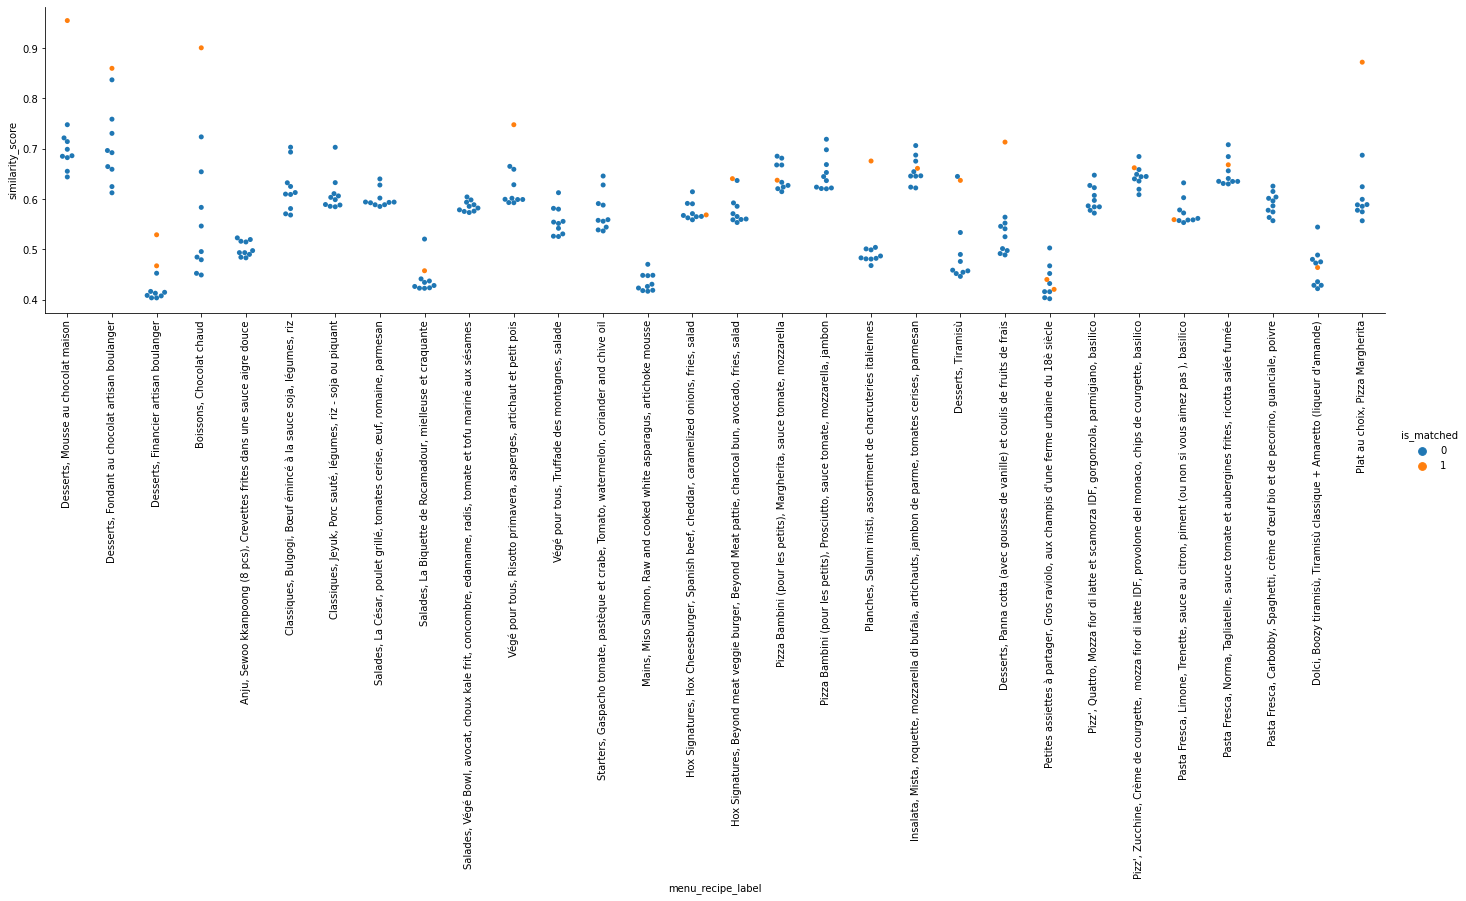

In [168]:
fig = sns.catplot(data = data_res2, x = 'menu_recipe_label', y = 'similarity_score', hue = 'is_matched', kind = 'swarm', aspect = 4)
fig.set_xticklabels(rotation=90);

Plot all data together. Add a column 'menu_labels' to tell which labels have been used in 'menu_recipe_labels'.

In [169]:
data_res['menu_labels'] = 'Titles and subtitles'
data_res2['menu_labels'] = 'All'
data_res_tot = pd.concat([data_res, data_res2], axis = 0)
data_res_tot

,menu_recipe_id,menu_recipe_label,jow_guess,similarity_rank,similarity_score,is_matched,menu_labels
0,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Mousse au chocolat maison,1,0.954754,1,Titles and subtitles
1,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Crème au chocolat,2,0.747854,0,Titles and subtitles
2,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Fondant au chocolat,3,0.721633,0,Titles and subtitles
3,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Pâte à tartiner au chocolat,4,0.714327,0,Titles and subtitles
4,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Tarte au chocolat,5,0.699011,0,Titles and subtitles
...,...,...,...,...,...,...,...
295,"Plat au choix, Pizza Margherita","Plat au choix, Pizza Margherita",Pizza puttanesca,6,0.588711,0,All
296,"Plat au choix, Pizza Margherita","Plat au choix, Pizza Margherita",Pizza au chorizo,7,0.585741,0,All
297,"Plat au choix, Pizza Margherita","Plat au choix, Pizza Margherita",Pizza champignons & ricotta,8,0.577915,0,All
298,"Plat au choix, Pizza Margherita","Plat au choix, Pizza Margherita",Pizza maison chèvre miel,9,0.574843,0,All


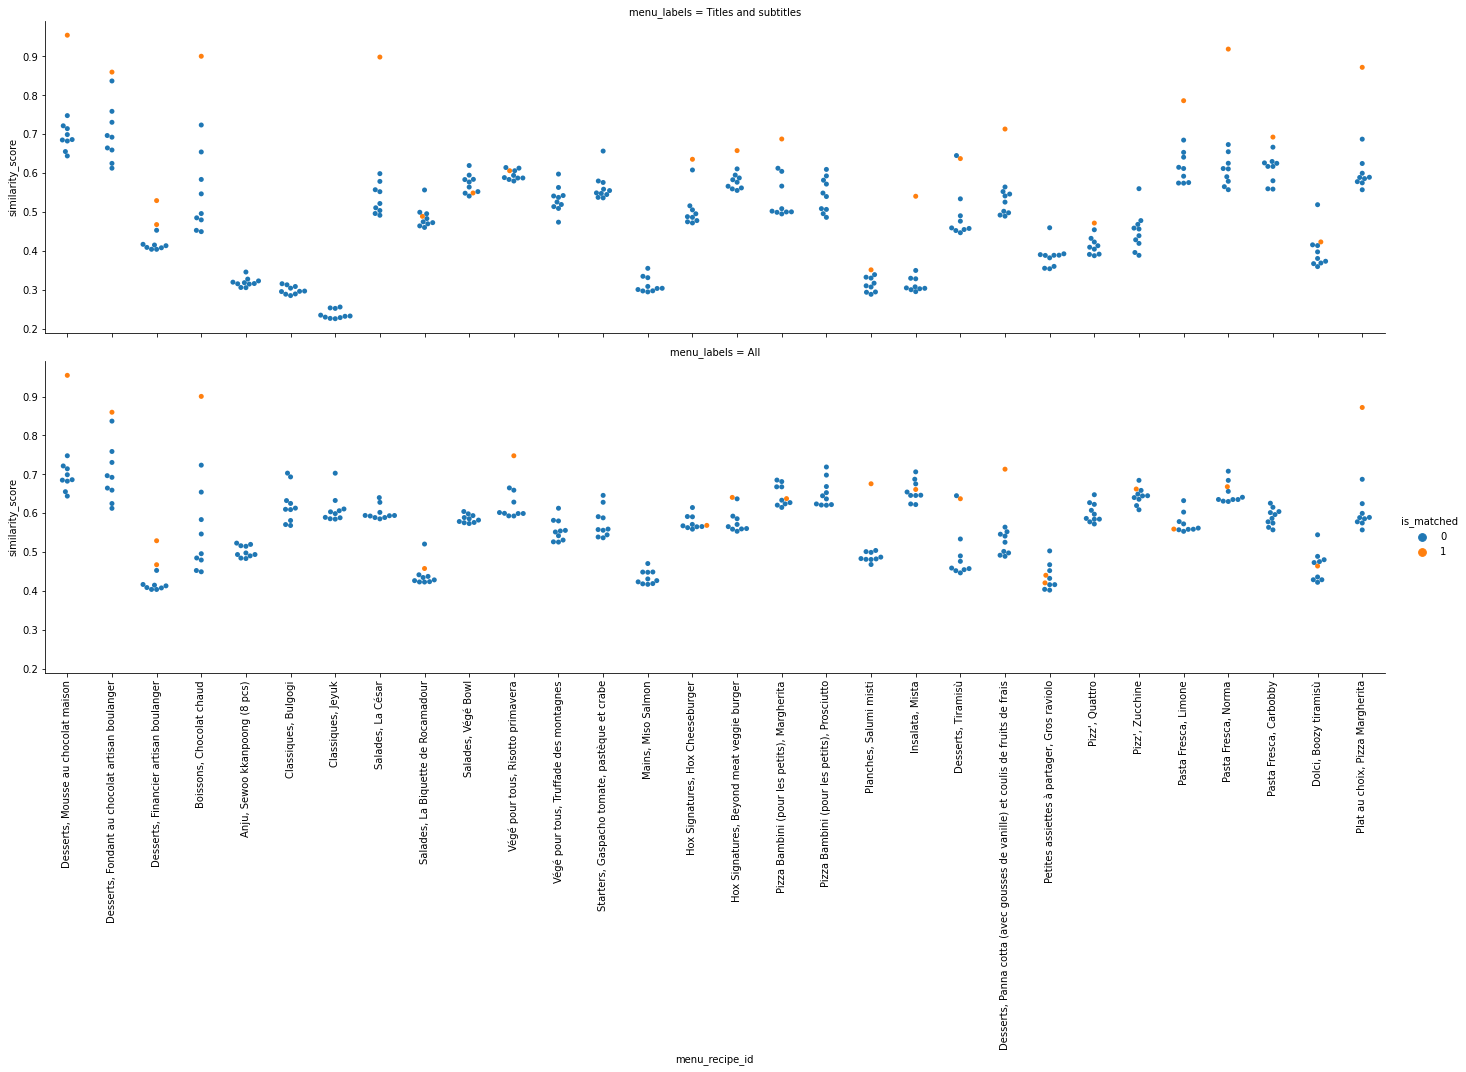

In [170]:
fig = sns.catplot(data = data_res_tot, x = 'menu_recipe_id', y = 'similarity_score', row = 'menu_labels', \
                  hue = 'is_matched', kind = 'swarm', aspect = 4)
fig.set_xticklabels(rotation=90);

In [171]:
print("Number of good matchings among outputs with rank 1 :")
data_res2[(data_res2['similarity_rank']==1) & (data_res2['is_matched']==1)].shape[0]

Number of good matchings among outputs with rank 1 :


9

In [172]:
print("Number of good matchings among outputs with rank between 2 and 10 :")
data_res2[(data_res2['similarity_rank']>1) & (data_res2['similarity_rank']<=10) & (data_res2['is_matched']==1)].shape[0]

Number of good matchings among outputs with rank between 2 and 10 :


12

When ingredients are given immediately as parts of menu recipes labels, results are globally worse:
- only 9 menu recipes over 30 are now well matched by the first Bert guess (rank 1). Remember that 7 labels of menu recipes are unchanged with respect to the previous study. 

However, for some menu recipes, results are better:
- 'risotto primavera' is matched at the first try (rank 1)
- 'La biquette de Rocamadour' is matched at the second try (rank 2)
- 'Gros Raviolo' and 'Pizz Zuchini' are matched among the first ten Bert outputs (while it was not the case in the previous study)

Note that here and above, only JOW recipe names are given (not Jow ingredients)

## Let's now add JOW ingredients in the NLP process

**Let's start by preparing jow ingredients**  

Let's add a column for ingredients only (no quantity, informations in parenthesis are removed)

In [173]:
# Known from previous notebook '[Genevieve] ingredients_scores__process.ipynb'
meaningless_jow_ingredients = ['1/10 bou.', '1/5 bou.', '1/50 bou.', '6 pinc.', '1 càc', '1/4', '3 pinc.', '2 càs', \
                               '1 cm', '1/20 bou.', '1 càs', '1/2 càc', 'Papier cuisson', 'Pics à brochette']

def extract_ingredients(row):
    ingredients = []
    for x in row:
        if len(x)>1:         
            ingredient = x[-1]    # the ingredient is the last element of the list 'row'  
            if ingredient not in meaningless_jow_ingredients:   # keep only meaningfull ingredients
                ingredients.append(ingredient) 

    ingredients = [re.sub("[\(\[].*?[\)\]]", "", ingredient) for ingredient in ingredients]  #remove informations in parenthesis
    # remove blank at the end of the string that remained when parenthesis have been removed
    ingredients = [ing[:-1] if ing[-1]==" " else ing for ing in ingredients]   

    return ingredients

jow_data['ingredients'] = jow_data['ingredients_with_quantity'].apply(extract_ingredients)
jow_data.head()

,cuisson,ingredients_with_quantity,recipe_name,ingredients
Yakitori bœuf fromage,10 minutes,"[[80 g, Bœuf (carpaccio)], [100 g, Emmental], [1 càs, Sauce Teriyaki], [70 g, Riz], [6, Pics à brochette]]",Yakitori boeuf fromage,"[Bœuf, Emmental, Sauce Teriyaki, Riz]"
Gnocchis Epinards Gorgonzola,5 minutes,"[[150 g, Gnocchi], [100 g, Epinard (frais)], [30 g, Gorgonzola], [5 cl, Crème liquide]]",Gnocchis Epinards Gorgonzola,"[Gnocchi, Epinard, Gorgonzola, Crème liquide]"
Dahl de lentilles corail,plat froid,"[[50 g, Lentilles corail], [80 g, Tomate (chair)], [5 cl, Lait de coco], [1/2 gou., Ail]]",Dahl de lentilles corail,"[Lentilles corail, Tomate, Lait de coco, Ail]"
Veggie lasagna,50 minutes,"[[50 g, Lasagnes (cru)], [150 g, Courgette], [150 g, Tomate (purée)], [80 g, Champignons de Paris (frais)], [1/2, Mozzarella (boule)]]",Veggie lasagna,"[Lasagnes, Courgette, Tomate, Champignons de Paris, Mozzarella]"
Pasta alla carbonara,9 minutes,"[[100 g, Pâtes (spaghetti)], [3 tran., Pancetta], [1, Œuf], [40 g, Parmesan (morceaux)]]",Pasta alla carbonara,"[Pâtes, Pancetta, Œuf, Parmesan]"


Add the columns 'recipe_name' and 'name_with_ingredients'

In [174]:
#jow_data['recipe_name'] = jow_data.index
#jow_data['recipe_name'] = jow_data['recipe_name'].apply(lambda s: remove_ligatures(str(s)))
jow_data['name_with_ingredients'] = jow_data.apply(lambda row: row['recipe_name'] + ", " + ', '.join(row['ingredients']), axis = 1)
jow_data.head(2)

,cuisson,ingredients_with_quantity,recipe_name,ingredients,name_with_ingredients
Yakitori bœuf fromage,10 minutes,"[[80 g, Bœuf (carpaccio)], [100 g, Emmental], [1 càs, Sauce Teriyaki], [70 g, Riz], [6, Pics à brochette]]",Yakitori boeuf fromage,"[Bœuf, Emmental, Sauce Teriyaki, Riz]","Yakitori boeuf fromage, Bœuf, Emmental, Sauce Teriyaki, Riz"
Gnocchis Epinards Gorgonzola,5 minutes,"[[150 g, Gnocchi], [100 g, Epinard (frais)], [30 g, Gorgonzola], [5 cl, Crème liquide]]",Gnocchis Epinards Gorgonzola,"[Gnocchi, Epinard, Gorgonzola, Crème liquide]","Gnocchis Epinards Gorgonzola, Gnocchi, Epinard, Gorgonzola, Crème liquide"


**Let's now run the NLP model by considering the full label of menu recipes (title+subtitle+ingredients if any) and the jow recipes' names+ingredients (no quantity)**

We need first to compute the embedding of JOW recipes labeled with 'name_with_ingredients'.

In [175]:
t0 = time.time()
jow_fullname_recipes = list(jow_data['name_with_ingredients'].values)
jow_fullname_embeddings2 = model2.encode(jow_fullname_recipes, convert_to_tensor=True)
print("Time lapse for JOW embedding (s) = ", time.time()-t0)

Time lapse for JOW embedding (s) =  10.410379648208618


We want to match jow recipes with menu recipes labeled by the column 'Menu all' (title+subtitle+ingredients if any)

In [176]:
menu_data_withmatch.head(2)

,Unnamed: 0,Menu filename,Menu Title,Menu Subtitle,Menu Ingredients,Closest JOW recipe by hand,Menu Title and Subtitle,Menu all
0,7,burgart_205074_c70.jpg,Desserts,Mousse au chocolat maison,,Mousse au chocolat maison,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison"
1,8,burgart_205074_c70.jpg,Desserts,Fondant au chocolat artisan boulanger,,Fondant au chocolat,"Desserts, Fondant au chocolat artisan boulanger","Desserts, Fondant au chocolat artisan boulanger"


Run the NLP model

In [177]:
# Find the closest 10 recipes of the (JOW) corpus for each query recipe based on cosine similarity
dict_res3 = {}

for index, row in menu_data_withmatch.iterrows():
    query = row['Menu all']           # Menu recipes are labeled by their titles, subtitles, and ingredients
    print("\n======================\n")
    t0 = time.time()
    query_embedding = model2.encode(query, convert_to_tensor=True)
    #print("Time lapse for one query embedding (s) = ", time.time()-t0, '\n')

    # We use util.semantic_search to perform cosine similarty + topk
    printmd("**Query : "+query+"**")
    printmd("**Closest JOW recipe (by hand) : "+row['Closest JOW recipe by hand']+"**")
    print("\nTop 10 most similar recipes in JOW:")
    t0 = time.time()
    hits = util.semantic_search(query_embedding, jow_fullname_embeddings2, top_k=10)
    hits = hits[0]      #Get the hits for the first query
    
    for k, hit in enumerate(hits):
        jow_fullname_recipe = jow_fullname_recipes[hit['corpus_id']]
        jow_recipe = jow_data[jow_data['name_with_ingredients']==jow_fullname_recipe]['recipe_name'].values[0]
        jow_ingredients = list(jow_data[jow_data['recipe_name']==jow_recipe]['ingredients_with_quantity'])
        print(k+1, ") ", jow_recipe, "(Score: {:.4f})".format(hit['score']))
        print('--> ingredients = ', jow_ingredients)
    #print("\n Time lapse for finding the 5 closest recipes with semantic_search function (s) = ", time.time()-t0)

    # Store results in a dictionary
    for k, hit in enumerate(hits):
        jow_fullname_recipe = jow_fullname_recipes[hit['corpus_id']]
        jow_recipe = jow_data[jow_data['name_with_ingredients']==jow_fullname_recipe]['recipe_name'].values[0]
        menu_recipe_id = row['Menu Title and Subtitle']
       
        closest_jow = row['Closest JOW recipe by hand'] 
        if closest_jow[0]=='[':       # To detect lists because they have been converted to strings. Bad, Bad!
            matched_idx = 1 if jow_recipe in closest_jow else 0
        else:
            matched_idx = 1 if jow_recipe==closest_jow else 0

        # For each menu recipe (index) and hit (k), store menu_recipe_id, menu_recipe_label, jow_guess, similarity_rank, similary_score, is_matched
        dict_res3[str(index)+'_'+str(k)] = [menu_recipe_id, query, jow_recipe, k+1, hit['score'], matched_idx]    


**Query : Desserts, Mousse au chocolat maison**

**Closest JOW recipe (by hand) : Mousse au chocolat maison**


Top 10 most similar recipes in JOW:
1 )  Mousse au chocolat maison (Score: 0.8039)
--> ingredients =  [[['33 g', 'Chocolat à cuire'], ['1', 'Œuf']]]
2 )  Truffes maison au chocolat (Score: 0.6839)
--> ingredients =  [[['80 g', 'Chocolat à cuire'], ['4 g', 'Beurre'], ['3 cl', 'Crème liquide'], ['3 g', 'Cacao (en poudre)']]]
3 )  Crème au chocolat (Score: 0.6681)
--> ingredients =  [[['140 g', 'Chocolat à cuire'], ['50 cl', 'Lait'], ['25 g', 'Sucre (en poudre)'], ['25 g', 'Maïzena']]]
4 )  Tarte au chocolat (Score: 0.6489)
--> ingredients =  [[['100 g', 'Sucre (en poudre)'], ['200 g', 'Chocolat à cuire'], ['200 g', 'Farine de blé'], ['120 g', 'Beurre demi-sel'], ['20 cl', 'Crème liquide 30%']]]
5 )  Mousse au chocolat à l'orange (Score: 0.6267)
--> ingredients =  [[['33 g', 'Chocolat à cuire'], ['1', 'Œuf'], ['6 ml', 'Grand Marnier'], ['1/4', 'Orange']]]
6 )  Pâte à tartiner au chocolat (Score: 0.6264)
--> ingredients =  [[['50 g', 'Noisette'], ['50 g', 'Chocolat à cuire'], ['7 cl', 'Cr

**Query : Desserts, Fondant au chocolat artisan boulanger**

**Closest JOW recipe (by hand) : Fondant au chocolat**


Top 10 most similar recipes in JOW:
1 )  Fondant au chocolat (Score: 0.7752)
--> ingredients =  [[['200 g', 'Chocolat à cuire'], ['125 g', 'Beurre demi-sel'], ['130 g', 'Sucre (en poudre)'], ['4', 'Œuf'], ['25 g']]]
2 )  Fondant-flan au chocolat & amande (Score: 0.7313)
--> ingredients =  [[['37 cl', 'Boisson amande'], ['95 g', 'Beurre demi-sel'], ['110 g', 'Sucre (en poudre)'], ['55 g', 'Farine de blé'], ['30 g', 'Cacao (en poudre)'], ['3', 'Œuf']]]
3 )  Fondant choco marrons (Score: 0.7049)
--> ingredients =  [[['3', 'Œuf'], ['150 g', 'Beurre demi-sel'], ['200 g', 'Chocolat à cuire'], ['500 g', 'Crème de marrons']]]
4 )  Fondant au chocolat à l'huile d'olive (Score: 0.6811)
--> ingredients =  [[['4', 'Œuf'], ['250 g', 'Chocolat à cuire'], ['175 g', 'Sucre glace'], ['10 cl', "Huile d'olive"], ['90 g', "Poudre d'amande"]]]
5 )  Tarte au chocolat (Score: 0.6777)
--> ingredients =  [[['100 g', 'Sucre (en poudre)'], ['200 g', 'Chocolat à cuire'], ['200 g', 'Farine de blé'], ['120 g', 'Be

**Query : Desserts, Financier artisan boulanger**

**Closest JOW recipe (by hand) : ['Financier cerises noires & pistache', 'Financier à la framboise']**


Top 10 most similar recipes in JOW:
1 )  Financier à la framboise (Score: 0.5665)
--> ingredients =  [[['60 g', 'Farine de blé'], ['4', 'Œuf'], ['150 g', 'Sucre glace'], ['100 g', 'Beurre'], ['90 g', "Poudre d'amande"], ['125 g', 'Framboises']]]
2 )  Financier cerises noires & pistache (Score: 0.4781)
--> ingredients =  [[['480 g', 'Cerises'], ['200 g', 'Beurre'], ['200 g', 'Sucre glace'], ['160 g', 'Farine de blé'], ['8', 'Œuf'], ['150 g', 'Pistaches (émondées)'], ['1', 'Vanille (gousse)']]]
3 )  Pain perdu brioché (Score: 0.4528)
--> ingredients =  [[['10 cl', 'Lait'], ['1', 'Œuf'], ['40 g', 'Sucre (en poudre)'], ['Facultatif', '2 càc', "Sirop d'érable"], ['160 g', 'Brioche (tranchée)']]]
4 )  Brioche perdue à la fraise (Score: 0.4511)
--> ingredients =  [[['80 g', 'Fraise'], ['30 g', 'Brioche (tranchée)'], ['15 cl', 'Lait'], ['2 càs', 'Sucre (en poudre)'], ['1', 'Œuf']]]
5 )  Tarte rustique aux fraises (Score: 0.4426)
--> ingredients =  [[['250 g', 'Farine de blé'], ['150 g', 'Beur

**Query : Boissons, Chocolat chaud**

**Closest JOW recipe (by hand) : Chocolat chaud**


Top 10 most similar recipes in JOW:
1 )  Chocolat chaud (Score: 0.7364)
--> ingredients =  [[['30 g', 'Chocolat à cuire'], ['25 cl', 'Lait'], ['1 càc', 'Cacao (en poudre)']]]
2 )  Chocolat chaud & marshmallows (Score: 0.6440)
--> ingredients =  [[['30 g', 'Chocolat à cuire'], ['25 cl', 'Lait'], ['1 càc', 'Cacao (en poudre)'], ['2', 'Guimauve']]]
3 )  Truffes maison au chocolat (Score: 0.4612)
--> ingredients =  [[['80 g', 'Chocolat à cuire'], ['4 g', 'Beurre'], ['3 cl', 'Crème liquide'], ['3 g', 'Cacao (en poudre)']]]
4 )  Fondant au chocolat (Score: 0.4587)
--> ingredients =  [[['200 g', 'Chocolat à cuire'], ['125 g', 'Beurre demi-sel'], ['130 g', 'Sucre (en poudre)'], ['4', 'Œuf'], ['25 g']]]
5 )  Crème au chocolat (Score: 0.4474)
--> ingredients =  [[['140 g', 'Chocolat à cuire'], ['50 cl', 'Lait'], ['25 g', 'Sucre (en poudre)'], ['25 g', 'Maïzena']]]
6 )  Fondant-flan au chocolat & amande (Score: 0.4328)
--> ingredients =  [[['37 cl', 'Boisson amande'], ['95 g', 'Beurre demi-sel']

**Query : Anju, Sewoo kkanpoong (8 pcs), Crevettes frites dans une sauce aigre douce**

**Closest JOW recipe (by hand) : ['Crevettes teriyaki', 'Crevettes miel sésame']**


Top 10 most similar recipes in JOW:
1 )  Poêlée crevettes & légumes express (Score: 0.6214)
--> ingredients =  [[['100 g', 'Crevette (cuite)'], ['250 g', 'Poêlée de légumes (congelé)'], ['1 càs', 'Sauce soja sucrée'], ['Facultatif', '1 càc', 'Graines de sésame']]]
2 )  Nouilles sautées aux crevettes (Score: 0.6009)
--> ingredients =  [[['70 g', 'Nouilles chinoises (aux œufs)'], ['70 g', 'Haricot vert (frais)'], ['1/2', 'Carotte (frais)'], ['1/2 càs', 'Sauce soja salée'], ['1/4 gou.', 'Ail'], ['Facultatif', '1/2 càc', 'Gingembre (moulu)'], ['80 g', 'Crevette (cuite)']]]
3 )  Pad Thaï crevette (Score: 0.5943)
--> ingredients =  [[['80 g', 'Nouilles de riz'], ['1/2 gou.', 'Ail'], ['2 càs', 'Sauce soja salée'], ['1/2 càs', 'Beurre de cacahuète'], ['1/4', 'Citron vert'], ['50 g', 'Pousses de soja'], ['50 g', 'Crevette (cuite)'], ['Facultatif', '1/10 bou.', 'Coriandre (frais)']]]
4 )  Nouilles de riz & porc sauté (Score: 0.5710)
--> ingredients =  [[['80 g', 'Nouilles de riz'], ['80 g', 'Ch

**Query : Classiques, Bulgogi, Bœuf émincé à la sauce soja, légumes, riz**

**Closest JOW recipe (by hand) : ['Wok de bœuf légumes croquants', 'Bœuf thaï', 'Bœuf sauté au chou', 'Aiguillettes de bœuf & légumes poêlés']**


Top 10 most similar recipes in JOW:
1 )  Wok de légumes & aiguillettes végétales (Score: 0.7374)
--> ingredients =  [[['180 g', 'Brocoli (frais)'], ['1/2', 'Oignon rouge'], ['75 g', 'Émincé végétal'], ['1 càs', 'Sauce soja salée'], ['10 g'], ['1 g']]]
2 )  Wok de boeuf légumes croquants (Score: 0.7271)
--> ingredients =  [[['1', 'Bœuf (rumsteck)'], ['1', 'Carotte (frais)'], ['50 g', 'Petits pois (frais)'], ['1/2', 'Courgette'], ['Facultatif', '1/2 càc', 'Graines de sésame'], ['1 cm', 'Gingembre (frais)']]]
3 )  Boeuf sauté au chou (Score: 0.7222)
--> ingredients =  [[['70 g', 'Riz'], ['100 g', 'Bœuf (haché)'], ['1 càs', 'Sauce soja salée'], ['1 cm', 'Gingembre (frais)'], ['Facultatif']]]
4 )  Boeuf aux oignons & riz (Score: 0.7209)
--> ingredients =  [[['1', 'Bœuf (bavette)'], ['70 g', 'Riz'], ['1/4', 'Oignon jaune'], ['3 càs', 'Sauce soja salée'], ['5 g', 'Maïzena'], ['1 càs', 'Miel (liquide)']]]
5 )  Boeuf thaï (Score: 0.7120)
--> ingredients =  [[['1 càs', 'Sauce soja salée'], ['1/

**Query : Classiques, Jeyuk, Porc sauté, légumes, riz - soja ou piquant**

**Closest JOW recipe (by hand) : Porc au caramel**


Top 10 most similar recipes in JOW:
1 )  Nouilles de riz & porc sauté (Score: 0.6795)
--> ingredients =  [[['80 g', 'Nouilles de riz'], ['80 g', 'Chair à saucisse'], ['50 g', 'Concombre'], ['20 g', 'Cacahuète'], ['1 pinc.', "Piment d'Espelette"], ['2 càs', 'Sauce soja salée'], ['Facultatif', '1/10 bou.', 'Menthe (feuilles)']]]
2 )  Poulet & nouilles sautées aux légumes (Score: 0.6625)
--> ingredients =  [[['70 g', 'Nouilles chinoises (aux œufs)'], ['1', 'Poulet (escalope)'], ['250 g', 'Julienne de légumes (surgelés)'], ['1 càs', 'Sauce soja salée']]]
3 )  Boeuf sauté au chou (Score: 0.6616)
--> ingredients =  [[['70 g', 'Riz'], ['100 g', 'Bœuf (haché)'], ['1 càs', 'Sauce soja salée'], ['1 cm', 'Gingembre (frais)'], ['Facultatif']]]
4 )  Riz sauté aux crevettes (Score: 0.6436)
--> ingredients =  [[['70 g', 'Riz'], ['80 g', 'Crevette (cuite)'], ['80 g', 'Haricot plat (frais)'], ['1 càs', 'Sauce soja salée'], ['1/4', 'Oignon jaune'], ['80 g', 'Petits pois (frais)']]]
5 )  Sauté de porc à

**Query : Salades, La César, poulet grillé, tomates cerise, œuf, romaine, parmesan**

**Closest JOW recipe (by hand) : Salade César**


Top 10 most similar recipes in JOW:
1 )  Salade César (Score: 0.8085)
--> ingredients =  [[['1', 'Poulet (escalope)'], ['2 poignées', 'Salade (coeur de laitue)'], ['20 g', 'Parmesan (morceaux)'], ['1 tran.', 'Pain de campagne (tranché)'], ['1/4', 'Œuf'], ['1/4 càs', 'Moutarde'], ['1/4 gou.', 'Ail'], ['4 cl', 'Huile de tournesol']]]
2 )  Salade au poulet pané (Score: 0.7685)
--> ingredients =  [[['1', 'Poulet (pané)'], ['2 poignées', 'Salade (Mélange)'], ['100 g', 'Tomate cerise'], ['15 g', 'Parmesan (morceaux)'], ['1 càc', 'Crème balsamique']]]
3 )  Polenta tomates rôties (Score: 0.7209)
--> ingredients =  [[['50 g', 'Polenta'], ['25 cl', 'Lait'], ['1 càs', 'Parmesan (râpé)'], ['100 g', 'Tomate cerise'], ['20 g', 'Feta'], ['1 poignée', 'Salade (roquette)']]]
4 )  Poulet parma & salade (Score: 0.6896)
--> ingredients =  [[['1', 'Poulet (pané)'], ['50 g', 'Sauce tomate (basilic)'], ['1 càs', 'Parmesan (râpé)'], ['40 g', 'Mozzarella (à cuire)'], ['2 poignées', 'Salade (Mélange)'], ['Facu

**Query : Salades, La Biquette de Rocamadour, mielleuse et craquante**

**Closest JOW recipe (by hand) : ['Salade de chèvre chaud', 'Salade chèvre, miel & pignons', 'Salade aux croustillants de chèvre']**


Top 10 most similar recipes in JOW:
1 )  Patates douces rôties au roquefort (Score: 0.5052)
--> ingredients =  [[['200 g', 'Patate douce'], ['30 g', 'Roquefort'], ['10 g', 'Noix'], ['Facultatif', '1 poignée', 'Salade (roquette)'], ['1 càc', 'Crème fraîche épaisse']]]
2 )  Salade de poire rôtie, prosciutto & roquette (Score: 0.4958)
--> ingredients =  [[['1/2', 'Poire'], ['2 poignées', 'Salade (roquette)'], ['2 tran.', 'Jambon cru (Prosciutto)'], ['20 g', 'Noix'], ['1/2 càs'], ['1/2 càs']]]
3 )  Salade de brocolis (Score: 0.4947)
--> ingredients =  [[['250 g', 'Brocoli (frais)'], ['2 càs', 'Chèvre frais'], ['10 g', 'Noisette'], ['1 poignée', 'Salade (Mélange)']]]
4 )  Salade hivernale (Score: 0.4792)
--> ingredients =  [[['1', 'Pomme Rouge'], ['1', 'Endives'], ['20 g', 'Roquefort'], ['15 g', 'Noix'], ['1 càc', 'Vinaigre de cidre'], ['Facultatif', '2 g', 'Ciboulette'], ['1 poignée', 'Salade (Mélange)']]]
5 )  Croque-madame au four (Score: 0.4789)
--> ingredients =  [[['2 tran.', 'Pain d

**Query : Salades, Végé Bowl, avocat, choux kale frit, concombre, edamame, radis, tomate et tofu mariné aux sésames**

**Closest JOW recipe (by hand) : Vegan poke bowl**


Top 10 most similar recipes in JOW:
1 )  Vegan poke bowl (Score: 0.7236)
--> ingredients =  [[['70 g', 'Riz (complet)'], ['70 g', 'Tofu (nature)'], ['1 càs', 'Sauce soja salée'], ['1/2', 'Avocat'], ['50 g', 'Concombre'], ['1 càs', 'Yaourt végétal (coco)']]]
2 )  Salade thaï au boeuf (Score: 0.7062)
--> ingredients =  [[['80 g', 'Brocoli (frais)'], ['1', 'Bœuf (rumsteck)'], ['1 càs', 'Vinaigre balsamique'], ['1 càs', 'Sauce soja salée'], ['2 càc', 'Sucre (en poudre)'], ['Facultatif', '10 g', 'Graines de sésame'], ['60 g', 'Nouilles de riz'], ['80 g', 'Concombre']]]
3 )  Tzatziki & crudités (Score: 0.7002)
--> ingredients =  [[['1/2', 'Carotte (frais)'], ['1/4', 'Chou-fleur (frais)'], ['50 g', 'Tomate cerise'], ['50 g', 'Tzatziki'], ['1/4', 'Concombre']]]
4 )  Primavera rolls (Score: 0.6975)
--> ingredients =  [[['2 càs', 'Sauce soja salée'], ['1 càs', 'Beurre de cacahuète'], ['5', 'Feuille de riz'], ['60 g', 'Vermicelles de riz'], ['1', 'Avocat'], ['1/5 bou.', 'Menthe (feuilles)'], ['8

**Query : Végé pour tous, Risotto primavera, asperges, artichaut et petit pois**

**Closest JOW recipe (by hand) : Risotto aux asperges**


Top 10 most similar recipes in JOW:
1 )  Risotto aux asperges (Score: 0.7861)
--> ingredients =  [[['70 g', 'Riz (Arborio)'], ['100 g', 'Asperges vertes (fraîches)'], ['1/4', 'Bouillon de légumes (cube)'], ['1 càs', 'Parmesan (râpé)']]]
2 )  Primavera pasta (Score: 0.6934)
--> ingredients =  [[['100 g', 'Pâtes (spaghetti)'], ['80 g', 'Petits pois (surgelés)'], ['50 g', 'Ricotta'], ['80 g', 'Artichauts marinés'], ['2 càs', 'Sauce pesto']]]
3 )  Risotto aux courgettes (Score: 0.6862)
--> ingredients =  [[['70 g', 'Riz (Arborio)'], ['100 g', 'Courgette'], ['1/4', 'Bouillon de légumes (cube)'], ['1 càs', 'Parmesan (râpé)']]]
4 )  Risotto crevettes & petits pois (Score: 0.6822)
--> ingredients =  [[['70 g', 'Riz (Arborio)'], ['70 g', 'Crevette (cuite)'], ['1/4', 'Bouillon de légumes (cube)'], ['1/4', 'Échalote']]]
5 )  Risotto aux poivrons (Score: 0.6759)
--> ingredients =  [[['70 g', 'Riz (Arborio)'], ['1/2', 'Poivron rouge'], ['1/4', 'Bouillon de légumes (cube)'], ['1 càs', 'Parmesan (râ

**Query : Végé pour tous, Truffade des montagnes, salade**

**Closest JOW recipe (by hand) : Tartiflette express**


Top 10 most similar recipes in JOW:
1 )  Salade courgette, chèvre frais & prosciutto (Score: 0.5371)
--> ingredients =  [[['2 poignées', 'Salade (roquette)'], ['1/2', 'Courgette'], ['40 g', 'Chèvre frais'], ['2 tran.', 'Jambon cru (Prosciutto)'], ['15 g']]]
2 )  Tacos veggie (Score: 0.5338)
--> ingredients =  [[['2', 'Tortilla (blé)'], ['70 g', 'Émincé végétal'], ['1 càs', 'Yaourt végétal (coco)'], ['1/2', 'Poivron vert'], ['Facultatif', '1/4', 'Citron vert'], ['70 g', 'Maïs (conserve)'], ['1/10 bou.', 'Coriandre (frais)']]]
3 )  Omelette au fromage frais (Score: 0.5309)
--> ingredients =  [[['2', 'Œuf'], ['30 g', 'Fromage frais'], ['2 poignées', 'Salade (mélange mâche-roquette)']]]
4 )  Wrap courgette chèvre (Score: 0.5093)
--> ingredients =  [[['2 càs', 'Chèvre frais'], ['1/2', 'Courgette'], ['2 poignées', 'Salade (mélange mâche-roquette)'], ['1', 'Tortilla (blé)']]]
5 )  Wrap veggie (Score: 0.5091)
--> ingredients =  [[['1/2', 'Avocat'], ['1', 'Tortilla (blé)'], ['30 g', 'Fromage f

**Query : Starters, Gaspacho tomate, pastèque et crabe, Tomato, watermelon, coriander and chive oil**

**Closest JOW recipe (by hand) : Gaspacho repas crevette & avocat**


Top 10 most similar recipes in JOW:
1 )  Salade semoule, tomate & thon (Score: 0.6954)
--> ingredients =  [[['50 g', 'Semoule'], ['100 g', 'Tomate cerise'], ['60 g', 'Poivron vert'], ['1/4', 'Citron jaune'], ['Facultatif', '1/10 bou.', 'Persil (frais)'], ['50 g', 'Thon (conserve)']]]
2 )  Quiche thon, tomate & moutarde (Score: 0.6412)
--> ingredients =  [[['2 càs', 'Moutarde'], ['150 g', 'Thon (conserve)'], ['3', 'Œuf'], ['10 cl', 'Lait'], ['10 cl', 'Crème liquide'], ['300 g', 'Tomate'], ['1', 'Pâte brisée']]]
3 )  Salade de tomates, pistaches & feta (Score: 0.6374)
--> ingredients =  [[['250 g', 'Tomates multicolores'], ['50 g', 'Feta'], ['20 g', 'Pistaches (grillées)'], ['1/10 bou.', 'Persil (frais)'], ['1 càc', 'Vinaigre de cidre']]]
4 )  Bruschetta thon, tomate & oeuf (Score: 0.6301)
--> ingredients =  [[['1', 'Œuf'], ['2 tran.', 'Pain de campagne (tranché)'], ['70 g', 'Tomate'], ['70 g', 'Thon (conserve)'], ['10 g', 'Olive noire'], ['1 càs', 'Mayonnaise']]]
5 )  Riz sauté à la to

**Query : Mains, Miso Salmon, Raw and cooked white asparagus, artichoke mousse**

**Closest JOW recipe (by hand) : Saumon & asperges rôtis**


Top 10 most similar recipes in JOW:
1 )  oeufs cocotte au saumon (Score: 0.5100)
--> ingredients =  [[['2', 'Œuf'], ['1 càs', 'Crème fraîche épaisse'], ['1 tran.', 'Saumon (fumé)'], ['2 poignées', 'Salade (mâche)'], ['1 tran.', 'Pain de mie']]]
2 )  Makis saumon avocat (Score: 0.5081)
--> ingredients =  [[['100 g', 'Riz (à sushi)'], ['50 g', 'Saumon (cru)'], ['2', 'Algues nori (feuille)'], ['1/4', 'Avocat'], ['2 cl', 'Vinaigre de riz'], ['1 càs', 'Sauce soja salée'], ['1 càs', 'Fromage frais']]]
3 )  Crispy Japanese chicken (Score: 0.4995)
--> ingredients =  [[['3', 'Poulet (aiguillette)'], ['1 càs', 'Mayonnaise'], ['Facultatif', '1/4 càc', 'Wasabi'], ['2 poignées', 'Salade (Mélange)'], ['1/4', 'Œuf'], ['25 g', 'Chapelure'], ['1/2 càs', 'Sauce soja salée']]]
4 )  Japanese eggs & bacon sandwich (Score: 0.4943)
--> ingredients =  [[['4 tran.', 'Pain de mie'], ['30 g', 'Bacon'], ['2', 'Œuf'], ['2 càc', 'Mayonnaise'], ['1 càs', 'Vinaigre de riz'], ['1/8', 'Chou blanc (pièce)']]]
5 )  oeuf

**Query : Hox Signatures, Hox Cheeseburger, Spanish beef, cheddar, caramelized onions, fries, salad**

**Closest JOW recipe (by hand) : Classic Cheeseburger**


Top 10 most similar recipes in JOW:
1 )  Classic Cheeseburger (Score: 0.6903)
--> ingredients =  [[['1/2 càc', 'Yellow mustard'], ['1 càc', 'Ketchup'], ['1/8', 'Oignon rouge'], ['150 g', 'Pomme de terre'], ['10 g', 'Salade (coeur de laitue)'], ['1', 'Pain burger'], ['1 tran.', 'Cheddar (tranches)'], ['1', 'Bœuf (steak haché)']]]
2 )  Super Bacon Burger (Score: 0.6559)
--> ingredients =  [[['1/8', 'Oignon rouge'], ['1 tran.', 'Cheddar (tranches)'], ['1', 'Bœuf (steak haché)'], ['150 g', 'Pomme de terre'], ['10 g', 'Salade (coeur de laitue)'], ['1', 'Pain burger'], ['1 càc', 'Moutarde'], ['1 càs', "Sirop d'érable"]]]
3 )  Taco shells au boeuf (Score: 0.6410)
--> ingredients =  [[['3', 'Taco kit'], ['100 g', 'Bœuf (haché)'], ['1/4', 'Oignon rouge'], ['1 càs', 'Crème fraîche épaisse'], ['10 g', 'Cheddar (râpé)'], ['1/4', 'Citron vert'], ['1 poignée', 'Salade (coeur de laitue)']]]
4 )  Cheeseburger veggie (Score: 0.6272)
--> ingredients =  [[['1', 'Pain burger'], ['1', 'Steak végétal'], ['

**Query : Hox Signatures, Beyond meat veggie burger, Beyond Meat pattie, charcoal bun, avocado, fries, salad**

**Closest JOW recipe (by hand) : Cheeseburger veggie**


Top 10 most similar recipes in JOW:
1 )  Cheeseburger veggie (Score: 0.7333)
--> ingredients =  [[['1', 'Pain burger'], ['1', 'Steak végétal'], ['1/2 poignée', 'Salade (coeur de laitue)'], ['1 càc', 'Yellow mustard'], ['1 càs', 'Ketchup'], ['1/8', 'Oignon rouge'], ['1 tran.', 'Cheddar (tranches)']]]
2 )  Classic Cheeseburger (Score: 0.7087)
--> ingredients =  [[['1/2 càc', 'Yellow mustard'], ['1 càc', 'Ketchup'], ['1/8', 'Oignon rouge'], ['150 g', 'Pomme de terre'], ['10 g', 'Salade (coeur de laitue)'], ['1', 'Pain burger'], ['1 tran.', 'Cheddar (tranches)'], ['1', 'Bœuf (steak haché)']]]
3 )  Super Bacon Burger (Score: 0.6933)
--> ingredients =  [[['1/8', 'Oignon rouge'], ['1 tran.', 'Cheddar (tranches)'], ['1', 'Bœuf (steak haché)'], ['150 g', 'Pomme de terre'], ['10 g', 'Salade (coeur de laitue)'], ['1', 'Pain burger'], ['1 càc', 'Moutarde'], ['1 càs', "Sirop d'érable"]]]
4 )  Blue Burger (Score: 0.6750)
--> ingredients =  [[['1 càc', "Confits d'oignons"], ['30 g', 'Bleu'], ['1', '

**Query : Pizza Bambini (pour les petits), Margherita, sauce tomate, mozzarella**

**Closest JOW recipe (by hand) : Pizza Margherita**


Top 10 most similar recipes in JOW:
1 )  Pizza Margherita (Score: 0.8135)
--> ingredients =  [[['1', 'Pâte à pizza'], ['60 g', 'Tomate (purée)'], ['1', 'Mozzarella (boule)'], ['1/5 bou.', 'Basilic (frais)']]]
2 )  Pizza bianca (Score: 0.7599)
--> ingredients =  [[['1', 'Pâte à pizza'], ['140 g', 'Ricotta'], ['1', 'Mozzarella (boule)'], ['Facultatif', '1/5 bou.', 'Basilic (frais)']]]
3 )  Pizza Parma (Score: 0.7479)
--> ingredients =  [[['1', 'Pâte à pizza'], ['60 g', 'Tomate (purée)'], ['3 tran.', 'Jambon cru'], ['1', 'Mozzarella (boule)'], ['1 poignée', 'Salade (roquette)']]]
4 )  Pizza au chorizo (Score: 0.7125)
--> ingredients =  [[['1', 'Pâte à pizza'], ['120 g', 'Tomate (purée)'], ['8 tran.', 'Chorizo (tranches)'], ['1', 'Mozzarella (boule)'], ['Facultatif', '1/5 bou.', 'Basilic (frais)']]]
5 )  Pizza puttanesca (Score: 0.6937)
--> ingredients =  [[['1', 'Pâte à pizza'], ['60 g', 'Tomate (purée)'], ['60 g', 'Anchois'], ['60 g', 'Olive noire'], ['1 càs', 'Câpres'], ['1', 'Mozzarel

**Query : Pizza Bambini (pour les petits), Prosciutto, sauce tomate, mozzarella, jambon**

**Closest JOW recipe (by hand) : Pizza Parma**


Top 10 most similar recipes in JOW:
1 )  Pizza Parma (Score: 0.8038)
--> ingredients =  [[['1', 'Pâte à pizza'], ['60 g', 'Tomate (purée)'], ['3 tran.', 'Jambon cru'], ['1', 'Mozzarella (boule)'], ['1 poignée', 'Salade (roquette)']]]
2 )  Pizza Margherita (Score: 0.7631)
--> ingredients =  [[['1', 'Pâte à pizza'], ['60 g', 'Tomate (purée)'], ['1', 'Mozzarella (boule)'], ['1/5 bou.', 'Basilic (frais)']]]
3 )  Pizza prosciutto, chèvre & miel (Score: 0.7535)
--> ingredients =  [[['1', 'Pâte à pizza'], ['60 g', 'Tomate (purée)'], ['2 càs', 'Chèvre frais'], ['4 tran.', 'Jambon cru (Prosciutto)'], ['1 poignée', 'Salade (roquette)'], ['1 càc', 'Miel (liquide)']]]
4 )  Pizza bianca (Score: 0.7530)
--> ingredients =  [[['1', 'Pâte à pizza'], ['140 g', 'Ricotta'], ['1', 'Mozzarella (boule)'], ['Facultatif', '1/5 bou.', 'Basilic (frais)']]]
5 )  Pizza au chorizo (Score: 0.7309)
--> ingredients =  [[['1', 'Pâte à pizza'], ['120 g', 'Tomate (purée)'], ['8 tran.', 'Chorizo (tranches)'], ['1', 'Mozz

**Query : Planches, Salumi misti, assortiment de charcuteries italiennes**

**Closest JOW recipe (by hand) : Planche de charcuterie**


Top 10 most similar recipes in JOW:
1 )  Planche de charcuterie (Score: 0.5940)
--> ingredients =  [[['1 tran.', 'Jambon blanc'], ['1 tran.', 'Jambon cru'], ['2 tran.', 'Chorizo (tranches)'], ['2 tran.', 'Rosette'], ['20 g', 'Rillettes'], ['10 g', 'Cornichon']]]
2 )  Feuilletés à la saucisse (Score: 0.5348)
--> ingredients =  [[['1', 'Pâte feuilletée'], ['6', 'Saucisse (chipolata)'], ['1', 'Œuf'], ['2 càc', 'Moutarde']]]
3 )  Poêlée champêtre & saucisse fumée (Score: 0.5120)
--> ingredients =  [[['1', 'Saucisse (fumée)'], ['250 g', 'Poêlée champêtre'], ['1 càc', "Moutarde à l'ancienne"]]]
4 )  Italian grilled cheese (Score: 0.4918)
--> ingredients =  [[['4 tran.', 'Pain de mie'], ['2 càc', 'Sauce pesto'], ['4 tran.', 'Jambon cru (Prosciutto)'], ['1 poignée', 'Salade (roquette)'], ['80 g', 'Mozzarella (boule)']]]
5 )  Galette saucisse (Score: 0.4905)
--> ingredients =  [[['80 g', 'Saucisse (fumée)'], ['1', 'Galette bretonne'], ['20 g', 'Fromage râpé'], ['1 càc', "Confits d'oignons"]]]


**Query : Insalata, Mista, roquette, mozzarella di bufala, artichauts, jambon de parme, tomates cerises, parmesan**

**Closest JOW recipe (by hand) : ['Salade jambon cru, mozza & pistaches', 'Insalata di parma']**


Top 10 most similar recipes in JOW:
1 )  Bruschetta parma (Score: 0.7450)
--> ingredients =  [[['2 tran.', 'Pain de campagne (tranché)'], ['50 g', 'Mozzarella (boule)'], ['150 g', 'Tomate'], ['Facultatif', '1/10 bou.', 'Basilic (frais)'], ['2 tran.', 'Jambon cru']]]
2 )  Aubergine parma & salade (Score: 0.7377)
--> ingredients =  [[['1/2', 'Aubergine'], ['50 g', 'Sauce tomate (basilic)'], ['40 g', 'Mozzarella (boule)'], ['2 poignées', 'Salade (Mélange)'], ['1 càs', 'Parmesan (râpé)'], ['Facultatif', '1/10 bou.', 'Basilic (frais)']]]
3 )  Pizza Parma (Score: 0.7252)
--> ingredients =  [[['1', 'Pâte à pizza'], ['60 g', 'Tomate (purée)'], ['3 tran.', 'Jambon cru'], ['1', 'Mozzarella (boule)'], ['1 poignée', 'Salade (roquette)']]]
4 )  Bruschetta tomate mozza (Score: 0.7179)
--> ingredients =  [[['2 tran.', 'Pain de campagne (tranché)'], ['50 g', 'Mozzarella (boule)'], ['150 g', 'Tomate'], ['Facultatif', '1/10 bou.', 'Basilic (frais)']]]
5 )  Salade pâtes, tomates, mozzarella & chorizo (S

**Query : Desserts, Tiramisù**

**Closest JOW recipe (by hand) : Tiramisu**


Top 10 most similar recipes in JOW:
1 )  Tiramisu (Score: 0.6197)
--> ingredients =  [[['100 g', 'Sucre (en poudre)'], ['Facultatif', '1 sac.', 'Sucre vanillé'], ['3', 'Œuf'], ['2 càs', 'Cacao (en poudre)'], ['250 g', 'Mascarpone'], ['20', 'Biscuit cuiller'], ['2 càc', 'Café'], ['Facultatif', '1 càs', 'Amaretto']]]
2 )  Roulé façon tiramisu (Score: 0.4701)
--> ingredients =  [[['4', 'Œuf'], ['125 g', 'Farine de blé'], ['125 g', 'Sucre (en poudre)'], ['1 càc', 'Levure chimique'], ['35 g'], ['25 cl'], ['120 g'], ['15 g']]]
3 )  Petite crème au caramel (Score: 0.4540)
--> ingredients =  [[['10 cl', 'Lait'], ['1', 'Œuf'], ['30 g', 'Sucre (en poudre)'], ['1 càs', 'Crème liquide'], ['1 noisette', 'Beurre'], ['1/4', 'Vanille (gousse)']]]
4 )  Compote pommes poires maison (Score: 0.4518)
--> ingredients =  [[['1/2', 'Pomme (à cuire)'], ['1/2 càc', 'Sucre (en poudre)'], ['1/2', 'Poire']]]
5 )  Tarte aux pommes & compote (Score: 0.4389)
--> ingredients =  [[['4', 'Pomme (à cuire)'], ['80 g', "P

**Query : Desserts, Panna cotta (avec gousses de vanille) et coulis de fruits de frais**

**Closest JOW recipe (by hand) : Panna cotta à la fraise**


Top 10 most similar recipes in JOW:
1 )  Panna cotta à la fraise (Score: 0.7634)
--> ingredients =  [[['80 g', 'Fraise'], ['10 cl', 'Crème liquide'], ['2 càs', 'Sucre (en poudre)'], ['1/4', 'Vanille (gousse)'], ['1/2', 'Gélatine']]]
2 )  Fraises & chantilly maison (Score: 0.6417)
--> ingredients =  [[['100 g', 'Fraise'], ['1 cl', 'Crème liquide 30%'], ['1/2 càc', 'Sucre (en poudre)'], ['Facultatif', '1/5', 'Vanille (gousse)']]]
3 )  Pavlova aux fruits rouges (Score: 0.6417)
--> ingredients =  [[['1', 'Œuf'], ['60 g', 'Sucre (en poudre)'], ['3 cl', 'Crème liquide'], ['60 g', 'Fraise'], ['2 càs', 'Coulis de fruits rouges']]]
4 )  Petite crème au caramel (Score: 0.5976)
--> ingredients =  [[['10 cl', 'Lait'], ['1', 'Œuf'], ['30 g', 'Sucre (en poudre)'], ['1 càs', 'Crème liquide'], ['1 noisette', 'Beurre'], ['1/4', 'Vanille (gousse)']]]
5 )  Banane caramélisée miel & glace vanille (Score: 0.5741)
--> ingredients =  [[['1', 'Banane'], ['1 càs', 'Miel (liquide)'], ['15 g', 'Noix'], ['40 g',

**Query : Petites assiettes à partager, Gros raviolo, aux champis d'une ferme urbaine du 18è siècle**

**Closest JOW recipe (by hand) : ['Raviolis à la crème de champignons', 'Raviolis aux champignons, chèvre frais & noisette']**


Top 10 most similar recipes in JOW:
1 )  Salade campagnarde au chèvre (Score: 0.4409)
--> ingredients =  [[['50 g', 'Lardons'], ['1', 'Œuf'], ['1 tran.', 'Pain de campagne (tranché)'], ['30 g', 'Chèvre (bûche)']]]
2 )  Raviolis aux champignons, chèvre frais & noisette (Score: 0.4246)
--> ingredients =  [[['125 g', 'Ravioli (aux champignons)'], ['50 g', 'Chèvre frais'], ['20 g', 'Noisette'], ['40 g', 'Champignons bruns']]]
3 )  Salade de ravioli ricotta et épinards (Score: 0.4225)
--> ingredients =  [[['125 g', 'Ravioli (ricotta-épinards)'], ['2 poignées', 'Salade (Mélange)'], ['15 g', 'Comté'], ['10 g', 'Pignons de pin'], ['1 càc', 'Vinaigre balsamique']]]
4 )  Salade aux croustillants de chèvre (Score: 0.4154)
--> ingredients =  [[['3 poignées', 'Salade (Mélange)'], ['2', 'Feuille de brick'], ['80 g', 'Chèvre frais'], ['1 càs', 'Vinaigre balsamique'], ['1 càc'], ['1 càc']]]
5 )  Pizza prosciutto, chèvre & miel (Score: 0.4095)
--> ingredients =  [[['1', 'Pâte à pizza'], ['60 g', 'Toma

**Query : Pizz', Quattro, Mozza fior di latte et scamorza IDF, gorgonzola, parmigiano, basilico**

**Closest JOW recipe (by hand) : Pizza maison 3 fromages**


Top 10 most similar recipes in JOW:
1 )  Pizza bianca (Score: 0.6869)
--> ingredients =  [[['1', 'Pâte à pizza'], ['140 g', 'Ricotta'], ['1', 'Mozzarella (boule)'], ['Facultatif', '1/5 bou.', 'Basilic (frais)']]]
2 )  Pizza maison 3 fromages (Score: 0.6712)
--> ingredients =  [[['1', 'Pâte à pizza'], ['50 g', 'Roquefort'], ['50 g', 'Tomate (concentré)'], ['1', 'Mozzarella (boule)'], ['100 g', 'Chèvre frais']]]
3 )  Grilled cheese tomate mozza (Score: 0.6626)
--> ingredients =  [[['4 tran.', 'Pain de mie'], ['80 g', 'Mozzarella (boule)'], ['1', 'Tomate'], ['2 poignées', 'Salade (roquette)'], ['1 càs', 'Sauce pesto']]]
4 )  Pizza Margherita (Score: 0.6607)
--> ingredients =  [[['1', 'Pâte à pizza'], ['60 g', 'Tomate (purée)'], ['1', 'Mozzarella (boule)'], ['1/5 bou.', 'Basilic (frais)']]]
5 )  Pizza au chorizo (Score: 0.6539)
--> ingredients =  [[['1', 'Pâte à pizza'], ['120 g', 'Tomate (purée)'], ['8 tran.', 'Chorizo (tranches)'], ['1', 'Mozzarella (boule)'], ['Facultatif', '1/5 bou.',

**Query : Pizz', Zucchine, Crème de courgette,  mozza fior di latte IDF, provolone del monaco, chips de courgette, basilico**

**Closest JOW recipe (by hand) : Pizza verde à la courgette**


Top 10 most similar recipes in JOW:
1 )  Pizza verde à la courgette (Score: 0.7693)
--> ingredients =  [[['1', 'Pâte à pizza'], ['3 càs', 'Sauce pesto'], ['1', 'Courgette'], ['1', 'Mozzarella (boule)'], ['2 poignées', 'Epinard (frais)']]]
2 )  Salade melon, courgettes grillées & pesto (Score: 0.7181)
--> ingredients =  [[['1/4', 'Melon'], ['1/2', 'Courgette'], ['1/2', 'Mozzarella (boule)'], ['2 tran.', 'Jambon cru (Prosciutto)'], ['1 càc', 'Sauce pesto'], ['Facultatif', '1/10 bou.', 'Basilic (frais)']]]
3 )  Pizza au chorizo (Score: 0.6733)
--> ingredients =  [[['1', 'Pâte à pizza'], ['120 g', 'Tomate (purée)'], ['8 tran.', 'Chorizo (tranches)'], ['1', 'Mozzarella (boule)'], ['Facultatif', '1/5 bou.', 'Basilic (frais)']]]
4 )  Gratin de gnocchis à la mozzarella (Score: 0.6731)
--> ingredients =  [[['150 g', 'Gnocchi'], ['70 g', 'Tomate (purée)'], ['1/4', 'Mozzarella (boule)'], ['Facultatif', '1/10 bou.', 'Basilic (frais)']]]
5 )  Pizza chorizo & artichaut (Score: 0.6693)
--> ingredien

**Query : Pasta Fresca, Limone, Trenette, sauce au citron, piment (ou non si vous aimez pas ), basilico**

**Closest JOW recipe (by hand) : Pasta al limone**


Top 10 most similar recipes in JOW:
1 )  Pasta al limone (Score: 0.7156)
--> ingredients =  [[['100 g', 'Pâtes (Linguine)'], ['1/4', 'Citron jaune'], ['20 g', 'Parmesan (râpé)'], ['15 g', 'Beurre']]]
2 )  Pasta saumon citron (Score: 0.6859)
--> ingredients =  [[['100 g', 'Pâtes (Pappardelle)'], ['1 càs', 'Crème fraîche épaisse'], ['1/4', 'Citron jaune'], ['1 tran.', 'Saumon (fumé)'], ['10 g', 'Parmesan (morceaux)']]]
3 )  Pasta poulet citron (Score: 0.6747)
--> ingredients =  [[['1', 'Poulet (escalope)'], ['100 g', 'Pâtes (spaghetti)'], ['8 cl', 'Crème liquide'], ['1 poignée', 'Epinard (frais)'], ['1 càs', 'Parmesan (râpé)'], ['1/2', 'Citron jaune']]]
4 )  Pasta au pesto maison (Score: 0.6633)
--> ingredients =  [[['100 g', 'Pâtes (trofie)'], ['1/5 bou.', 'Basilic (frais)'], ['2 cl', "Huile d'olive"], ['10 g', 'Pignons de pin']]]
5 )  Pâtes thon, citron & ricotta (Score: 0.6429)
--> ingredients =  [[['100 g', 'Pâtes (Linguine)'], ['1 càs', 'Ricotta'], ['50 g', 'Thon au citron'], ['1/4

**Query : Pasta Fresca, Norma, Tagliatelle, sauce tomate et aubergines frites, ricotta salée fumée**

**Closest JOW recipe (by hand) : Pasta alla Norma**


Top 10 most similar recipes in JOW:
1 )  Pasta alla Norma (Score: 0.7368)
--> ingredients =  [[['100 g', 'Pâtes (Rigatoni)'], ['100 g', 'Tomate (chair)'], ['1/2 gou.', 'Ail'], ['1/2', 'Aubergine'], ['30 g', 'Ricotta'], ['Facultatif', '1/10 bou.', 'Basilic (frais)']]]
2 )  Pâtes chorizo & ricotta (Score: 0.6933)
--> ingredients =  [[['100 g', 'Pâtes (Rigatoni)'], ['30 g', 'Chorizo (entier)'], ['1 càs', 'Crème fraîche épaisse'], ['1 càs', 'Ricotta'], ['80 g', 'Sauce tomate (basilic)'], ['20 g', 'Parmesan (râpé)']]]
3 )  Spaghetti alla puttanesca (Score: 0.6894)
--> ingredients =  [[['100 g', 'Pâtes (spaghetti)'], ['100 g', 'Tomate (chair)'], ['20 g', 'Olive noire'], ['1/2 càs', 'Câpres']]]
4 )  Pizza puttanesca (Score: 0.6827)
--> ingredients =  [[['1', 'Pâte à pizza'], ['60 g', 'Tomate (purée)'], ['60 g', 'Anchois'], ['60 g', 'Olive noire'], ['1 càs', 'Câpres'], ['1', 'Mozzarella (boule)']]]
5 )  Pâtes aux aubergines & parmesan (Score: 0.6815)
--> ingredients =  [[['100 g', 'Pâtes (Lin

**Query : Pasta Fresca, Carbobby, Spaghetti, crème d'œuf bio et de pecorino, guanciale, poivre**

**Closest JOW recipe (by hand) : Pasta alla carbonara**


Top 10 most similar recipes in JOW:
1 )  Creamy Eggs & Prosciutto pasta (Score: 0.7387)
--> ingredients =  [[['100 g', 'Pâtes (Pappardelle)'], ['2 tran.', 'Jambon cru (Prosciutto)'], ['5 cl', 'Crème liquide'], ['1/2 càs', 'Ricotta'], ['1', 'Œuf'], ['Facultatif', '1/10 bou.', 'Basilic (frais)']]]
2 )  Pasta carbo poireaux (Score: 0.7185)
--> ingredients =  [[['100 g', 'Pâtes (Linguine)'], ['1/2', 'Poireau'], ['15 g', 'Parmesan (râpé)'], ['1/2', 'Œuf'], ['50 g']]]
3 )  Creamy green pasta (Score: 0.7160)
--> ingredients =  [[['100 g', 'Pâtes (Pipe rigate)'], ['80 g', 'Petits pois (surgelés)'], ['80 g', 'Courgette'], ['1 càs', 'Crème fraîche épaisse'], ['1/4', 'Citron jaune'], ['1 pinc.', "Piment d'Espelette"]]]
4 )  Pasta alla carbonara (Score: 0.6978)
--> ingredients =  [[['100 g', 'Pâtes (spaghetti)'], ['3 tran.', 'Pancetta'], ['1', 'Œuf'], ['40 g', 'Parmesan (morceaux)']]]
5 )  Pâtes chorizo & ricotta (Score: 0.6948)
--> ingredients =  [[['100 g', 'Pâtes (Rigatoni)'], ['30 g', 'Choriz

**Query : Dolci, Boozy tiramisù, Tiramisù classique + Amaretto (liqueur d'amande)**

**Closest JOW recipe (by hand) : Tiramisu**


Top 10 most similar recipes in JOW:
1 )  Tiramisu (Score: 0.6588)
--> ingredients =  [[['100 g', 'Sucre (en poudre)'], ['Facultatif', '1 sac.', 'Sucre vanillé'], ['3', 'Œuf'], ['2 càs', 'Cacao (en poudre)'], ['250 g', 'Mascarpone'], ['20', 'Biscuit cuiller'], ['2 càc', 'Café'], ['Facultatif', '1 càs', 'Amaretto']]]
2 )  Affogato (Score: 0.5420)
--> ingredients =  [[['7 g', 'Café'], ['60 g', 'Crème glacée Vanille'], ['20 g', 'Amandes (effilées)']]]
3 )  Fondant-flan au chocolat & amande (Score: 0.5201)
--> ingredients =  [[['37 cl', 'Boisson amande'], ['95 g', 'Beurre demi-sel'], ['110 g', 'Sucre (en poudre)'], ['55 g', 'Farine de blé'], ['30 g', 'Cacao (en poudre)'], ['3', 'Œuf']]]
4 )  Tarte poire amandine (Score: 0.5123)
--> ingredients =  [[['224 g', 'Poire (au sirop)'], ['1', 'Pâte sablée'], ['2', 'Œuf'], ['125 g', 'Sucre de canne'], ['125 g', "Poudre d'amande"], ['Facultatif', '10 g', 'Amandes (effilées)'], ['125 g', 'Beurre demi-sel'], ['Facultatif', '1/4 càs', 'Vanille (extrait

**Query : Plat au choix, Pizza Margherita**

**Closest JOW recipe (by hand) : Pizza Margherita**


Top 10 most similar recipes in JOW:
1 )  Pizza Margherita (Score: 0.7165)
--> ingredients =  [[['1', 'Pâte à pizza'], ['60 g', 'Tomate (purée)'], ['1', 'Mozzarella (boule)'], ['1/5 bou.', 'Basilic (frais)']]]
2 )  Pizza bianca (Score: 0.6349)
--> ingredients =  [[['1', 'Pâte à pizza'], ['140 g', 'Ricotta'], ['1', 'Mozzarella (boule)'], ['Facultatif', '1/5 bou.', 'Basilic (frais)']]]
3 )  Pizza maison chèvre miel (Score: 0.6290)
--> ingredients =  [[['1', 'Pâte à pizza'], ['2 g', 'Romarin (séché)'], ['2 càc', 'Miel (liquide)'], ['100 g', 'Chèvre frais']]]
4 )  Pizza maison 3 fromages (Score: 0.6213)
--> ingredients =  [[['1', 'Pâte à pizza'], ['50 g', 'Roquefort'], ['50 g', 'Tomate (concentré)'], ['1', 'Mozzarella (boule)'], ['100 g', 'Chèvre frais']]]
5 )  Pizza Parma (Score: 0.6024)
--> ingredients =  [[['1', 'Pâte à pizza'], ['60 g', 'Tomate (purée)'], ['3 tran.', 'Jambon cru'], ['1', 'Mozzarella (boule)'], ['1 poignée', 'Salade (roquette)']]]
6 )  Pizza champignons & ricotta (Score

In [178]:
data_res3 = pd.DataFrame.from_dict(dict_res3, orient = 'index', \
                                  columns = ['menu_recipe_id', 'menu_recipe_label', 'jow_guess', 'similarity_rank', 'similarity_score', 'is_matched'])\
                                  .reset_index(drop = True)

data_res3.head()

,menu_recipe_id,menu_recipe_label,jow_guess,similarity_rank,similarity_score,is_matched
0,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Mousse au chocolat maison,1,0.803918,1
1,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Truffes maison au chocolat,2,0.683853,0
2,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Crème au chocolat,3,0.668090,0
3,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Tarte au chocolat,4,0.648898,0
4,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Mousse au chocolat à l'orange,5,0.626683,0


**Visualize results and compare the different methods**

In [179]:
data_res['method'] = 'Menu titles + Jow titles'
data_res2['method'] = 'Menu all + Jow titles'
data_res3['method'] = 'Menu all + Jow titles & ingredients (1 step)'
data_res3['menu_labels'] = 'All'
data_res_tot2 = pd.concat([data_res, data_res2, data_res3], axis = 0)
data_res_tot2

,menu_recipe_id,menu_recipe_label,jow_guess,similarity_rank,similarity_score,is_matched,menu_labels,method
0,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Mousse au chocolat maison,1,0.954754,1,Titles and subtitles,Menu titles + Jow titles
1,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Crème au chocolat,2,0.747854,0,Titles and subtitles,Menu titles + Jow titles
2,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Fondant au chocolat,3,0.721633,0,Titles and subtitles,Menu titles + Jow titles
3,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Pâte à tartiner au chocolat,4,0.714327,0,Titles and subtitles,Menu titles + Jow titles
4,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Tarte au chocolat,5,0.699011,0,Titles and subtitles,Menu titles + Jow titles
...,...,...,...,...,...,...,...,...
295,"Plat au choix, Pizza Margherita","Plat au choix, Pizza Margherita",Pizza champignons & ricotta,6,0.592266,0,All,Menu all + Jow titles & ingredients (1 step)
296,"Plat au choix, Pizza Margherita","Plat au choix, Pizza Margherita",Pizza puttanesca,7,0.588715,0,All,Menu all + Jow titles & ingredients (1 step)
297,"Plat au choix, Pizza Margherita","Plat au choix, Pizza Margherita",Pizza au chorizo,8,0.585899,0,All,Menu all + Jow titles & ingredients (1 step)
298,"Plat au choix, Pizza Margherita","Plat au choix, Pizza Margherita",Pâte à pizza maison,9,0.570356,0,All,Menu all + Jow titles & ingredients (1 step)


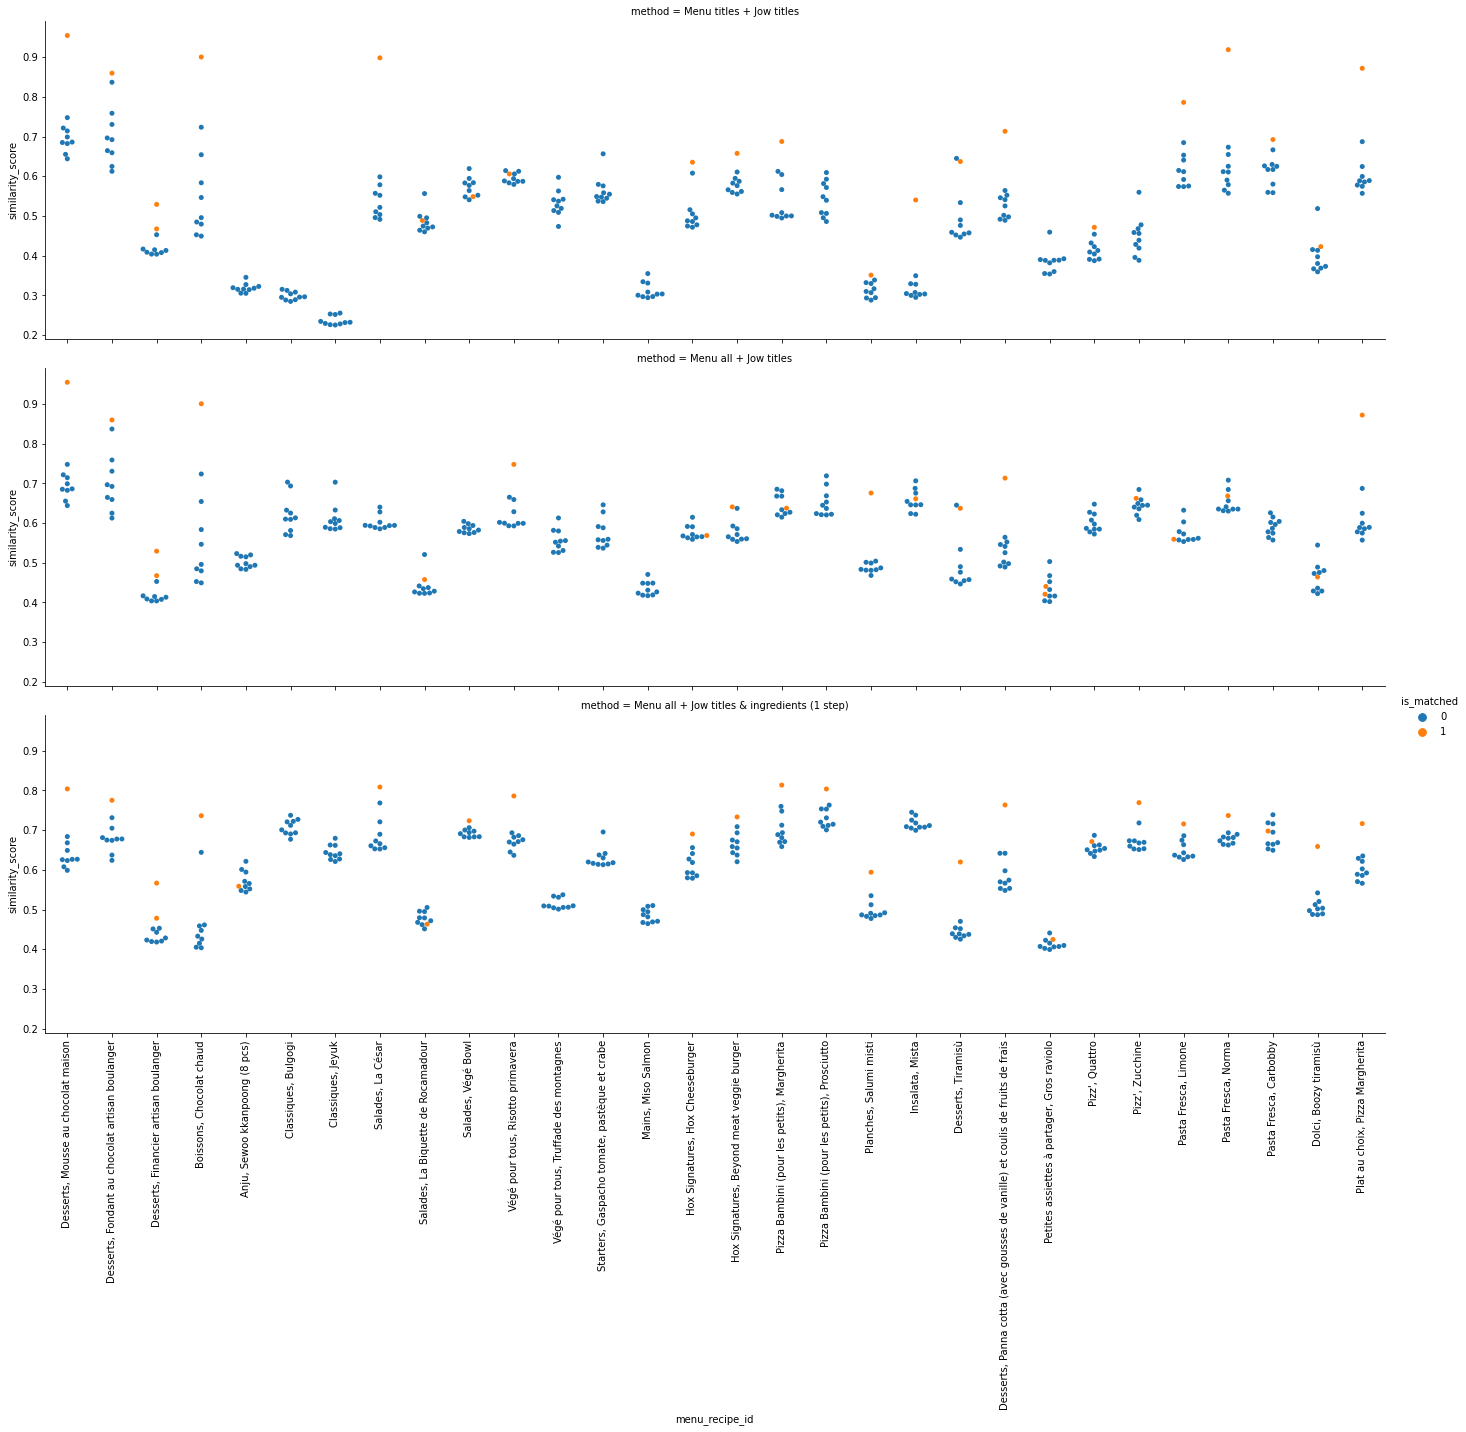

In [180]:
fig = sns.catplot(data = data_res_tot2, x = 'menu_recipe_id', y = 'similarity_score', row = 'method', \
                  hue = 'is_matched', kind = 'swarm', aspect = 4)
fig.set_xticklabels(rotation=90);

In [181]:
print("Number of good matchings among outputs with rank 1 :")
data_res3[(data_res3['similarity_rank']==1) & (data_res3['is_matched']==1)].shape[0]

Number of good matchings among outputs with rank 1 :


19

In [182]:
print("Number of good matchings among outputs with rank between 2 and 10 :")
data_res3[(data_res3['similarity_rank']>1) & (data_res3['similarity_rank']<=10) & (data_res3['is_matched']==1)].shape[0]

Number of good matchings among outputs with rank between 2 and 10 :


6

In [183]:
data_res2_rank1 = data_res_tot2[data_res_tot2['similarity_rank']==1]
pd.crosstab(data_res2_rank1['is_matched'], data_res2_rank1['method'])

method,Menu all + Jow titles,Menu all + Jow titles & ingredients (1 step),Menu titles + Jow titles
is_matched,,,
0,21,11,14
1,9,19,16


**The best method till now is the last one ie the one doing the recipe similarity task between menu recipes characterized by titles+subtitles+ingredients (if any) and jow recipes characterized by recipe names+ingredients (no quantity).**

Let's have a look at menu recipes whose first rank NLP predictions differ between the three methods.

In [184]:
# If the three methods give the same 'is_matched' prediction, then the sum of those 3 variables is either 0 or 3.
df_tmp = pd.DataFrame(data_res2_rank1.groupby('menu_recipe_id')['is_matched'].agg(sum))
df_tmp.head()

,is_matched
menu_recipe_id,
"Anju, Sewoo kkanpoong (8 pcs)",0
"Boissons, Chocolat chaud",3
"Classiques, Bulgogi",0
"Classiques, Jeyuk",0
"Desserts, Financier artisan boulanger",3


In [185]:
# Select recipes where the three methods give different "is_matched" predictions
df_tmp2 = df_tmp[(df_tmp['is_matched']!=0) & (df_tmp['is_matched']!=3)]
df_tmp2.head()

,is_matched
menu_recipe_id,
"Desserts, Tiramisù",1
"Dolci, Boozy tiramisù",1
"Hox Signatures, Hox Cheeseburger",2
"Insalata, Mista",1
"Pasta Fresca, Carbobby",1


In [186]:
data_res_tot2[data_res_tot2['menu_recipe_id'].isin(list(df_tmp2.index))]

,menu_recipe_id,menu_recipe_label,jow_guess,similarity_rank,similarity_score,is_matched,menu_labels,method
70,"Salades, La César","Salades, La César",Salade César,1,0.898502,1,Titles and subtitles,Menu titles + Jow titles
71,"Salades, La César","Salades, La César",Salade méditerranéenne,2,0.598537,0,Titles and subtitles,Menu titles + Jow titles
72,"Salades, La César","Salades, La César",Salade campagnarde,3,0.578582,0,Titles and subtitles,Menu titles + Jow titles
73,"Salades, La César","Salades, La César",Salade à la grecque,4,0.557157,0,Titles and subtitles,Menu titles + Jow titles
74,"Salades, La César","Salades, La César",Salade de légumes rôtis,5,0.552109,0,Titles and subtitles,Menu titles + Jow titles
...,...,...,...,...,...,...,...,...
285,"Dolci, Boozy tiramisù","Dolci, Boozy tiramisù, Tiramisù classique + Amaretto (liqueur d'amande)",Roulé façon tiramisu,6,0.501706,0,All,Menu all + Jow titles & ingredients (1 step)
286,"Dolci, Boozy tiramisù","Dolci, Boozy tiramisù, Tiramisù classique + Amaretto (liqueur d'amande)",Tarte express aux abricots,7,0.497204,0,All,Menu all + Jow titles & ingredients (1 step)
287,"Dolci, Boozy tiramisù","Dolci, Boozy tiramisù, Tiramisù classique + Amaretto (liqueur d'amande)",Petite crème au caramel,8,0.489130,0,All,Menu all + Jow titles & ingredients (1 step)
288,"Dolci, Boozy tiramisù","Dolci, Boozy tiramisù, Tiramisù classique + Amaretto (liqueur d'amande)",Cake à la myrtille,9,0.487681,0,All,Menu all + Jow titles & ingredients (1 step)


There are 3 menu recipes (over 30) for which the third method 'Menu all + Jow titles & ingredients (1 step)' give wrong rank-1 predictions while at least one other method gives correct predictions.

## Let's focus now on menu recipes for which only titles and subtitles are given.

In [187]:
menu_data_withmatch_noingr = menu_data_withmatch[menu_data_withmatch['Menu Ingredients']=='']
menu_data_withmatch_noingr

,Unnamed: 0,Menu filename,Menu Title,Menu Subtitle,Menu Ingredients,Closest JOW recipe by hand,Menu Title and Subtitle,Menu all
0,7,burgart_205074_c70.jpg,Desserts,Mousse au chocolat maison,,Mousse au chocolat maison,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison"
1,8,burgart_205074_c70.jpg,Desserts,Fondant au chocolat artisan boulanger,,Fondant au chocolat,"Desserts, Fondant au chocolat artisan boulanger","Desserts, Fondant au chocolat artisan boulanger"
2,9,burgart_205074_c70.jpg,Desserts,Financier artisan boulanger,,"['Financier cerises noires & pistache', 'Financier à la framboise']","Desserts, Financier artisan boulanger","Desserts, Financier artisan boulanger"
5,12,burgart_205074_c70.jpg,Boissons,Chocolat chaud,,Chocolat chaud,"Boissons, Chocolat chaud","Boissons, Chocolat chaud"
37,52,in-bocca-al-lupo_42356_293.jpg,Desserts,Tiramisù,,Tiramisu,"Desserts, Tiramisù","Desserts, Tiramisù"
38,53,in-bocca-al-lupo_42356_293.jpg,Desserts,Panna cotta (avec gousses de vanille) et coulis de fruits de frais,,Panna cotta à la fraise,"Desserts, Panna cotta (avec gousses de vanille) et coulis de fruits de frais","Desserts, Panna cotta (avec gousses de vanille) et coulis de fruits de frais"
47,76,fabbrezza_202084_665.jpg,Plat au choix,Pizza Margherita,,Pizza Margherita,"Plat au choix, Pizza Margherita","Plat au choix, Pizza Margherita"


In [188]:
print("Number of menu recipes with no ingredients = ", menu_data_withmatch_noingr.shape[0])

Number of menu recipes with no ingredients =  7


Run the NLP model when only jow titles are given.

In [189]:
# Find the closest 10 recipes of the (JOW) corpus for each query recipe based on cosine similarity
dict_res4 = {}

for index, row in menu_data_withmatch_noingr.iterrows():
    query = row['Menu Title and Subtitle']
    print("\n======================\n")
    t0 = time.time()
    query_embedding2 = model2.encode(query, convert_to_tensor=True)
    #print("Time lapse for one query embedding (s) = ", time.time()-t0, '\n')

    # We use util.semantic_search to perform cosine similarty + topk
    printmd("**Query : "+query+"**")
    printmd("**Closest JOW recipe (by hand) : "+row['Closest JOW recipe by hand']+"**")
    print("\nTop 10 most similar recipes in JOW:")
    t0 = time.time()
    hits = util.semantic_search(query_embedding2, jow_recipe_embeddings2, top_k=10)
    hits = hits[0]      #Get the hits for the first query
    
    for k, hit in enumerate(hits):
        jow_recipe = jow_recipes[hit['corpus_id']]
        print(k+1, ") ", jow_recipe, "(Score: {:.4f})".format(hit['score']))
        print('--> ingredients = ', list(jow_data[jow_data['recipe_name']==jow_recipe]['ingredients']))
    #print("\n Time lapse for finding the 5 closest recipes with semantic_search function (s) = ", time.time()-t0)

    # Store results in a dictionary
    for k, hit in enumerate(hits):
        jow_recipe = jow_recipes[hit['corpus_id']]
       
        closest_jow = row['Closest JOW recipe by hand'] 
        if closest_jow[0]=='[':       # To detect lists because they have been converted to strings. Bad, Bad!
            matched_idx = 1 if jow_recipe in closest_jow else 0
        else:
            matched_idx = 1 if jow_recipe==closest_jow else 0

        # For each menu recipe (index) and hit (k), store menu_recipe_id, menu_recipe_label, jow_guess, similarity_rank, similary_score, is_matched
        dict_res4[str(index)+'_'+str(k)] = [query, query, jow_recipe, k+1, hit['score'], matched_idx]          

**Query : Desserts, Mousse au chocolat maison**

**Closest JOW recipe (by hand) : Mousse au chocolat maison**


Top 10 most similar recipes in JOW:
1 )  Mousse au chocolat maison (Score: 0.9548)
--> ingredients =  [['Chocolat à cuire', 'Œuf']]
2 )  Crème au chocolat (Score: 0.7479)
--> ingredients =  [['Chocolat à cuire', 'Lait', 'Sucre', 'Maïzena']]
3 )  Fondant au chocolat (Score: 0.7216)
--> ingredients =  [['Chocolat à cuire', 'Beurre demi-sel', 'Sucre', 'Œuf']]
4 )  Pâte à tartiner au chocolat (Score: 0.7143)
--> ingredients =  [['Noisette', 'Chocolat à cuire', 'Crème liquide', 'Sucre', 'Huile de tournesol']]
5 )  Tarte au chocolat (Score: 0.6990)
--> ingredients =  [['Sucre', 'Chocolat à cuire', 'Farine de blé', 'Beurre demi-sel', 'Crème liquide 30%']]
6 )  Fondant choco marrons (Score: 0.6862)
--> ingredients =  [['Œuf', 'Beurre demi-sel', 'Chocolat à cuire', 'Crème de marrons']]
7 )  Mousse au chocolat à l'orange (Score: 0.6851)
--> ingredients =  [['Chocolat à cuire', 'Œuf', 'Grand Marnier', 'Orange']]
8 )  Fondant-flan au chocolat & amande (Score: 0.6825)
--> ingredients =  [['Boisson

**Query : Desserts, Fondant au chocolat artisan boulanger**

**Closest JOW recipe (by hand) : Fondant au chocolat**


Top 10 most similar recipes in JOW:
1 )  Fondant au chocolat (Score: 0.8599)
--> ingredients =  [['Chocolat à cuire', 'Beurre demi-sel', 'Sucre', 'Œuf']]
2 )  Fondant-flan au chocolat & amande (Score: 0.8370)
--> ingredients =  [['Boisson amande', 'Beurre demi-sel', 'Sucre', 'Farine de blé', 'Cacao', 'Œuf']]
3 )  Fondant choco marrons (Score: 0.7589)
--> ingredients =  [['Œuf', 'Beurre demi-sel', 'Chocolat à cuire', 'Crème de marrons']]
4 )  Fondant au chocolat à l'huile d'olive (Score: 0.7307)
--> ingredients =  [['Œuf', 'Chocolat à cuire', 'Sucre glace', "Huile d'olive", "Poudre d'amande"]]
5 )  Mousse au chocolat maison (Score: 0.6966)
--> ingredients =  [['Chocolat à cuire', 'Œuf']]
6 )  Pâte à tartiner au chocolat (Score: 0.6923)
--> ingredients =  [['Noisette', 'Chocolat à cuire', 'Crème liquide', 'Sucre', 'Huile de tournesol']]
7 )  Crème au chocolat (Score: 0.6647)
--> ingredients =  [['Chocolat à cuire', 'Lait', 'Sucre', 'Maïzena']]
8 )  Tarte au chocolat (Score: 0.6593)
--> 

**Query : Desserts, Financier artisan boulanger**

**Closest JOW recipe (by hand) : ['Financier cerises noires & pistache', 'Financier à la framboise']**


Top 10 most similar recipes in JOW:
1 )  Financier à la framboise (Score: 0.5292)
--> ingredients =  [['Farine de blé', 'Œuf', 'Sucre glace', 'Beurre', "Poudre d'amande", 'Framboises']]
2 )  Financier cerises noires & pistache (Score: 0.4675)
--> ingredients =  [['Cerises', 'Beurre', 'Sucre glace', 'Farine de blé', 'Œuf', 'Pistaches', 'Vanille']]
3 )  Brioche perdue à la fraise (Score: 0.4528)
--> ingredients =  [['Fraise', 'Brioche', 'Lait', 'Sucre', 'Œuf']]
4 )  Fraisier facile (Score: 0.4167)
--> ingredients =  [['Fraise', 'Œuf', 'Farine de blé', 'Sucre', 'Levure chimique', 'Sucre glace', 'Crème liquide 30%', 'Mascarpone']]
5 )  Biscuits de Noël (Score: 0.4149)
--> ingredients =  [['Sucre de canne', 'Farine de blé', 'Levure chimique', 'Beurre', "Poudre d'amande", 'Cannelle', 'Œuf']]
6 )  Gâteau au skyr, fraises & chocolat (Score: 0.4131)
--> ingredients =  [['Farine de blé', "Poudre d'amande", 'Œuf', 'Fraise', 'Levure chimique', 'Skyr', 'Citron jaune', 'Sucre']]
7 )  Fondant-flan a

**Query : Boissons, Chocolat chaud**

**Closest JOW recipe (by hand) : Chocolat chaud**


Top 10 most similar recipes in JOW:
1 )  Chocolat chaud (Score: 0.9006)
--> ingredients =  [['Chocolat à cuire', 'Lait', 'Cacao']]
2 )  Chocolat chaud & marshmallows (Score: 0.7237)
--> ingredients =  [['Chocolat à cuire', 'Lait', 'Cacao', 'Guimauve']]
3 )  Vin chaud (Score: 0.6543)
--> ingredients =  [['Vin rouge', 'Orange', 'Cannelle', 'Anis étoilé', 'Gingembre', 'Sucre', 'Sucre vanillé']]
4 )  Fondant au chocolat (Score: 0.5836)
--> ingredients =  [['Chocolat à cuire', 'Beurre demi-sel', 'Sucre', 'Œuf']]
5 )  Fondant choco marrons (Score: 0.5465)
--> ingredients =  [['Œuf', 'Beurre demi-sel', 'Chocolat à cuire', 'Crème de marrons']]
6 )  Crème au chocolat (Score: 0.4958)
--> ingredients =  [['Chocolat à cuire', 'Lait', 'Sucre', 'Maïzena']]
7 )  Mousse au chocolat maison (Score: 0.4848)
--> ingredients =  [['Chocolat à cuire', 'Œuf']]
8 )  Bûche de Noël au chocolat (Score: 0.4796)
--> ingredients =  [['Œuf', 'Farine de blé', 'Sucre', 'Levure chimique', 'Chocolat à cuire', 'Crème liq

**Query : Desserts, Tiramisù**

**Closest JOW recipe (by hand) : Tiramisu**


Top 10 most similar recipes in JOW:
1 )  Roulé façon tiramisu (Score: 0.6451)
--> ingredients =  [['Œuf', 'Farine de blé', 'Sucre', 'Levure chimique']]
2 )  Tiramisu (Score: 0.6372)
--> ingredients =  [['Sucre', 'Sucre vanillé', 'Œuf', 'Cacao', 'Mascarpone', 'Biscuit cuiller', 'Café', 'Amaretto']]
3 )  Petite crème au caramel (Score: 0.5337)
--> ingredients =  [['Lait', 'Œuf', 'Sucre', 'Crème liquide', 'Beurre', 'Vanille']]
4 )  Gâteau au skyr, fraises & chocolat (Score: 0.4901)
--> ingredients =  [['Farine de blé', "Poudre d'amande", 'Œuf', 'Fraise', 'Levure chimique', 'Skyr', 'Citron jaune', 'Sucre']]
5 )  Tarte aux fraises (Score: 0.4762)
--> ingredients =  [['Beurre demi-sel', 'Crème liquide', 'Farine de blé', 'Sucre', 'Fraise', 'Citron vert', 'Petit suisse', 'Mascarpone']]
6 )  Cake au yaourt (Score: 0.4589)
--> ingredients =  [['Yaourt nature', 'Œuf', 'Farine de blé', 'Sucre', 'Huile de tournesol', 'Levure chimique']]
7 )  Fraises & chantilly maison (Score: 0.4575)
--> ingredien

**Query : Desserts, Panna cotta (avec gousses de vanille) et coulis de fruits de frais**

**Closest JOW recipe (by hand) : Panna cotta à la fraise**


Top 10 most similar recipes in JOW:
1 )  Panna cotta à la fraise (Score: 0.7133)
--> ingredients =  [['Fraise', 'Crème liquide', 'Sucre', 'Vanille', 'Gélatine']]
2 )  Banane caramélisée miel & glace vanille (Score: 0.5642)
--> ingredients =  [['Banane', 'Miel', 'Noix', 'Crème glacée Vanille']]
3 )  Nectarine rôtie & glace vanille (Score: 0.5524)
--> ingredients =  [['Crème glacée Vanille', 'Nectarine', 'Amandes', 'Beurre', 'Sucre de canne']]
4 )  Fraises & chantilly maison (Score: 0.5460)
--> ingredients =  [['Fraise', 'Crème liquide 30%', 'Sucre', 'Vanille']]
5 )  Roulé aux fraises & mascarpone (Score: 0.5411)
--> ingredients =  [['Fraise', 'Œuf', 'Farine de blé', 'Sucre', 'Levure chimique', 'Sucre glace', 'Crème liquide', 'Mascarpone']]
6 )  Petite crème au caramel (Score: 0.5253)
--> ingredients =  [['Lait', 'Œuf', 'Sucre', 'Crème liquide', 'Beurre', 'Vanille']]
7 )  Gaufres aux fraises & chantilly (Score: 0.5017)
--> ingredients =  [['Farine de blé', 'Sucre', 'Beurre', 'Lait', 'Œu

**Query : Plat au choix, Pizza Margherita**

**Closest JOW recipe (by hand) : Pizza Margherita**


Top 10 most similar recipes in JOW:
1 )  Pizza Margherita (Score: 0.8721)
--> ingredients =  [['Pâte à pizza', 'Tomate', 'Mozzarella', 'Basilic']]
2 )  Pâte à pizza maison (Score: 0.6873)
--> ingredients =  [['Farine de blé', 'Levure boulangère', 'Sucre', "Huile d'olive"]]
3 )  Pizza maison 3 fromages (Score: 0.6246)
--> ingredients =  [['Pâte à pizza', 'Roquefort', 'Tomate', 'Mozzarella', 'Chèvre frais']]
4 )  Pizza bianca (Score: 0.5996)
--> ingredients =  [['Pâte à pizza', 'Ricotta', 'Mozzarella', 'Basilic']]
5 )  Pizza printanière (Score: 0.5892)
--> ingredients =  [['Pâte à pizza', 'Petits pois', 'Jambon cru', 'Œuf', 'Sauce pesto', 'Mozzarella', 'Salade']]
6 )  Pizza puttanesca (Score: 0.5887)
--> ingredients =  [['Pâte à pizza', 'Tomate', 'Anchois', 'Olive noire', 'Câpres', 'Mozzarella']]
7 )  Pizza au chorizo (Score: 0.5857)
--> ingredients =  [['Pâte à pizza', 'Tomate', 'Chorizo', 'Mozzarella', 'Basilic']]
8 )  Pizza champignons & ricotta (Score: 0.5779)
--> ingredients =  [['

In [190]:
data_res4 = pd.DataFrame.from_dict(dict_res4, orient = 'index', \
                                  columns = ['menu_recipe_id', 'menu_recipe_label', 'jow_guess', 'similarity_rank', 'similarity_score', 'is_matched'])\
                                  .reset_index(drop = True)

data_res4.head()

,menu_recipe_id,menu_recipe_label,jow_guess,similarity_rank,similarity_score,is_matched
0,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Mousse au chocolat maison,1,0.954754,1
1,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Crème au chocolat,2,0.747854,0
2,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Fondant au chocolat,3,0.721633,0
3,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Pâte à tartiner au chocolat,4,0.714327,0
4,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Tarte au chocolat,5,0.699011,0


Now let's run the NLP model when JOW titles + ingredients are given.

In [191]:
# Find the closest 10 recipes of the (JOW) corpus for each query recipe based on cosine similarity
dict_res5 = {}

for index, row in menu_data_withmatch_noingr.iterrows():
    query = row['Menu Title and Subtitle']           # Menu recipes are labeled by their titles, subtitles, and ingredients
    print("\n======================\n")
    t0 = time.time()
    query_embedding = model2.encode(query, convert_to_tensor=True)
    #print("Time lapse for one query embedding (s) = ", time.time()-t0, '\n')

    # We use util.semantic_search to perform cosine similarty + topk
    printmd("**Query : "+query+"**")
    printmd("**Closest JOW recipe (by hand) : "+row['Closest JOW recipe by hand']+"**")
    print("\nTop 10 most similar recipes in JOW:")
    t0 = time.time()
    hits = util.semantic_search(query_embedding, jow_fullname_embeddings2, top_k=10)
    hits = hits[0]      #Get the hits for the first query
    
    for k, hit in enumerate(hits):
        jow_fullname_recipe = jow_fullname_recipes[hit['corpus_id']]
        jow_recipe = jow_data[jow_data['name_with_ingredients']==jow_fullname_recipe]['recipe_name'].values[0]
        jow_ingredients = list(jow_data[jow_data['recipe_name']==jow_recipe]['ingredients_with_quantity'])
        print(k+1, ") ", jow_recipe, "(Score: {:.4f})".format(hit['score']))
        print('--> ingredients = ', jow_ingredients)
    #print("\n Time lapse for finding the 5 closest recipes with semantic_search function (s) = ", time.time()-t0)

    # Store results in a dictionary
    for k, hit in enumerate(hits):
        jow_fullname_recipe = jow_fullname_recipes[hit['corpus_id']]
        jow_recipe = jow_data[jow_data['name_with_ingredients']==jow_fullname_recipe]['recipe_name'].values[0]
        menu_recipe_id = row['Menu Title and Subtitle']
       
        closest_jow = row['Closest JOW recipe by hand'] 
        if closest_jow[0]=='[':       # To detect lists because they have been converted to strings. Bad, Bad!
            matched_idx = 1 if jow_recipe in closest_jow else 0
        else:
            matched_idx = 1 if jow_recipe==closest_jow else 0

        # For each menu recipe (index) and hit (k), store menu_recipe_id, menu_recipe_label, jow_guess, similarity_rank, similary_score, is_matched
        dict_res5[str(index)+'_'+str(k)] = [menu_recipe_id, query, jow_recipe, k+1, hit['score'], matched_idx]    


**Query : Desserts, Mousse au chocolat maison**

**Closest JOW recipe (by hand) : Mousse au chocolat maison**


Top 10 most similar recipes in JOW:
1 )  Mousse au chocolat maison (Score: 0.8039)
--> ingredients =  [[['33 g', 'Chocolat à cuire'], ['1', 'Œuf']]]
2 )  Truffes maison au chocolat (Score: 0.6839)
--> ingredients =  [[['80 g', 'Chocolat à cuire'], ['4 g', 'Beurre'], ['3 cl', 'Crème liquide'], ['3 g', 'Cacao (en poudre)']]]
3 )  Crème au chocolat (Score: 0.6681)
--> ingredients =  [[['140 g', 'Chocolat à cuire'], ['50 cl', 'Lait'], ['25 g', 'Sucre (en poudre)'], ['25 g', 'Maïzena']]]
4 )  Tarte au chocolat (Score: 0.6489)
--> ingredients =  [[['100 g', 'Sucre (en poudre)'], ['200 g', 'Chocolat à cuire'], ['200 g', 'Farine de blé'], ['120 g', 'Beurre demi-sel'], ['20 cl', 'Crème liquide 30%']]]
5 )  Mousse au chocolat à l'orange (Score: 0.6267)
--> ingredients =  [[['33 g', 'Chocolat à cuire'], ['1', 'Œuf'], ['6 ml', 'Grand Marnier'], ['1/4', 'Orange']]]
6 )  Pâte à tartiner au chocolat (Score: 0.6264)
--> ingredients =  [[['50 g', 'Noisette'], ['50 g', 'Chocolat à cuire'], ['7 cl', 'Cr

**Query : Desserts, Fondant au chocolat artisan boulanger**

**Closest JOW recipe (by hand) : Fondant au chocolat**


Top 10 most similar recipes in JOW:
1 )  Fondant au chocolat (Score: 0.7752)
--> ingredients =  [[['200 g', 'Chocolat à cuire'], ['125 g', 'Beurre demi-sel'], ['130 g', 'Sucre (en poudre)'], ['4', 'Œuf'], ['25 g']]]
2 )  Fondant-flan au chocolat & amande (Score: 0.7313)
--> ingredients =  [[['37 cl', 'Boisson amande'], ['95 g', 'Beurre demi-sel'], ['110 g', 'Sucre (en poudre)'], ['55 g', 'Farine de blé'], ['30 g', 'Cacao (en poudre)'], ['3', 'Œuf']]]
3 )  Fondant choco marrons (Score: 0.7049)
--> ingredients =  [[['3', 'Œuf'], ['150 g', 'Beurre demi-sel'], ['200 g', 'Chocolat à cuire'], ['500 g', 'Crème de marrons']]]
4 )  Fondant au chocolat à l'huile d'olive (Score: 0.6811)
--> ingredients =  [[['4', 'Œuf'], ['250 g', 'Chocolat à cuire'], ['175 g', 'Sucre glace'], ['10 cl', "Huile d'olive"], ['90 g', "Poudre d'amande"]]]
5 )  Tarte au chocolat (Score: 0.6777)
--> ingredients =  [[['100 g', 'Sucre (en poudre)'], ['200 g', 'Chocolat à cuire'], ['200 g', 'Farine de blé'], ['120 g', 'Be

**Query : Desserts, Financier artisan boulanger**

**Closest JOW recipe (by hand) : ['Financier cerises noires & pistache', 'Financier à la framboise']**


Top 10 most similar recipes in JOW:
1 )  Financier à la framboise (Score: 0.5665)
--> ingredients =  [[['60 g', 'Farine de blé'], ['4', 'Œuf'], ['150 g', 'Sucre glace'], ['100 g', 'Beurre'], ['90 g', "Poudre d'amande"], ['125 g', 'Framboises']]]
2 )  Financier cerises noires & pistache (Score: 0.4781)
--> ingredients =  [[['480 g', 'Cerises'], ['200 g', 'Beurre'], ['200 g', 'Sucre glace'], ['160 g', 'Farine de blé'], ['8', 'Œuf'], ['150 g', 'Pistaches (émondées)'], ['1', 'Vanille (gousse)']]]
3 )  Pain perdu brioché (Score: 0.4528)
--> ingredients =  [[['10 cl', 'Lait'], ['1', 'Œuf'], ['40 g', 'Sucre (en poudre)'], ['Facultatif', '2 càc', "Sirop d'érable"], ['160 g', 'Brioche (tranchée)']]]
4 )  Brioche perdue à la fraise (Score: 0.4511)
--> ingredients =  [[['80 g', 'Fraise'], ['30 g', 'Brioche (tranchée)'], ['15 cl', 'Lait'], ['2 càs', 'Sucre (en poudre)'], ['1', 'Œuf']]]
5 )  Tarte rustique aux fraises (Score: 0.4426)
--> ingredients =  [[['250 g', 'Farine de blé'], ['150 g', 'Beur

**Query : Boissons, Chocolat chaud**

**Closest JOW recipe (by hand) : Chocolat chaud**


Top 10 most similar recipes in JOW:
1 )  Chocolat chaud (Score: 0.7364)
--> ingredients =  [[['30 g', 'Chocolat à cuire'], ['25 cl', 'Lait'], ['1 càc', 'Cacao (en poudre)']]]
2 )  Chocolat chaud & marshmallows (Score: 0.6440)
--> ingredients =  [[['30 g', 'Chocolat à cuire'], ['25 cl', 'Lait'], ['1 càc', 'Cacao (en poudre)'], ['2', 'Guimauve']]]
3 )  Truffes maison au chocolat (Score: 0.4612)
--> ingredients =  [[['80 g', 'Chocolat à cuire'], ['4 g', 'Beurre'], ['3 cl', 'Crème liquide'], ['3 g', 'Cacao (en poudre)']]]
4 )  Fondant au chocolat (Score: 0.4587)
--> ingredients =  [[['200 g', 'Chocolat à cuire'], ['125 g', 'Beurre demi-sel'], ['130 g', 'Sucre (en poudre)'], ['4', 'Œuf'], ['25 g']]]
5 )  Crème au chocolat (Score: 0.4474)
--> ingredients =  [[['140 g', 'Chocolat à cuire'], ['50 cl', 'Lait'], ['25 g', 'Sucre (en poudre)'], ['25 g', 'Maïzena']]]
6 )  Fondant-flan au chocolat & amande (Score: 0.4328)
--> ingredients =  [[['37 cl', 'Boisson amande'], ['95 g', 'Beurre demi-sel']

**Query : Desserts, Tiramisù**

**Closest JOW recipe (by hand) : Tiramisu**


Top 10 most similar recipes in JOW:
1 )  Tiramisu (Score: 0.6197)
--> ingredients =  [[['100 g', 'Sucre (en poudre)'], ['Facultatif', '1 sac.', 'Sucre vanillé'], ['3', 'Œuf'], ['2 càs', 'Cacao (en poudre)'], ['250 g', 'Mascarpone'], ['20', 'Biscuit cuiller'], ['2 càc', 'Café'], ['Facultatif', '1 càs', 'Amaretto']]]
2 )  Roulé façon tiramisu (Score: 0.4701)
--> ingredients =  [[['4', 'Œuf'], ['125 g', 'Farine de blé'], ['125 g', 'Sucre (en poudre)'], ['1 càc', 'Levure chimique'], ['35 g'], ['25 cl'], ['120 g'], ['15 g']]]
3 )  Petite crème au caramel (Score: 0.4540)
--> ingredients =  [[['10 cl', 'Lait'], ['1', 'Œuf'], ['30 g', 'Sucre (en poudre)'], ['1 càs', 'Crème liquide'], ['1 noisette', 'Beurre'], ['1/4', 'Vanille (gousse)']]]
4 )  Compote pommes poires maison (Score: 0.4518)
--> ingredients =  [[['1/2', 'Pomme (à cuire)'], ['1/2 càc', 'Sucre (en poudre)'], ['1/2', 'Poire']]]
5 )  Tarte aux pommes & compote (Score: 0.4389)
--> ingredients =  [[['4', 'Pomme (à cuire)'], ['80 g', "P

**Query : Desserts, Panna cotta (avec gousses de vanille) et coulis de fruits de frais**

**Closest JOW recipe (by hand) : Panna cotta à la fraise**


Top 10 most similar recipes in JOW:
1 )  Panna cotta à la fraise (Score: 0.7634)
--> ingredients =  [[['80 g', 'Fraise'], ['10 cl', 'Crème liquide'], ['2 càs', 'Sucre (en poudre)'], ['1/4', 'Vanille (gousse)'], ['1/2', 'Gélatine']]]
2 )  Fraises & chantilly maison (Score: 0.6417)
--> ingredients =  [[['100 g', 'Fraise'], ['1 cl', 'Crème liquide 30%'], ['1/2 càc', 'Sucre (en poudre)'], ['Facultatif', '1/5', 'Vanille (gousse)']]]
3 )  Pavlova aux fruits rouges (Score: 0.6417)
--> ingredients =  [[['1', 'Œuf'], ['60 g', 'Sucre (en poudre)'], ['3 cl', 'Crème liquide'], ['60 g', 'Fraise'], ['2 càs', 'Coulis de fruits rouges']]]
4 )  Petite crème au caramel (Score: 0.5976)
--> ingredients =  [[['10 cl', 'Lait'], ['1', 'Œuf'], ['30 g', 'Sucre (en poudre)'], ['1 càs', 'Crème liquide'], ['1 noisette', 'Beurre'], ['1/4', 'Vanille (gousse)']]]
5 )  Banane caramélisée miel & glace vanille (Score: 0.5741)
--> ingredients =  [[['1', 'Banane'], ['1 càs', 'Miel (liquide)'], ['15 g', 'Noix'], ['40 g',

**Query : Plat au choix, Pizza Margherita**

**Closest JOW recipe (by hand) : Pizza Margherita**


Top 10 most similar recipes in JOW:
1 )  Pizza Margherita (Score: 0.7165)
--> ingredients =  [[['1', 'Pâte à pizza'], ['60 g', 'Tomate (purée)'], ['1', 'Mozzarella (boule)'], ['1/5 bou.', 'Basilic (frais)']]]
2 )  Pizza bianca (Score: 0.6349)
--> ingredients =  [[['1', 'Pâte à pizza'], ['140 g', 'Ricotta'], ['1', 'Mozzarella (boule)'], ['Facultatif', '1/5 bou.', 'Basilic (frais)']]]
3 )  Pizza maison chèvre miel (Score: 0.6290)
--> ingredients =  [[['1', 'Pâte à pizza'], ['2 g', 'Romarin (séché)'], ['2 càc', 'Miel (liquide)'], ['100 g', 'Chèvre frais']]]
4 )  Pizza maison 3 fromages (Score: 0.6213)
--> ingredients =  [[['1', 'Pâte à pizza'], ['50 g', 'Roquefort'], ['50 g', 'Tomate (concentré)'], ['1', 'Mozzarella (boule)'], ['100 g', 'Chèvre frais']]]
5 )  Pizza Parma (Score: 0.6024)
--> ingredients =  [[['1', 'Pâte à pizza'], ['60 g', 'Tomate (purée)'], ['3 tran.', 'Jambon cru'], ['1', 'Mozzarella (boule)'], ['1 poignée', 'Salade (roquette)']]]
6 )  Pizza champignons & ricotta (Score

In [192]:
data_res5 = pd.DataFrame.from_dict(dict_res5, orient = 'index', \
                                  columns = ['menu_recipe_id', 'menu_recipe_label', 'jow_guess', 'similarity_rank', 'similarity_score', 'is_matched'])\
                                  .reset_index(drop = True)

data_res5.head()

,menu_recipe_id,menu_recipe_label,jow_guess,similarity_rank,similarity_score,is_matched
0,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Mousse au chocolat maison,1,0.803918,1
1,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Truffes maison au chocolat,2,0.683853,0
2,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Crème au chocolat,3,0.668090,0
3,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Tarte au chocolat,4,0.648898,0
4,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Mousse au chocolat à l'orange,5,0.626683,0


Let's compare the two approaches (remember that here we only deal with menu recipes having no ingredients)

In [193]:
data_res4['method'] = 'Menu titles & subtitles + Jow titles'
data_res5['method'] = 'Menu titles & subtitles + Jow titles & ingredients (1 step)'
data_res4['menu_labels'] = 'Titles and subtitles'
data_res5['menu_labels'] = 'Titles and subtitles'
data_res_tot3 = pd.concat([data_res4, data_res5], axis = 0)
data_res_tot3.head()

,menu_recipe_id,menu_recipe_label,jow_guess,similarity_rank,similarity_score,is_matched,method,menu_labels
0,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Mousse au chocolat maison,1,0.954754,1,Menu titles & subtitles + Jow titles,Titles and subtitles
1,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Crème au chocolat,2,0.747854,0,Menu titles & subtitles + Jow titles,Titles and subtitles
2,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Fondant au chocolat,3,0.721633,0,Menu titles & subtitles + Jow titles,Titles and subtitles
3,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Pâte à tartiner au chocolat,4,0.714327,0,Menu titles & subtitles + Jow titles,Titles and subtitles
4,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Tarte au chocolat,5,0.699011,0,Menu titles & subtitles + Jow titles,Titles and subtitles


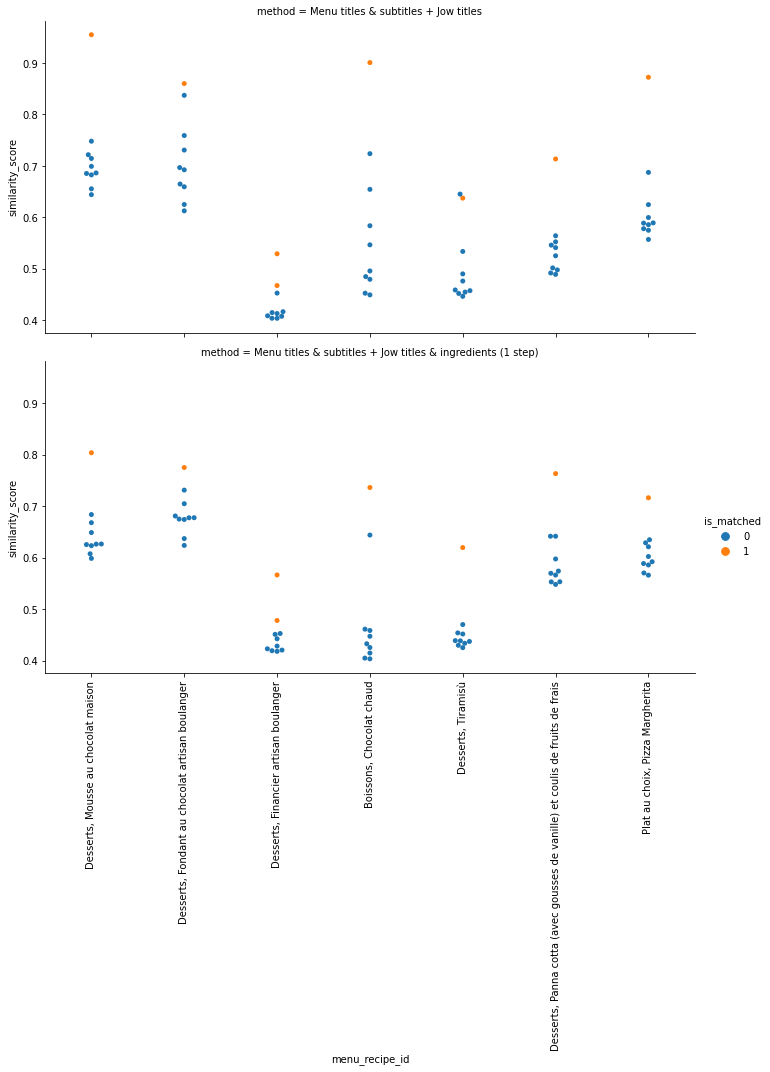

In [194]:
fig = sns.catplot(data = data_res_tot3, x = 'menu_recipe_id', y = 'similarity_score', row = 'method', \
                  hue = 'is_matched', kind = 'swarm', aspect = 2)
fig.set_xticklabels(rotation=90);

Even for menu recipes without explicit ingredients (only titles and subtitles), it seems to be slightly better to do the recipe similarity task by characterizing Jow recipes with their names+ingredients. However our database is too small for this case (only 7 entries). It's probably fine to conclude that both methods are equivalent. But again this needs to be re-checked with more data.

## Fourth method : in two steps, preselection with menu titles/subtitles vs jow recipe names, then refinement with menu and Jow ingredients 

In [195]:
# Function that returns the hits in data_base corresponding to the query,
# whose similarity scores are among the top_k biggest scores and larger than max_score - radius
def most_similar_recipes(query, database_embedding, model, top_k = 20, radius = 0.1):
    query_embedding = model.encode(query, convert_to_tensor=True)
    hits = util.semantic_search(query_embedding, database_embedding, top_k = top_k)    #find the top_k closest database recipes from query
    hits = hits[0]      #Get the hits for the first query (here only one query is given)

    # Keep only the recipes whose similarity scores are highest that max_score - radius
    best_hits = []
    for k, hit in enumerate(hits):
        max_score = hits[0]['score']  # hits is stored by descending scores
        if hit['score'] > max_score - radius:
            best_hits.append(hit)

    return best_hits

A short technical parenthesis to see if the choice of top_k has important impact on the computation time.

In [196]:
topk_values = np.arange(1, 500, 10)
all_times = []

for index, row in menu_data_withmatch.iterrows():
    query = row['Menu Title and Subtitle']
    
    times = []
    for top_k in topk_values:
        t0 = time.time()
        best_hits = most_similar_recipes(query, jow_recipe_embeddings2, model2, top_k = top_k)
        t1 = time.time()
        times.append(t1-t0)

    all_times.append(times)

30


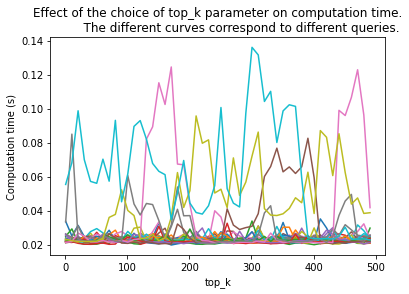

In [197]:
print(len(all_times))
for times in all_times:
    plt.plot(topk_values, times)
plt.xlabel('top_k')
plt.ylabel('Computation time (s)')
plt.title("Effect of the choice of top_k parameter on computation time.\n\
            The different curves correspond to different queries.");

There's no clear effect on computation time of the choice of top_k, so let's take it big.

In [198]:
# Quick and dirty
# Function that finds for each recipe in the Series menu_data[menu_label_col] the closest matching recipes in the recipe database
# embedded in 'database_embedding' with the NLP model 'model'
# The function returns a dataframe with the results
def find_and_store_most_similar_recipes(menu_data, menu_label_col, database_embedding, model, top_k = 20, radius = 0.1):
    dict_res = {}

    for index, row in menu_data.iterrows():    # loop on rows of menu_data
        query = row[menu_label_col]
        
        best_hits = most_similar_recipes(query, database_embedding, model, top_k = top_k, radius = radius)
        
        # Store results in a dictionary
        for k, hit in enumerate(best_hits):
            jow_recipe = jow_recipes[hit['corpus_id']]
        
            closest_jow = row['Closest JOW recipe by hand'] 
            if closest_jow[0]=='[':       # To detect lists because they have been converted to strings. Bad, Bad!
                matched_idx = 1 if jow_recipe in closest_jow else 0
            else:
                matched_idx = 1 if jow_recipe==closest_jow else 0

            # For each menu recipe (index) and hit (k), store menu_recipe_id, menu_recipe_label, jow_guess, similarity_rank, similary_score, is_matched
            dict_res[str(index)+'_'+str(k)] = [query, query, jow_recipe, k+1, hit['score'], matched_idx]  

    # Convert the dictionary to a dataframe
    data_res = pd.DataFrame.from_dict(dict_res, orient = 'index', \
                                    columns = ['menu_recipe_id', 'menu_recipe_label', 'jow_guess', 'similarity_rank', 'similarity_score', 'is_matched'])\
                                    .reset_index(drop = True)

    return data_res





Run it by labeling the menu recipes with their titles and subtitles only and by characterizing jow recipes only by their names (no ingredients)

In [199]:
top_k = jow_recipe_embeddings2.shape[0]       # Number of JOW recipes
df_res = find_and_store_most_similar_recipes(menu_data_withmatch, 'Menu Title and Subtitle', jow_recipe_embeddings2, model2, top_k = top_k, radius = 0.15)
df_res

,menu_recipe_id,menu_recipe_label,jow_guess,similarity_rank,similarity_score,is_matched
0,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Mousse au chocolat maison,1,0.954754,1
1,"Desserts, Fondant au chocolat artisan boulanger","Desserts, Fondant au chocolat artisan boulanger",Fondant au chocolat,1,0.859855,1
2,"Desserts, Fondant au chocolat artisan boulanger","Desserts, Fondant au chocolat artisan boulanger",Fondant-flan au chocolat & amande,2,0.836992,0
3,"Desserts, Fondant au chocolat artisan boulanger","Desserts, Fondant au chocolat artisan boulanger",Fondant choco marrons,3,0.758861,0
4,"Desserts, Fondant au chocolat artisan boulanger","Desserts, Fondant au chocolat artisan boulanger",Fondant au chocolat à l'huile d'olive,4,0.730659,0
...,...,...,...,...,...,...
1433,"Dolci, Boozy tiramisù","Dolci, Boozy tiramisù","Sucrine, prosciutto & oeuf mollet",4,0.413434,0
1434,"Dolci, Boozy tiramisù","Dolci, Boozy tiramisù",Cake marbré au dulce de leche,5,0.397211,0
1435,"Dolci, Boozy tiramisù","Dolci, Boozy tiramisù",Crumble poire chocolat,6,0.380269,0
1436,"Dolci, Boozy tiramisù","Dolci, Boozy tiramisù",Popsicle yaourt abricot & miel,7,0.373086,0


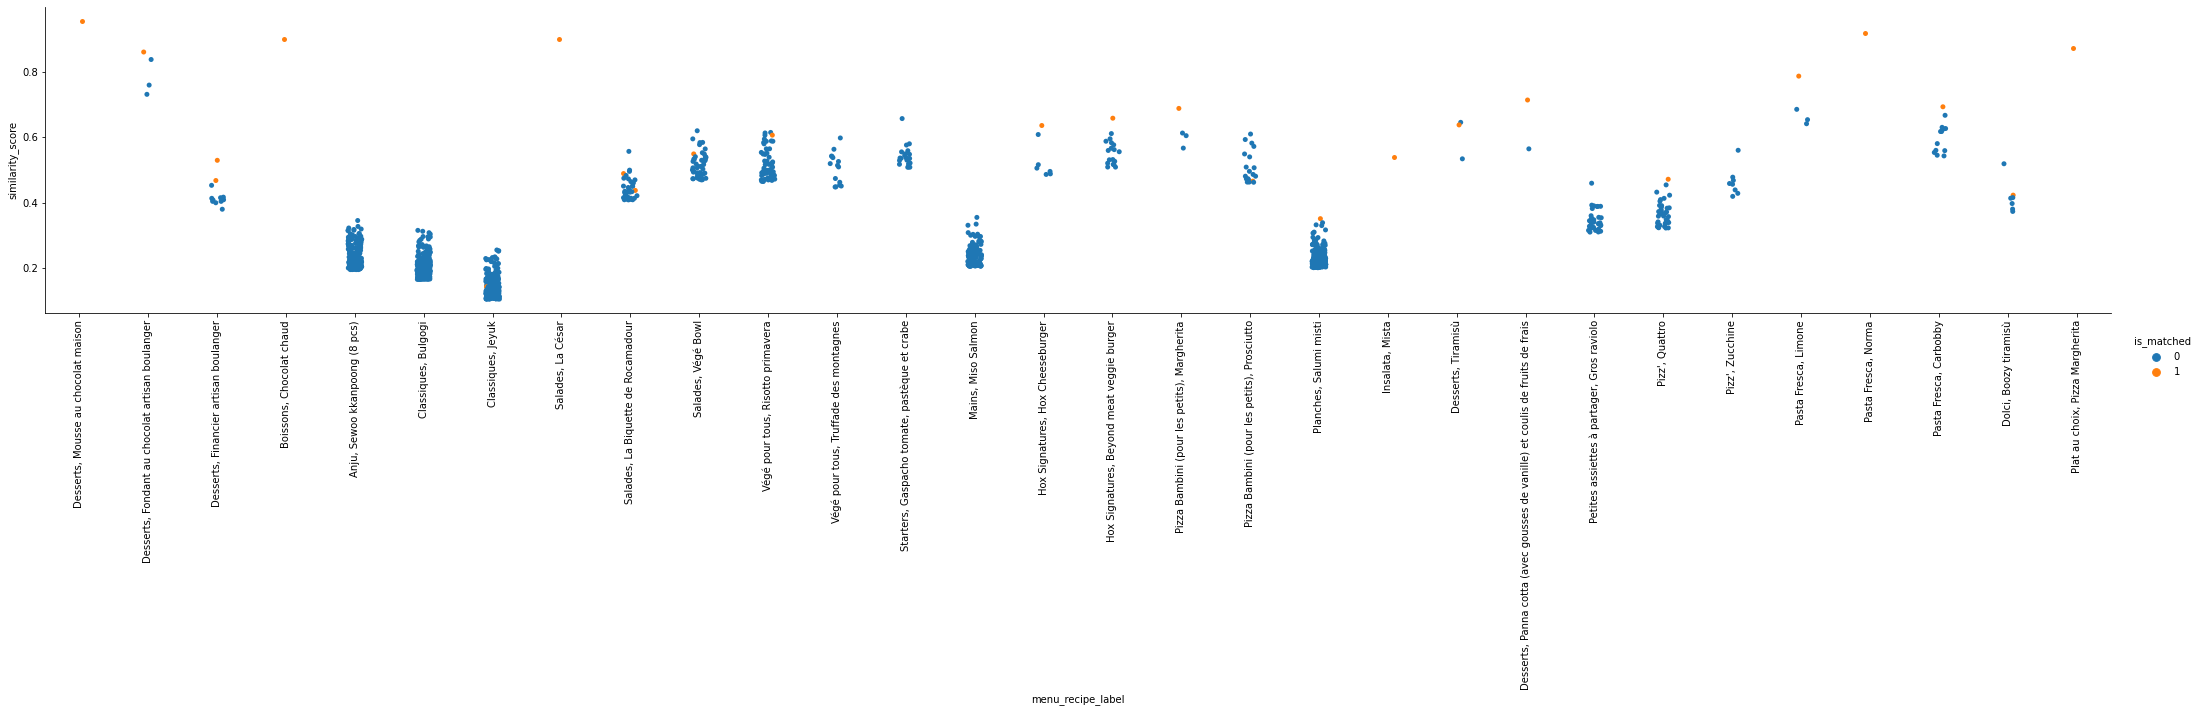

In [200]:
fig = sns.catplot(data = df_res, x = 'menu_recipe_label', y = 'similarity_score', hue = 'is_matched', kind = 'strip', aspect = 6)
fig.set_xticklabels(rotation=90);

In [201]:
print("Number of menu recipes for which the cloud of guessed jow recipes contains the matching Jow recipe found by hand:")
df_res[df_res['is_matched']==1].groupby('menu_recipe_id')['is_matched'].count().shape[0]

Number of menu recipes for which the cloud of guessed jow recipes contains the matching Jow recipe found by hand:


23

Even with radius=0.15, there are still 7 menu recipes (over 30) for which the cloud of guessed jow recipes does not contain the matching Jow recipe found by hand. For them, there is no hope to find the correct matching if we add a second NLP step by including the ingredients of menu recipes. Hence this does not seem to be a good approach to follow.

Let's see how many jow recipes we select for each menu recipe when radius is varied.

In [202]:
df_vs_radius = pd.DataFrame()

for radius in np.arange(0.05, 1, 0.1):
    df_tmp = find_and_store_most_similar_recipes(menu_data_withmatch, 'Menu Title and Subtitle', jow_recipe_embeddings2, \
                                                 model2, top_k = top_k, radius = radius)
    df_grouped = df_tmp.groupby('menu_recipe_id').count()
    df_vs_radius['jow_guesses_for_radius_'+str(radius)] = df_grouped['jow_guess']

df_vs_radius = df_vs_radius.reset_index()
df_vs_radius.head()

,menu_recipe_id,jow_guesses_for_radius_0.05,jow_guesses_for_radius_0.15000000000000002,jow_guesses_for_radius_0.25000000000000006,jow_guesses_for_radius_0.35000000000000003,jow_guesses_for_radius_0.45000000000000007,jow_guesses_for_radius_0.5500000000000002,jow_guesses_for_radius_0.6500000000000001,jow_guesses_for_radius_0.7500000000000002,jow_guesses_for_radius_0.8500000000000002,jow_guesses_for_radius_0.9500000000000002
0,"Anju, Sewoo kkanpoong (8 pcs)",14,173,755,1298,1403,1406,1406,1406,1406,1406
1,"Boissons, Chocolat chaud",1,1,3,4,9,29,49,246,900,1369
2,"Classiques, Bulgogi",16,287,991,1374,1406,1406,1406,1406,1406,1406
3,"Classiques, Jeyuk",15,285,1092,1402,1406,1406,1406,1406,1406,1406
4,"Desserts, Financier artisan boulanger",1,12,79,289,884,1371,1406,1406,1406,1406


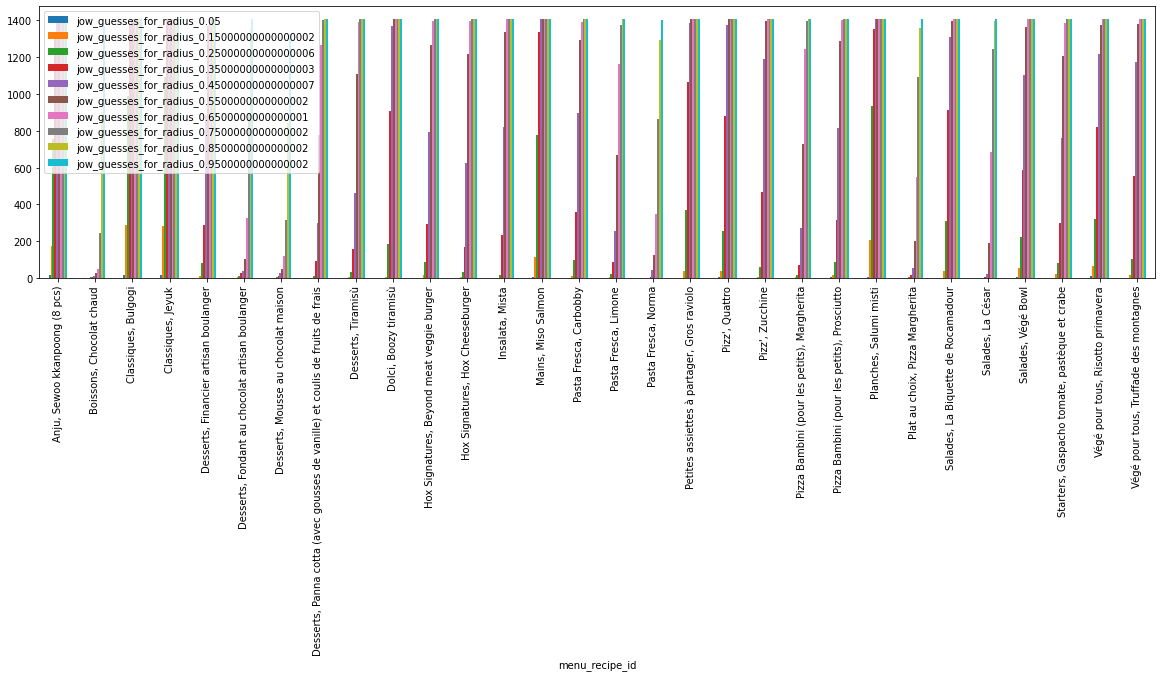

In [203]:
df_vs_radius.plot.bar(x = 'menu_recipe_id', y = list(df_vs_radius.columns)[1:], stacked = False, \
                      rot = 90, figsize = (20, 5)).legend(loc='best');

Looks obvious. Nothing interesting to say about it for now. 

Let's what happens now if we change the first NLP step and characterize jow recipes not only by their names but by their names + ingredients. The menu recipes are still labeled by their titles+subtitles only.

In [204]:
top_k = jow_fullname_embeddings2.shape[0]       # Number of JOW recipes
df_res2 = find_and_store_most_similar_recipes(menu_data_withmatch, 'Menu Title and Subtitle', jow_fullname_embeddings2, \
                                             model2, top_k = top_k, radius = 0.15)
df_res2

,menu_recipe_id,menu_recipe_label,jow_guess,similarity_rank,similarity_score,is_matched
0,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Mousse au chocolat maison,1,0.803918,1
1,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Truffes maison au chocolat,2,0.683853,0
2,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Crème au chocolat,3,0.668090,0
3,"Desserts, Fondant au chocolat artisan boulanger","Desserts, Fondant au chocolat artisan boulanger",Fondant au chocolat,1,0.775233,1
4,"Desserts, Fondant au chocolat artisan boulanger","Desserts, Fondant au chocolat artisan boulanger",Fondant-flan au chocolat & amande,2,0.731334,0
...,...,...,...,...,...,...
3562,"Plat au choix, Pizza Margherita","Plat au choix, Pizza Margherita",Pizza Parma,5,0.602379,0
3563,"Plat au choix, Pizza Margherita","Plat au choix, Pizza Margherita",Pizza champignons & ricotta,6,0.592266,0
3564,"Plat au choix, Pizza Margherita","Plat au choix, Pizza Margherita",Pizza puttanesca,7,0.588715,0
3565,"Plat au choix, Pizza Margherita","Plat au choix, Pizza Margherita",Pizza au chorizo,8,0.585899,0


/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 57.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 46.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 69.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 25.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 34.7% of the points cannot be placed; y

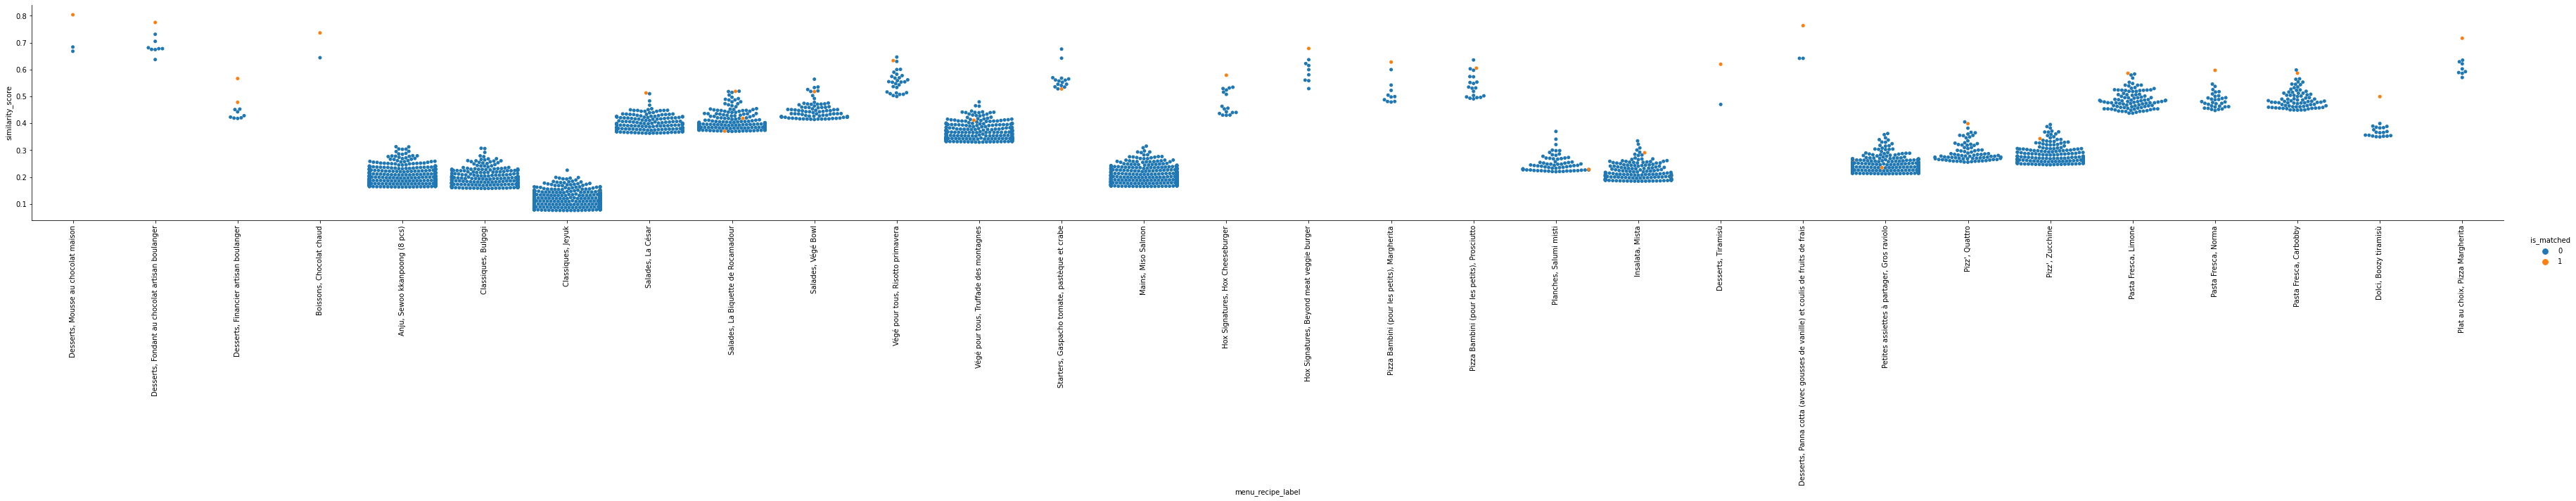

In [205]:
fig = sns.catplot(data = df_res2, x = 'menu_recipe_label', y = 'similarity_score', hue = 'is_matched', kind = 'swarm', aspect = 10)
fig.set_xticklabels(rotation=90);

In [206]:
print("Number of menu recipes for which the cloud of guessed jow recipes contains the matching Jow recipe found by hand:")
df_res2[df_res2['is_matched']==1].groupby('menu_recipe_id')['is_matched'].count().shape[0]

Number of menu recipes for which the cloud of guessed jow recipes contains the matching Jow recipe found by hand:


27

This is better than before : there are (only) 3 menu recipes (over 30) for which the cloud of guessed jow recipes does not contain the matching Jow recipe found by hand. For them, there is no hope to find the correct matching if we add a second NLP step by including the ingredients of menu recipes. 

Let's see now how all this varies when we change the radius.

In [207]:
df_res2.groupby('menu_recipe_id')['is_matched'].count()

menu_recipe_id
Anju, Sewoo kkanpoong (8 pcs)                                                   418
Boissons, Chocolat chaud                                                          2
Classiques, Bulgogi                                                             276
Classiques, Jeyuk                                                               575
Desserts, Financier artisan boulanger                                            10
Desserts, Fondant au chocolat artisan boulanger                                   9
Desserts, Mousse au chocolat maison                                               3
Desserts, Panna cotta (avec gousses de vanille) et coulis de fruits de frais      3
Desserts, Tiramisù                                                                2
Dolci, Boozy tiramisù                                                            20
Hox Signatures, Beyond meat veggie burger                                         9
Hox Signatures, Hox Cheeseburger                             

In [208]:
df_res2[df_res2['is_matched']==1].groupby('menu_recipe_id')['is_matched'].count()

menu_recipe_id
Boissons, Chocolat chaud                                                        1
Classiques, Jeyuk                                                               1
Desserts, Financier artisan boulanger                                           2
Desserts, Fondant au chocolat artisan boulanger                                 1
Desserts, Mousse au chocolat maison                                             1
Desserts, Panna cotta (avec gousses de vanille) et coulis de fruits de frais    1
Desserts, Tiramisù                                                              1
Dolci, Boozy tiramisù                                                           1
Hox Signatures, Beyond meat veggie burger                                       1
Hox Signatures, Hox Cheeseburger                                                1
Insalata, Mista                                                                 2
Pasta Fresca, Carbobby                                                          1
P

In [209]:
list1 = []
list2 = []
for radius in np.arange(0.05, 1, 0.05):
    # Method a (Jow recipes with names only)
    top_k = jow_recipe_embeddings2.shape[0]       # Number of JOW recipes
    df_res1 = find_and_store_most_similar_recipes(menu_data_withmatch, 'Menu Title and Subtitle', jow_recipe_embeddings2, \
                                                  model2, top_k = top_k, radius = radius)
    list1.append(df_res1[df_res1['is_matched']==1].groupby('menu_recipe_id')['is_matched'].count().shape[0])

    # Method b (Jow recipes with names + ingredients)
    top_k = jow_fullname_embeddings2.shape[0]       # Number of JOW recipes
    df_res2 = find_and_store_most_similar_recipes(menu_data_withmatch, 'Menu Title and Subtitle', jow_fullname_embeddings2, \
                                                model2, top_k = top_k, radius = radius)
    list2.append(df_res2[df_res2['is_matched']==1].groupby('menu_recipe_id')['is_matched'].count().shape[0])

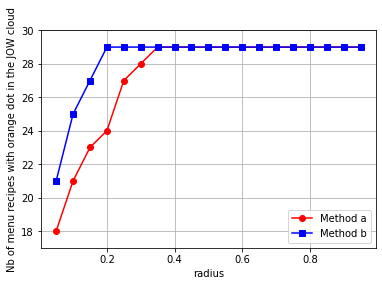

In [210]:
plt.plot(np.arange(0.05, 1, 0.05), list1, '-ro', label = "Method a")
plt.plot(np.arange(0.05, 1, 0.05), list2, '-bs', label = "Method b")
plt.xlabel('radius')
plt.ylabel('Nb of menu recipes with orange dot in the JOW cloud')
plt.legend()
plt.grid()
plt.ylim([17, 30]);

Method b is indeed a bit better but we need also to see how many recipes there are in each cloud to complete the comparison.  
**I don't have time to do this now, I keep it for later. Don't forget!**

#### Let's now tackle the second step ie refinement in each cloud

In [268]:
# Quick and very dirty -> only for test, should be absolutely re-written if used later
# Function that returns for a given query the 3 closest hits in jow recipes (with the score and recipe name)
# Done with 2 NLP steps
def top_recipes_after_refinement(row, database_embedding, model, top_k = 20, radius = 0.1):
    menu_name_query = row['Menu Title and Subtitle']
    menu_name_query_embedding = model.encode(menu_name_query, convert_to_tensor=True)
    menu_fullname_query = row['Menu all']
    menu_fullname_query_embedding = model.encode(menu_fullname_query, convert_to_tensor=True)

    # First NLP step
    hits = util.semantic_search(menu_name_query_embedding, database_embedding, top_k = top_k)    #find the top_k closest database recipes from query
    hits = hits[0]      #Get the hits for the first query (here only one query is given)

    # Keep only the recipes whose similarity scores are highest that max_score - radius
    best_hits = []
    for k, hit in enumerate(hits):
        max_score = hits[0]['score']  # hits is stored by descending scores
        if hit['score'] > max_score - radius:
            best_hits.append(hit)

    # jow recipes in best_hits and their embeddings
    print("query = ", query)
    jow_in_cloud_names = [jow_recipes[hit['corpus_id']] for hit in best_hits]     # Names of jow recipes in the cloud
    print(jow_in_cloud_names)
    jow_in_cloud_fullnames = []
    for recipe_name in jow_in_cloud_names:
        jow_in_cloud_fullnames.append(jow_data[jow_data['recipe_name']==recipe_name]['name_with_ingredients'].values[0])
    print(jow_in_cloud_fullnames)
    print("************")
    jow_cloud_embeddings = model.encode(jow_in_cloud_fullnames, convert_to_tensor=True)

    # Second NLP step
    top_hits = util.semantic_search(menu_fullname_query_embedding, jow_cloud_embeddings, top_k = 10)    #find the 10 closest database recipes from query
    top_hits = top_hits[0]      #Get the hits for the first query (here only one query is given)

    # Add the jow recipe corresponding to each hit
    for k, hit in enumerate(top_hits):
        hit['jow_recipe'] = jow_in_cloud_names[hit['corpus_id']]

    return top_hits

def find_and_store_best_recipes_after_refinement(menu_data, database_embedding, model, top_k = 20, radius = 0.1):
    dict_res = {}

    for index, row in menu_data.iterrows():    # loop on rows of menu_data
        best_hits = top_recipes_after_refinement(row, database_embedding, model, top_k = top_k, radius = radius)

        # Store results in a dictionary
        for k, hit in enumerate(best_hits):
            jow_recipe = hit['jow_recipe']
        
            closest_jow = row['Closest JOW recipe by hand'] 
            if closest_jow[0]=='[':       # To detect lists because they have been converted to strings. Bad, Bad!
                matched_idx = 1 if jow_recipe in closest_jow else 0
            else:
                matched_idx = 1 if jow_recipe==closest_jow else 0

            # For each menu recipe (index) and hit (k), store menu_recipe_name, menu_recipe_all, jow_guess, similarity_rank, similary_score, is_matched
            menu_name_query = row['Menu Title and Subtitle']
            menu_fullname_query = row['Menu all']
            dict_res[str(index)+'_'+str(k)] = [menu_name_query, menu_fullname_query, jow_recipe, k+1, hit['score'], matched_idx]  

    # Convert the dictionary to a dataframe
    data_res = pd.DataFrame.from_dict(dict_res, orient = 'index', \
                                    columns = ['menu_recipe_id', 'menu_recipe_label', 'jow_guess', 'similarity_rank', 'similarity_score', 'is_matched'])\
                                    .reset_index(drop = True)

    return data_res

In [282]:
top_k = jow_fullname_embeddings2.shape[0]       # Number of JOW recipes
df_res2_vf = find_and_store_best_recipes_after_refinement(menu_data_withmatch, jow_fullname_embeddings2, \
                                                model2, top_k = top_k, radius = 0.2)

query =  Plat au choix, Pizza Margherita
['Mousse au chocolat maison', 'Truffes maison au chocolat', 'Crème au chocolat', 'Tarte au chocolat', "Mousse au chocolat à l'orange", 'Pâte à tartiner au chocolat', 'Bûche de Noël au chocolat', 'Fondant au chocolat', 'Fondant choco marrons']
['Mousse au chocolat maison, Chocolat à cuire, Œuf', 'Truffes maison au chocolat, Chocolat à cuire, Beurre, Crème liquide, Cacao', 'Crème au chocolat, Chocolat à cuire, Lait, Sucre, Maïzena', 'Tarte au chocolat, Sucre, Chocolat à cuire, Farine de blé, Beurre demi-sel, Crème liquide 30%', "Mousse au chocolat à l'orange, Chocolat à cuire, Œuf, Grand Marnier, Orange", 'Pâte à tartiner au chocolat, Noisette, Chocolat à cuire, Crème liquide, Sucre, Huile de tournesol', 'Bûche de Noël au chocolat, Œuf, Farine de blé, Sucre, Levure chimique, Chocolat à cuire, Crème liquide 30%, Beurre', 'Fondant au chocolat, Chocolat à cuire, Beurre demi-sel, Sucre, Œuf', 'Fondant choco marrons, Œuf, Beurre demi-sel, Chocolat à cu

In [283]:
df_res2_vf

,menu_recipe_id,menu_recipe_label,jow_guess,similarity_rank,similarity_score,is_matched
0,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Mousse au chocolat maison,1,0.803919,1
1,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Truffes maison au chocolat,2,0.683852,0
2,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Crème au chocolat,3,0.668090,0
3,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Tarte au chocolat,4,0.648898,0
4,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Mousse au chocolat à l'orange,5,0.626683,0
...,...,...,...,...,...,...
283,"Plat au choix, Pizza Margherita","Plat au choix, Pizza Margherita",Pizza champignons & ricotta,6,0.592266,0
284,"Plat au choix, Pizza Margherita","Plat au choix, Pizza Margherita",Pizza puttanesca,7,0.588715,0
285,"Plat au choix, Pizza Margherita","Plat au choix, Pizza Margherita",Pizza au chorizo,8,0.585899,0
286,"Plat au choix, Pizza Margherita","Plat au choix, Pizza Margherita",Pâte à pizza maison,9,0.570356,0


In [284]:
print("Number of good matchings among outputs with rank 1 :")
df_res2_vf[(df_res2_vf['similarity_rank']==1) & (df_res2_vf['is_matched']==1)].shape[0]

Number of good matchings among outputs with rank 1 :


19

In [285]:
print("Number of good matchings among outputs with rank between 2 and 10 :")
df_res2_vf[(df_res2_vf['similarity_rank']>1) & (df_res2_vf['similarity_rank']<=10) & (df_res2_vf['is_matched']==1)].shape[0]

Number of good matchings among outputs with rank between 2 and 10 :


6

In [286]:
df_res2_vf['method'] = '2 steps'
df_res2_vf['menu_labels'] = '2 steps'
data_res_tot4 = pd.concat([data_res3, df_res2_vf], axis = 0)
data_res_tot4

,menu_recipe_id,menu_recipe_label,jow_guess,similarity_rank,similarity_score,is_matched,method,menu_labels
0,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Mousse au chocolat maison,1,0.803918,1,Menu all + Jow titles & ingredients (1 step),All
1,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Truffes maison au chocolat,2,0.683853,0,Menu all + Jow titles & ingredients (1 step),All
2,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Crème au chocolat,3,0.668090,0,Menu all + Jow titles & ingredients (1 step),All
3,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Tarte au chocolat,4,0.648898,0,Menu all + Jow titles & ingredients (1 step),All
4,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison",Mousse au chocolat à l'orange,5,0.626683,0,Menu all + Jow titles & ingredients (1 step),All
...,...,...,...,...,...,...,...,...
283,"Plat au choix, Pizza Margherita","Plat au choix, Pizza Margherita",Pizza champignons & ricotta,6,0.592266,0,2 steps,2 steps
284,"Plat au choix, Pizza Margherita","Plat au choix, Pizza Margherita",Pizza puttanesca,7,0.588715,0,2 steps,2 steps
285,"Plat au choix, Pizza Margherita","Plat au choix, Pizza Margherita",Pizza au chorizo,8,0.585899,0,2 steps,2 steps
286,"Plat au choix, Pizza Margherita","Plat au choix, Pizza Margherita",Pâte à pizza maison,9,0.570356,0,2 steps,2 steps


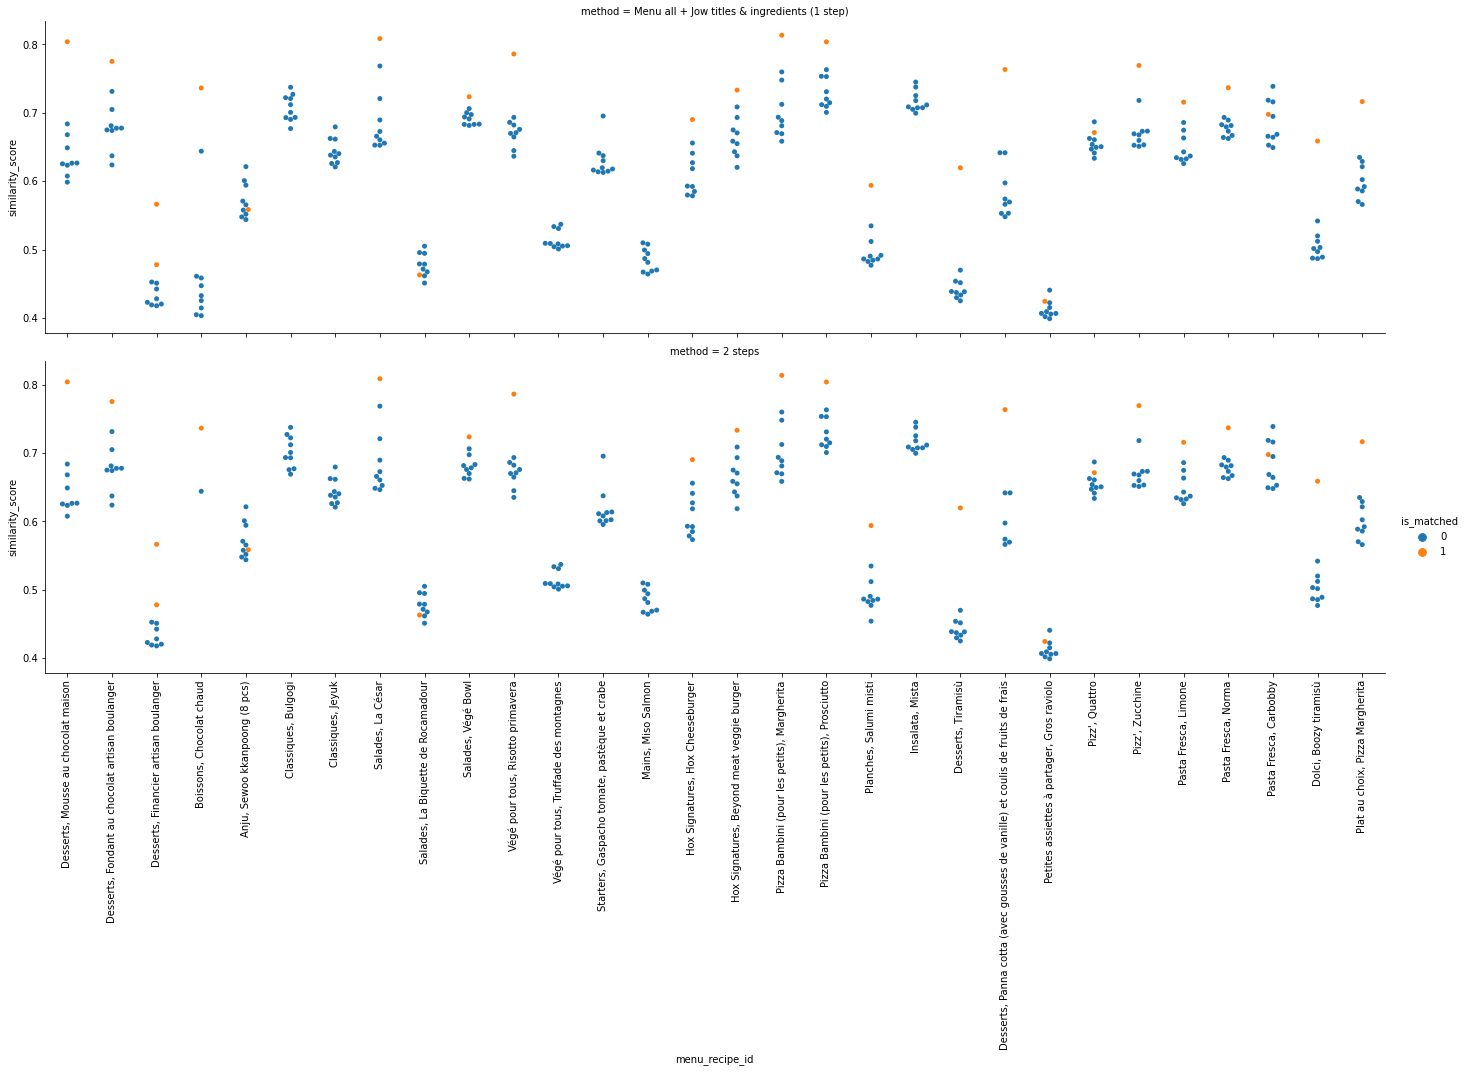

In [287]:
fig = sns.catplot(data = data_res_tot4, x = 'menu_recipe_id', y = 'similarity_score', row = 'method', \
                  hue = 'is_matched', kind = 'swarm', aspect = 4)
fig.set_xticklabels(rotation=90);

Varying the radius (radius = 0.1, 0.15, or 0.2) does not help.   
**Conclusion : It turns out that this method in two steps gives the same number of correct matches with rank 1 than the best previous method (considering all menu infos + jow names & ingredients). Note however that among the 30 predictions with rank 1 (correct or not), 29 are identical with the 2 methods while 1 differs (Anju, Sewoo kkanpoong (8 pcs)). So mathematically speaking, the two methods are not fully equivalent.** 